In [5]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from solver_1d import false_transient_one_iteration_python
import global_parameters as gp
from supportfunctions import PDESolver_2d, finiteDiff
import matplotlib.pyplot as plt
from numba import njit,jit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode
import plotly.graph_objects as go
from scipy import interpolate
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Smooth Ambiguity
Base line model, no ambiguity:
$$
\begin{aligned}
0 = \max_{\tilde e}\min_h & - \delta \phi(y) + \delta\eta \log\tilde e \\
&  + \frac{\xi_m}{2} h'h + \frac{d\phi(y)}{dy} \tilde e (\theta + \sigma_y h) + \frac{1}{2}\frac{d^2\phi(y)}{dy^2}|\sigma_y|^2(\tilde e)^2\\
                           & + (\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot (\theta + \sigma_y h)
\end{aligned}
$$

In [8]:
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
ȳ= 2
ξₘ = 0.002
ξₐ = 1/10_000
years = np.linspace(0,100)

In [9]:
# y grid
n_y = 200
y_min = 1e-10
y_max = 10
y_grid = np.linspace(y_min, y_max, n_y)
dy = y_grid[1] - y_grid[0]

In [11]:
# no ambguity
def solve_no_ambiguity(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ, σy, γ1, γ2, γ3, ȳ = args
    hy = y_grid[1] - y_grid[0]
    # initialize the while loop
    episode = 0
    lhs_error = 1
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    ϕ =  - δ*η*y_grid**2
    ems = - δ*η/((η-1)*dΛ*θ)
    ems_old = ems
    h_star = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, hy)
        dϕdyy = derivative_1d(ϕ, 2, hy)
        temp = dϕdy + (η-1)*dΛ
        a = dϕdyy*σy**2  
        b = temp*θ
        c = δ*η
        Δ = b**2 - 4*a*c
        ems_new = (-b - np.sqrt(Δ))/(2*a)
        ems_new[ems_new <= 1e-15] = 1e-15    
        ems = ems_new*1 + ems_old*0
        # coefficients
        A = -δ*np.ones(y_grid.shape)
        B = ems*θ
        C = σy**2*ems**2/2
        D = δ*η*np.log(ems) + (η-1)*dΛ*ems*θ

        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems

In [12]:
@njit 
def simulate_no_amb(y_grid, ems, θ,  dt=1, T=100):
    # initiate
    periods = int(T/dt)
    ems_t = np.zeros(periods)
    y_t = np.zeros(periods)
    # interpolate
    y0 = θ*290
    y = y0
    for t in range(periods):
        ems_point = np.interp(y, y_grid, ems)
        ems_t[t] = ems_point
        dy = ems_point*θ*dt
        y = dy + y
        y_t[t] = y
    return y_t, ems_t

In [13]:
γ3 = np.average(γ3_list, weights=[0.5, 0.5, 0])
args = (δ, η, μ, σy, γ1, γ2, γ3, ȳ)
ϕ_avg_no_amb, ems_avg_no_amb = solve_no_ambiguity(y_grid, args)

episode: 1,	 ode error: 0.0015766763841096481,	 ft error: 0.0014676685630658616
episode: 2,	 ode error: 0.001493766434348463,	 ft error: 0.0013174960200154299
episode: 3,	 ode error: 0.0013652266098781109,	 ft error: 0.0012769471488738066
episode: 4,	 ode error: 0.001293352203485799,	 ft error: 0.0012222876280597289
episode: 5,	 ode error: 0.0012373829938298504,	 ft error: 0.0011817920441123347
episode: 6,	 ode error: 0.0011939232460112192,	 ft error: 0.0011479074330843055
episode: 7,	 ode error: 0.0011578202371921504,	 ft error: 0.00111863013754007
episode: 8,	 ode error: 0.001127408984766105,	 ft error: 0.001093217386936208
episode: 9,	 ode error: 0.0011009929580508998,	 ft error: 0.0010706306339171576
episode: 10,	 ode error: 0.001077579482566057,	 ft error: 0.0010499808102310327
episode: 11,	 ode error: 0.001056334523915209,	 ft error: 0.0010313506615008483
episode: 12,	 ode error: 0.0010371438891582522,	 ft error: 0.001014269539772545
episode: 13,	 ode error: 0.0010195658663514065

episode: 188,	 ode error: 0.00033384416140996333,	 ft error: 0.0003324859030415239
episode: 189,	 ode error: 0.0003321264869723978,	 ft error: 0.0003307811914029143
episode: 190,	 ode error: 0.0003304172400583088,	 ft error: 0.00032908474564991946
episode: 191,	 ode error: 0.00032871638765198804,	 ft error: 0.00032739653644084843
episode: 192,	 ode error: 0.0003270214645996705,	 ft error: 0.0003265273624827638
episode: 193,	 ode error: 0.0003253467722708716,	 ft error: 0.00032487243290725554
episode: 194,	 ode error: 0.0003236774703132978,	 ft error: 0.00032322020053784006
episode: 195,	 ode error: 0.0003220142713598113,	 ft error: 0.00032157231548641624
episode: 196,	 ode error: 0.00032035768545262853,	 ft error: 0.00031992988240111636
episode: 197,	 ode error: 0.0003187080782035951,	 ft error: 0.0003182936446478879
episode: 198,	 ode error: 0.00031706571153349613,	 ft error: 0.00031666410791680405
episode: 199,	 ode error: 0.0003154307725452241,	 ft error: 0.0003150416201353849
episo

episode: 397,	 ode error: 0.00011443891452843575,	 ft error: 0.0001142865612039958
episode: 398,	 ode error: 0.00011387000657963687,	 ft error: 0.00011372009991813167
episode: 399,	 ode error: 0.0001133041006147193,	 ft error: 0.00011315661205729226
episode: 400,	 ode error: 0.00011274117958153895,	 ft error: 0.0001125960810699489
episode: 401,	 ode error: 0.00011218122653202571,	 ft error: 0.00011203849049655953
episode: 402,	 ode error: 0.0001116242246219667,	 ft error: 0.00011148382396417948
episode: 403,	 ode error: 0.00011107015711068027,	 ft error: 0.00011093206519645349
episode: 404,	 ode error: 0.000110519007360787,	 ft error: 0.0001103831980062836
episode: 405,	 ode error: 0.00010997075883786096,	 ft error: 0.00010983720629922922
episode: 406,	 ode error: 0.00010942539511013289,	 ft error: 0.00010929407407353024
episode: 407,	 ode error: 0.00010888289984812215,	 ft error: 0.00010875378541684577
episode: 408,	 ode error: 0.00010834325682425327,	 ft error: 0.0001082163245113658


episode: 612,	 ode error: 4.041821592733858e-05,	 ft error: 4.048794515980336e-05
episode: 613,	 ode error: 4.0227582122541244e-05,	 ft error: 4.0297633067630054e-05
episode: 614,	 ode error: 4.003787180728276e-05,	 ft error: 4.010824067030942e-05
episode: 615,	 ode error: 3.9849080155474276e-05,	 ft error: 3.991976316027509e-05
episode: 616,	 ode error: 3.966120237127195e-05,	 ft error: 3.9732195760306774e-05
episode: 617,	 ode error: 3.947423368884113e-05,	 ft error: 3.9545533721679904e-05
episode: 618,	 ode error: 3.928816937218821e-05,	 ft error: 3.9359772327357545e-05
episode: 619,	 ode error: 3.9103004714911805e-05,	 ft error: 3.917490688812771e-05
episode: 620,	 ode error: 3.891873503999543e-05,	 ft error: 3.8990932745147644e-05
episode: 621,	 ode error: 3.873535569960684e-05,	 ft error: 3.8807845267584594e-05
episode: 622,	 ode error: 3.855286207484995e-05,	 ft error: 3.862563985437366e-05
episode: 623,	 ode error: 3.8371249575588754e-05,	 ft error: 3.84443119318123e-05
episode

episode: 825,	 ode error: 1.4882687341120785e-05,	 ft error: 1.4953992648220987e-05
episode: 826,	 ode error: 1.4813316909889954e-05,	 ft error: 1.4884352413646607e-05
episode: 827,	 ode error: 1.474427007855687e-05,	 ft error: 1.4815033171263389e-05
episode: 828,	 ode error: 1.4675545306592434e-05,	 ft error: 1.47460333828342e-05
episode: 829,	 ode error: 1.4607141061209294e-05,	 ft error: 1.4677351505380336e-05
episode: 830,	 ode error: 1.4539055817295709e-05,	 ft error: 1.4608986014195507e-05
episode: 831,	 ode error: 1.4471288057404269e-05,	 ft error: 1.4540935383393813e-05
episode: 832,	 ode error: 1.4403836271693676e-05,	 ft error: 1.4473198098446013e-05
episode: 833,	 ode error: 1.4336698957882559e-05,	 ft error: 1.4405772657174095e-05
episode: 834,	 ode error: 1.426987462123093e-05,	 ft error: 1.4338657555410899e-05
episode: 835,	 ode error: 1.4203361774496929e-05,	 ft error: 1.4271851304601773e-05
episode: 836,	 ode error: 1.4137158937884884e-05,	 ft error: 1.4205352415891381e

episode: 1030,	 ode error: 6.194114190391465e-06,	 ft error: 5.65318817385511e-06
episode: 1031,	 ode error: 6.179960145679254e-06,	 ft error: 5.625511417389761e-06
episode: 1032,	 ode error: 6.165882032488205e-06,	 ft error: 5.5979539157850295e-06
episode: 1033,	 ode error: 6.151879564847418e-06,	 ft error: 5.570515056984212e-06
episode: 1034,	 ode error: 6.137952459027581e-06,	 ft error: 5.543194249816678e-06
episode: 1035,	 ode error: 6.124100432843504e-06,	 ft error: 5.515990889974158e-06
episode: 1036,	 ode error: 6.110323206233838e-06,	 ft error: 5.488904386771742e-06
episode: 1037,	 ode error: 6.096620500844314e-06,	 ft error: 5.461934138399164e-06
episode: 1038,	 ode error: 6.082992040466512e-06,	 ft error: 5.435079565505041e-06
episode: 1039,	 ode error: 6.069437550290527e-06,	 ft error: 5.408340076386761e-06
episode: 1040,	 ode error: 6.055956757520251e-06,	 ft error: 5.3817150764273736e-06
episode: 1041,	 ode error: 6.042549391486237e-06,	 ft error: 5.355203986506796e-06
epi

episode: 1235,	 ode error: 4.739944292976193e-06,	 ft error: 2.6724115566312268e-06
episode: 1236,	 ode error: 4.746964130401842e-06,	 ft error: 2.28401780417072e-06
episode: 1237,	 ode error: 4.713460551031062e-06,	 ft error: 2.4230599359835e-06
episode: 1238,	 ode error: 4.7136559657210255e-06,	 ft error: 2.449389786343681e-06
episode: 1239,	 ode error: 4.715507678064814e-06,	 ft error: 2.479578611868742e-06
episode: 1240,	 ode error: 4.719138697079463e-06,	 ft error: 2.5160563025862967e-06
episode: 1241,	 ode error: 4.724804268005172e-06,	 ft error: 2.5626879000701748e-06
episode: 1242,	 ode error: 4.73296559167077e-06,	 ft error: 2.626001184268904e-06
episode: 1243,	 ode error: 4.739342930447084e-06,	 ft error: 2.2230412999544686e-06
episode: 1244,	 ode error: 4.705080309190318e-06,	 ft error: 2.388957780855942e-06
episode: 1245,	 ode error: 4.7054766471035445e-06,	 ft error: 2.4261168350576496e-06
episode: 1246,	 ode error: 4.708135834174715e-06,	 ft error: 2.4705166826293388e-06


episode: 1436,	 ode error: 4.044073016338666e-06,	 ft error: 1.0750304166769662e-06
episode: 1437,	 ode error: 4.024946244352771e-06,	 ft error: 1.633698106159413e-06
episode: 1438,	 ode error: 4.04464935475652e-06,	 ft error: 1.0686342425079525e-06
episode: 1439,	 ode error: 4.025274480463806e-06,	 ft error: 1.6289361074473911e-06
episode: 1440,	 ode error: 4.0448797568737186e-06,	 ft error: 1.0623370078760574e-06
episode: 1441,	 ode error: 4.025269982606749e-06,	 ft error: 1.6205388725723524e-06
episode: 1442,	 ode error: 4.044628087083134e-06,	 ft error: 1.0561264050801267e-06
episode: 1443,	 ode error: 4.0248063824208395e-06,	 ft error: 1.6087668088665685e-06
episode: 1444,	 ode error: 4.0437872774674085e-06,	 ft error: 1.0499907573494986e-06
episode: 1445,	 ode error: 4.0237844927903076e-06,	 ft error: 1.5939328201648266e-06
episode: 1446,	 ode error: 4.042278220346392e-06,	 ft error: 1.0439193056747491e-06
episode: 1447,	 ode error: 4.022131393062781e-06,	 ft error: 1.57641318046

episode: 1636,	 ode error: 3.850224688499589e-06,	 ft error: 1.0623376833311198e-06
episode: 1637,	 ode error: 3.871459476559574e-06,	 ft error: 7.605451716787467e-07
episode: 1638,	 ode error: 3.849412776009116e-06,	 ft error: 7.584950451518709e-07
episode: 1639,	 ode error: 3.832879294843154e-06,	 ft error: 9.744408313467716e-07
episode: 1640,	 ode error: 3.851114662046379e-06,	 ft error: 7.548435676981343e-07
episode: 1641,	 ode error: 3.834731149081577e-06,	 ft error: 1.0515166560277438e-06
episode: 1642,	 ode error: 3.856567808031386e-06,	 ft error: 7.513494910728798e-07
episode: 1643,	 ode error: 3.835232174596707e-06,	 ft error: 7.49240437770508e-07
episode: 1644,	 ode error: 3.819406417721158e-06,	 ft error: 9.76003832626101e-07
episode: 1645,	 ode error: 3.838695412808975e-06,	 ft error: 7.456685475563478e-07
episode: 1646,	 ode error: 3.822942950712635e-06,	 ft error: 1.063464508584596e-06
episode: 1647,	 ode error: 3.846192809293003e-06,	 ft error: 7.425780914708617e-07
epis

episode: 1832,	 ode error: 3.7516044881905942e-06,	 ft error: 9.679502424702244e-07
episode: 1833,	 ode error: 3.773760393178862e-06,	 ft error: 6.413661466040759e-07
episode: 1834,	 ode error: 3.7559587785205868e-06,	 ft error: 9.990899603346908e-07
episode: 1835,	 ode error: 3.7787245509142376e-06,	 ft error: 6.449646911335649e-07
episode: 1836,	 ode error: 3.755909330483342e-06,	 ft error: 6.401479689157238e-07
episode: 1837,	 ode error: 3.7386069702336064e-06,	 ft error: 7.137750849285178e-07
episode: 1838,	 ode error: 3.7551112025997887e-06,	 ft error: 6.372987941538621e-07
episode: 1839,	 ode error: 3.7380534504099887e-06,	 ft error: 7.838246686431294e-07
episode: 1840,	 ode error: 3.756388587547281e-06,	 ft error: 6.357991917902799e-07
episode: 1841,	 ode error: 3.7394087131489362e-06,	 ft error: 8.481846068437531e-07
episode: 1842,	 ode error: 3.7592591544330367e-06,	 ft error: 6.356237807041606e-07
episode: 1843,	 ode error: 3.742239905244046e-06,	 ft error: 9.080125826232965e

episode: 2029,	 ode error: 3.521611223065253e-06,	 ft error: 4.109017384447874e-07
episode: 2030,	 ode error: 3.510668186077078e-06,	 ft error: 4.098362952250264e-07
episode: 2031,	 ode error: 3.5004756394578637e-06,	 ft error: 4.087167077236146e-07
episode: 2032,	 ode error: 3.4953196918762223e-06,	 ft error: 1.1407995827277437e-06
episode: 2033,	 ode error: 3.5266113809198554e-06,	 ft error: 4.074411868078739e-07
episode: 2034,	 ode error: 3.5151891720145833e-06,	 ft error: 4.063982140857977e-07
episode: 2035,	 ode error: 3.504558109634448e-06,	 ft error: 4.0528858033517245e-07
episode: 2036,	 ode error: 3.4991658814173413e-06,	 ft error: 1.1989889729668857e-06
episode: 2037,	 ode error: 3.5315833923433085e-06,	 ft error: 4.040988293753841e-07
episode: 2038,	 ode error: 3.519709366346592e-06,	 ft error: 4.031249030654142e-07
episode: 2039,	 ode error: 3.5086646882704015e-06,	 ft error: 4.0207998009781737e-07
episode: 2040,	 ode error: 3.5029319734572375e-06,	 ft error: 1.209991849389

episode: 2222,	 ode error: 3.456458796671758e-06,	 ft error: 3.555554327812812e-07
episode: 2223,	 ode error: 3.4482438738258356e-06,	 ft error: 3.5452007251154016e-07
episode: 2224,	 ode error: 3.440574069231341e-06,	 ft error: 3.534382763311269e-07
episode: 2225,	 ode error: 3.4334046854154468e-06,	 ft error: 3.523197827232094e-07
episode: 2226,	 ode error: 3.4266948151657475e-06,	 ft error: 3.511716615880086e-07
episode: 2227,	 ode error: 3.4204070446507704e-06,	 ft error: 3.499990761564783e-07
episode: 2228,	 ode error: 3.4191484545557796e-06,	 ft error: 1.3213056811063144e-06
episode: 2229,	 ode error: 3.456274990446093e-06,	 ft error: 3.485324419118715e-07
episode: 2230,	 ode error: 3.4477445107474955e-06,	 ft error: 3.476685615326029e-07
episode: 2231,	 ode error: 3.439790489406509e-06,	 ft error: 3.4674456037923446e-07
episode: 2232,	 ode error: 3.432365712889053e-06,	 ft error: 3.457649470905988e-07
episode: 2233,	 ode error: 3.425426843636217e-06,	 ft error: 3.447421718696016

episode: 2417,	 ode error: 3.406074286675621e-06,	 ft error: 2.9168610708498377e-07
episode: 2418,	 ode error: 3.4019290222851977e-06,	 ft error: 1.269693223985661e-06
episode: 2419,	 ode error: 3.434870336724207e-06,	 ft error: 3.0410067503502025e-07
episode: 2420,	 ode error: 3.4242529834635233e-06,	 ft error: 2.9683070211274554e-07
episode: 2421,	 ode error: 3.4144060055818883e-06,	 ft error: 2.942411100765689e-07
episode: 2422,	 ode error: 3.4052653127667094e-06,	 ft error: 2.908681725801351e-07
episode: 2423,	 ode error: 3.4012527291124757e-06,	 ft error: 1.2849702202624713e-06
episode: 2424,	 ode error: 3.4346341643451362e-06,	 ft error: 3.0400604655173025e-07
episode: 2425,	 ode error: 3.424067103899829e-06,	 ft error: 2.9629443074978096e-07
episode: 2426,	 ode error: 3.4142660674317364e-06,	 ft error: 2.9375969014949765e-07
episode: 2427,	 ode error: 3.405167356173677e-06,	 ft error: 2.9043891004026934e-07
episode: 2428,	 ode error: 3.401253659682875e-06,	 ft error: 1.307181580

episode: 2611,	 ode error: 3.212195301850805e-06,	 ft error: 1.579574958332497e-07
episode: 2612,	 ode error: 3.2117927487316025e-06,	 ft error: 1.5744046020597463e-07
episode: 2613,	 ode error: 3.2113925775822385e-06,	 ft error: 1.5691468427854924e-07
episode: 2614,	 ode error: 3.2109947663210925e-06,	 ft error: 1.5638025529599958e-07
episode: 2615,	 ode error: 3.210599293334811e-06,	 ft error: 1.558372659156889e-07
episode: 2616,	 ode error: 3.210206137510725e-06,	 ft error: 1.5528581587265222e-07
episode: 2617,	 ode error: 3.2098152781816647e-06,	 ft error: 1.5472601022174331e-07
episode: 2618,	 ode error: 3.2094266951365833e-06,	 ft error: 1.541894679990552e-07
episode: 2619,	 ode error: 3.2090403685852134e-06,	 ft error: 1.5370071354547932e-07
episode: 2620,	 ode error: 3.2086562791273834e-06,	 ft error: 1.532036586482377e-07
episode: 2621,	 ode error: 3.208274407791507e-06,	 ft error: 1.5269837773853231e-07
episode: 2622,	 ode error: 3.2078947359567367e-06,	 ft error: 1.521849498

episode: 2804,	 ode error: 3.2017523709685714e-06,	 ft error: 1.2390069512036028e-07
episode: 2805,	 ode error: 3.2013414301839153e-06,	 ft error: 1.2343706311720068e-07
episode: 2806,	 ode error: 3.2009356644556062e-06,	 ft error: 1.2295478625986198e-07
episode: 2807,	 ode error: 3.2005348961091458e-06,	 ft error: 1.2245436787257832e-07
episode: 2808,	 ode error: 3.200138956736061e-06,	 ft error: 1.219363287655965e-07
episode: 2809,	 ode error: 3.1997476866750052e-06,	 ft error: 1.214012081603618e-07
episode: 2810,	 ode error: 3.199360934426289e-06,	 ft error: 1.2084955994251523e-07
episode: 2811,	 ode error: 3.198978556188492e-06,	 ft error: 1.202819510196888e-07
episode: 2812,	 ode error: 3.1986004153919303e-06,	 ft error: 1.1969896109020883e-07
episode: 2813,	 ode error: 3.198226382261941e-06,	 ft error: 1.1910118012196473e-07
episode: 2814,	 ode error: 3.1978563334020054e-06,	 ft error: 1.1865853637623344e-07
episode: 2815,	 ode error: 3.1974901514552614e-06,	 ft error: 1.18230035

episode: 2997,	 ode error: 3.158929704342008e-06,	 ft error: 6.6599167430903e-08
episode: 2998,	 ode error: 3.1588049478849982e-06,	 ft error: 6.64023986722088e-08
episode: 2999,	 ode error: 3.15868082164186e-06,	 ft error: 6.62061396446608e-08
episode: 3000,	 ode error: 3.158557322156157e-06,	 ft error: 6.60103901169625e-08
episode: 3001,	 ode error: 3.1584344459865228e-06,	 ft error: 6.581515038979932e-08
episode: 3002,	 ode error: 3.158312189701783e-06,	 ft error: 6.562042046317126e-08
episode: 3003,	 ode error: 3.1581905498773762e-06,	 ft error: 6.542620098470842e-08
episode: 3004,	 ode error: 3.158069523084622e-06,	 ft error: 6.523249181563293e-08
episode: 3005,	 ode error: 3.157949105922378e-06,	 ft error: 6.503929330288946e-08
episode: 3006,	 ode error: 3.157829294980611e-06,	 ft error: 6.484660607097847e-08
episode: 3007,	 ode error: 3.1577100868547103e-06,	 ft error: 6.465443007364069e-08
episode: 3008,	 ode error: 3.1575914781550255e-06,	 ft error: 6.446276556530221e-08
episo

episode: 3189,	 ode error: 3.1431789802446267e-06,	 ft error: 3.774452190611714e-08
episode: 3190,	 ode error: 3.1431267147332635e-06,	 ft error: 3.763420764838858e-08
episode: 3191,	 ode error: 3.1430746614914467e-06,	 ft error: 3.7524217298227455e-08
episode: 3192,	 ode error: 3.143022819531902e-06,	 ft error: 3.741454990731826e-08
episode: 3193,	 ode error: 3.142971187861934e-06,	 ft error: 3.730520450421586e-08
episode: 3194,	 ode error: 3.1429197654973037e-06,	 ft error: 3.7196179955567565e-08
episode: 3195,	 ode error: 3.1428685514595187e-06,	 ft error: 3.708747485046497e-08
episode: 3196,	 ode error: 3.1428175447795192e-06,	 ft error: 3.6979088587537255e-08
episode: 3197,	 ode error: 3.142766744485535e-06,	 ft error: 3.687101991778352e-08
episode: 3198,	 ode error: 3.1427161496095897e-06,	 ft error: 3.676326756907322e-08
episode: 3199,	 ode error: 3.142665759206368e-06,	 ft error: 3.6655830685609444e-08
episode: 3200,	 ode error: 3.142615572318411e-06,	 ft error: 3.6548707810224

episode: 3386,	 ode error: 3.135991582860231e-06,	 ft error: 2.1189281694996197e-08
episode: 3387,	 ode error: 3.1359669999186457e-06,	 ft error: 2.1127195109123718e-08
episode: 3388,	 ode error: 3.135942505146658e-06,	 ft error: 2.1065289790289654e-08
episode: 3389,	 ode error: 3.1359180981813855e-06,	 ft error: 2.1003565553456838e-08
episode: 3390,	 ode error: 3.1358937786512718e-06,	 ft error: 2.0942021774124818e-08
episode: 3391,	 ode error: 3.135869546190724e-06,	 ft error: 2.088065812847854e-08
episode: 3392,	 ode error: 3.1358454004305715e-06,	 ft error: 2.0819473621943217e-08
episode: 3393,	 ode error: 3.1358213410241946e-06,	 ft error: 2.075846809261132e-08
episode: 3394,	 ode error: 3.1357973676052414e-06,	 ft error: 2.0697640962241692e-08
episode: 3395,	 ode error: 3.135773479815817e-06,	 ft error: 2.063699169885247e-08
episode: 3396,	 ode error: 3.1357496773050733e-06,	 ft error: 2.0576519654813552e-08
episode: 3397,	 ode error: 3.135725959712405e-06,	 ft error: 2.051622471

episode: 3588,	 ode error: 3.132416204755647e-06,	 ft error: 1.1710566151050077e-08
episode: 3589,	 ode error: 3.1324038503611215e-06,	 ft error: 1.167622815564003e-08
episode: 3590,	 ode error: 3.132391535994581e-06,	 ft error: 1.1641990912969469e-08
episode: 3591,	 ode error: 3.1323792615098756e-06,	 ft error: 1.1607853775408294e-08
episode: 3592,	 ode error: 3.132367026766384e-06,	 ft error: 1.1573816835475093e-08
episode: 3593,	 ode error: 3.132354831613402e-06,	 ft error: 1.1539879561187998e-08
episode: 3594,	 ode error: 3.13234267590814e-06,	 ft error: 1.1506041744380191e-08
episode: 3595,	 ode error: 3.1323305595094353e-06,	 ft error: 1.147230322314415e-08
episode: 3596,	 ode error: 3.1323184822623553e-06,	 ft error: 1.1438663511757301e-08
episode: 3597,	 ode error: 3.132306444027797e-06,	 ft error: 1.1405122193886008e-08
episode: 3598,	 ode error: 3.1322944446777155e-06,	 ft error: 1.137167910762275e-08
episode: 3599,	 ode error: 3.1322824840705147e-06,	 ft error: 1.13383340216

In [14]:
yt_avg_no, et_avg_no = simulate_no_amb(y_grid, ems_avg_no_amb, θ_list.mean())

# Case 1: drop h
$$
\begin{aligned}
0 = \max_{\tilde e} \min_h \min_{\pi^c} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& + \sum \pi^c_i \left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_i \\
& + \frac{1}{2}(\eta - 1)\cdot (\gamma_2 + \gamma_3 \mathcal{I}\{y > \bar y\}) (\tilde e )^2 |\sigma_y|^2\\
& + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \xi_a \sum \pi^c_i (\log \pi^c_i - \log \hat\pi^c_i)
\end{aligned}
$$

Optimald distribution:
$$
\pi^c_j \propto \hat\pi^c_j \exp\left( -\frac{1}{\xi_a}\left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_j \right)
$$

First order condition for $\tilde e^*$:

$$
  \left[ \frac{d^2\phi(y)}{dy^2} + (\eta - 1)\cdot (\gamma_2 + \gamma_3 \mathcal{I}\{y > \bar y\})\right] \cdot|\sigma_y|^2\cdot(\tilde e)^2 + \sum_j \pi^c_j \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j \tilde e + \delta\eta = 0
$$

$$
A =  \left[ \frac{d^2\phi(y)}{dy^2} + (\eta - 1)\cdot (\gamma_2 + \gamma_3 \mathcal{I}\{y > \bar y\})\right] \cdot|\sigma_y|^2
$$

$$
B = \sum_j \pi_j^c \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j
$$

$$
C = \delta\eta
$$
And
$$
\tilde e^* = \frac{-B -  \sqrt{B^2 - 4AC}}{2A}
$$

In [22]:
# def func
def solve_smooth(y_grid, args, tol=1e-8, ϵ=0.3, max_iter=10_000):
    δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ = args
    dy = y_grid[1] - y_grid[0]
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)*(y_grid>ȳ)
    ddΛ = γ2 + γ3*(y_grid>ȳ)
    ϕ = - δ*η*y_grid**2
    ems = δ*η
    ems_old = ems
    πo = np.ones((len(θ_list), n_y))/len(θ_list)
    lhs_error = 1
    episode = 0
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy)
        dϕdyy = derivative_1d(ϕ, 2, dy)
        temp = dϕdy + (η-1)*dΛ
        # update belief
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
        a = (dϕdyy + (η-1)*ddΛ)*σy**2
        b = (θ_list@π)*temp
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        # solve for ode
        A = - δ*np.ones(y_grid.shape)
        B = (θ_list@π)*ems
#         C = np.zeros(y_grid.shape)
        C = ems**2*σy**2/2
        D = δ*η*np.log(ems) + (θ_list@π)*(η-1)*dΛ*ems \
        + ξₐ*np.sum(π*(np.log(π) - np.log(πo)), axis=0)\
        + 1/2*(η-1)*ddΛ*ems**2*σy**2
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems, π

In [31]:
def simulate_traj(y_grid, ems, π_mat, θ_list,  dt=1, T=100):
    # initiate
    periods = int(T/dt)
    ems_t = np.zeros(periods)
    y_t = np.zeros(periods)
    π_t = np.zeros((periods, len(θ_list)))
    # interpolate
    get_π = interpolate.interp1d(y_grid, π_mat)
    y0 = np.median(θ_list)*290
    y = y0
    for t in range(periods):
        ems_point = np.interp(y, y_grid, ems)
        π_list = get_π(y)
        ems_t[t] = ems_point
        π_t[t] = π_list
        dy = ems_point*(θ_list@π_list)*dt
        y = dy + y
        y_t[t] = y
    return y_t, ems_t, π_t

# average over high and low damage

In [23]:
ξₐ = 1/4000
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_avg, ems_avg, π_avg = solve_smooth(y_grid, args)

episode: 1,	 ode error: 0.0012172938111854213,	 ft error: 0.0011973882935587354
episode: 2,	 ode error: 0.001256086655402313,	 ft error: 0.0012281423396807815
episode: 3,	 ode error: 0.0012301847422398569,	 ft error: 0.0011986336165937725
episode: 4,	 ode error: 0.0011960551228243094,	 ft error: 0.0011646577962023171
episode: 5,	 ode error: 0.001164185861150829,	 ft error: 0.001134830145107812
episode: 6,	 ode error: 0.0011358891171243035,	 ft error: 0.0011088490045317555
episode: 7,	 ode error: 0.001110691249720994,	 ft error: 0.001085835180226117
episode: 8,	 ode error: 0.0010879774941029365,	 ft error: 0.0010646128621261985
episode: 9,	 ode error: 0.0010671728822688287,	 ft error: 0.0010456970788511205
episode: 10,	 ode error: 0.0010480821296736881,	 ft error: 0.00102819915109937
episode: 11,	 ode error: 0.001030409949711975,	 ft error: 0.0010118885487389582
episode: 12,	 ode error: 0.0010139413830663338,	 ft error: 0.000996599352332039
episode: 13,	 ode error: 0.0009985125271959648

episode: 170,	 ode error: 0.00036088148994517055,	 ft error: 0.0003594598986327256
episode: 171,	 ode error: 0.00035902382185810564,	 ft error: 0.00035761483424603485
episode: 172,	 ode error: 0.00035717516199467055,	 ft error: 0.0003557786592877736
episode: 173,	 ode error: 0.0003553354642548426,	 ft error: 0.0003539513292243057
episode: 174,	 ode error: 0.00035350468380145755,	 ft error: 0.0003521328007300567
episode: 175,	 ode error: 0.00035168277699447947,	 ft error: 0.0003503230316257572
episode: 176,	 ode error: 0.000349869701327635,	 ft error: 0.0003485219808182366
episode: 177,	 ode error: 0.00034806541536735243,	 ft error: 0.0003467296082426454
episode: 178,	 ode error: 0.000346269878693955,	 ft error: 0.0003449458748067356
episode: 179,	 ode error: 0.00034448305184512317,	 ft error: 0.0003431707423369226
episode: 180,	 ode error: 0.0003427048962615167,	 ft error: 0.00034140417352661323
episode: 181,	 ode error: 0.00034093537423456066,	 ft error: 0.00033964613188652387
episode

episode: 344,	 ode error: 0.0001462066823980973,	 ft error: 0.00014602769862659867
episode: 345,	 ode error: 0.0001454604319580656,	 ft error: 0.0001452840179418565
episode: 346,	 ode error: 0.00014471821701292082,	 ft error: 0.00014454434473037958
episode: 347,	 ode error: 0.00014398001501896452,	 ft error: 0.00014380865686329514
episode: 348,	 ode error: 0.00014324580354154934,	 ft error: 0.0001430769323110953
episode: 349,	 ode error: 0.00014251556025519105,	 ft error: 0.00014234914914553384
episode: 350,	 ode error: 0.00014178926294362544,	 ft error: 0.00014162528553860837
episode: 351,	 ode error: 0.00014106688949988555,	 ft error: 0.0001409053197635781
episode: 352,	 ode error: 0.0001403484179263668,	 ft error: 0.00014018923019503324
episode: 353,	 ode error: 0.00013963382633480582,	 ft error: 0.00013947699530884872
episode: 354,	 ode error: 0.00013892309294635146,	 ft error: 0.00013876859368341007
episode: 355,	 ode error: 0.00013821619609149746,	 ft error: 0.0001380640039985957

episode: 518,	 ode error: 6.138791561845127e-05,	 ft error: 6.141966688936093e-05
episode: 519,	 ode error: 6.108936415410559e-05,	 ft error: 6.112149273959182e-05
episode: 520,	 ode error: 6.079232342185467e-05,	 ft error: 6.082482254150812e-05
episode: 521,	 ode error: 6.049678516681356e-05,	 ft error: 6.052964805454882e-05
episode: 522,	 ode error: 6.020274118544351e-05,	 ft error: 6.023596108894562e-05
episode: 523,	 ode error: 5.9910183325245e-05,	 ft error: 5.994375350544534e-05
episode: 524,	 ode error: 5.961910348441517e-05,	 ft error: 5.9653017214778004e-05
episode: 525,	 ode error: 5.9329493611525136e-05,	 ft error: 5.9363744177703036e-05
episode: 526,	 ode error: 5.904134570517067e-05,	 ft error: 5.9075926404662346e-05
episode: 527,	 ode error: 5.875465181363925e-05,	 ft error: 5.878955595547963e-05
episode: 528,	 ode error: 5.8469404034598e-05,	 ft error: 5.850462493850461e-05
episode: 529,	 ode error: 5.818559451473398e-05,	 ft error: 5.822112551123748e-05
episode: 530,	 o

episode: 693,	 ode error: 2.6447770745616933e-05,	 ft error: 2.6431195443409515e-05
episode: 694,	 ode error: 2.632212350192956e-05,	 ft error: 2.6304307409533156e-05
episode: 695,	 ode error: 2.6197085334158624e-05,	 ft error: 2.6178008736809276e-05
episode: 696,	 ode error: 2.6072653234824445e-05,	 ft error: 2.6052296086404025e-05
episode: 697,	 ode error: 2.5948824213481458e-05,	 ft error: 2.59271661283191e-05
episode: 698,	 ode error: 2.5825595296666065e-05,	 ft error: 2.580261554157674e-05
episode: 699,	 ode error: 2.570296352782963e-05,	 ft error: 2.567864101017207e-05
episode: 700,	 ode error: 2.5580925967264327e-05,	 ft error: 2.555523922469216e-05
episode: 701,	 ode error: 2.5459479692013245e-05,	 ft error: 2.5432406885646706e-05
episode: 702,	 ode error: 2.533862179583267e-05,	 ft error: 2.531014070013734e-05
episode: 703,	 ode error: 2.5218349389143947e-05,	 ft error: 2.5188437375496996e-05
episode: 704,	 ode error: 2.509865959893047e-05,	 ft error: 2.5067293632728232e-05
ep

episode: 868,	 ode error: 1.1588136229593888e-05,	 ft error: 1.1601381275557395e-05
episode: 869,	 ode error: 1.1533122737131534e-05,	 ft error: 1.1546458243231566e-05
episode: 870,	 ode error: 1.1478367406426559e-05,	 ft error: 1.1491793066286301e-05
episode: 871,	 ode error: 1.1423869098376588e-05,	 ft error: 1.1437384619741864e-05
episode: 872,	 ode error: 1.136962667530226e-05,	 ft error: 1.13832317770457e-05
episode: 873,	 ode error: 1.1315639001180009e-05,	 ft error: 1.1329333410974493e-05
episode: 874,	 ode error: 1.1261904941838085e-05,	 ft error: 1.127568839425867e-05
episode: 875,	 ode error: 1.1208423365162879e-05,	 ft error: 1.1222295599628656e-05
episode: 876,	 ode error: 1.1155193141328124e-05,	 ft error: 1.1169153900878841e-05
episode: 877,	 ode error: 1.1102213142964354e-05,	 ft error: 1.1116262172566893e-05
episode: 878,	 ode error: 1.1049482245373363e-05,	 ft error: 1.1063619290337575e-05
episode: 879,	 ode error: 1.0996999326685843e-05,	 ft error: 1.1011224136682023e

episode: 1041,	 ode error: 5.025854817335379e-06,	 ft error: 6.028967097943909e-06
episode: 1042,	 ode error: 5.005323148912018e-06,	 ft error: 5.998605611008216e-06
episode: 1043,	 ode error: 4.984831541559329e-06,	 ft error: 5.968469424568376e-06
episode: 1044,	 ode error: 4.964379118996059e-06,	 ft error: 5.938567534761556e-06
episode: 1045,	 ode error: 4.943965037067276e-06,	 ft error: 5.908905938064221e-06
episode: 1046,	 ode error: 4.923633543157924e-06,	 ft error: 5.8794881339224725e-06
episode: 1047,	 ode error: 4.9035083968989104e-06,	 ft error: 5.85031541748086e-06
episode: 1048,	 ode error: 4.8861972359367915e-06,	 ft error: 5.82138731731093e-06
episode: 1049,	 ode error: 4.870216999449143e-06,	 ft error: 5.792701815674854e-06
episode: 1050,	 ode error: 4.8544112846131285e-06,	 ft error: 5.764255627283925e-06
episode: 1051,	 ode error: 4.838771287763593e-06,	 ft error: 5.736044415953953e-06
episode: 1052,	 ode error: 4.823288896177967e-06,	 ft error: 5.708063025924859e-06
ep

episode: 1217,	 ode error: 3.37987113978403e-06,	 ft error: 2.4389955484889945e-06
episode: 1218,	 ode error: 3.3751233216479924e-06,	 ft error: 2.425685781473619e-06
episode: 1219,	 ode error: 3.370405322545265e-06,	 ft error: 2.412426520354005e-06
episode: 1220,	 ode error: 3.3657170197157562e-06,	 ft error: 2.39921735985249e-06
episode: 1221,	 ode error: 3.361058287916171e-06,	 ft error: 2.386057902324194e-06
episode: 1222,	 ode error: 3.3564289994748734e-06,	 ft error: 2.3729477770934038e-06
episode: 1223,	 ode error: 3.3518290238724073e-06,	 ft error: 2.359886616398743e-06
episode: 1224,	 ode error: 3.3472582280006215e-06,	 ft error: 2.3468740689471432e-06
episode: 1225,	 ode error: 3.342716475999768e-06,	 ft error: 2.333909799011787e-06
episode: 1226,	 ode error: 3.338203629154365e-06,	 ft error: 2.3209934847899056e-06
episode: 1227,	 ode error: 3.3337195458465205e-06,	 ft error: 2.3081248158585144e-06
episode: 1228,	 ode error: 3.329264081571384e-06,	 ft error: 2.295303497129586

episode: 1393,	 ode error: 2.6879791963303258e-06,	 ft error: 1.375163996147899e-06
episode: 1394,	 ode error: 2.692096360336154e-06,	 ft error: 1.4808740824804694e-06
episode: 1395,	 ode error: 2.6781140586665275e-06,	 ft error: 1.3682481127495298e-06
episode: 1396,	 ode error: 2.682471333740591e-06,	 ft error: 1.468391831321858e-06
episode: 1397,	 ode error: 2.6687223732910627e-06,	 ft error: 1.361375015287991e-06
episode: 1398,	 ode error: 2.6732907647160895e-06,	 ft error: 1.4560745610394297e-06
episode: 1399,	 ode error: 2.659747604611426e-06,	 ft error: 1.354539267024261e-06
episode: 1400,	 ode error: 2.6645022921306725e-06,	 ft error: 1.4439211264612637e-06
episode: 1401,	 ode error: 2.651141541369444e-06,	 ft error: 1.34773729893826e-06
episode: 1402,	 ode error: 2.656061247933506e-06,	 ft error: 1.431930442321224e-06
episode: 1403,	 ode error: 2.6428629960184168e-06,	 ft error: 1.3409667606647155e-06
episode: 1404,	 ode error: 2.6479294478116196e-06,	 ft error: 1.4201014244402

episode: 1571,	 ode error: 2.37241188900852e-06,	 ft error: 8.853500047788695e-07
episode: 1572,	 ode error: 2.377899014968665e-06,	 ft error: 8.850674941551784e-07
episode: 1573,	 ode error: 2.380726287004402e-06,	 ft error: 8.580406617858527e-07
episode: 1574,	 ode error: 2.3657621825831556e-06,	 ft error: 8.748643225720925e-07
episode: 1575,	 ode error: 2.3714254785866975e-06,	 ft error: 8.762531477149449e-07
episode: 1576,	 ode error: 2.3768380383104647e-06,	 ft error: 8.760025695224901e-07
episode: 1577,	 ode error: 2.379596812087921e-06,	 ft error: 8.518917381470741e-07
episode: 1578,	 ode error: 2.3645664419461162e-06,	 ft error: 8.658746211929562e-07
episode: 1579,	 ode error: 2.3701740289901858e-06,	 ft error: 8.672951444059034e-07
episode: 1580,	 ode error: 2.375535930764492e-06,	 ft error: 8.670779620227147e-07
episode: 1581,	 ode error: 2.378248200809118e-06,	 ft error: 8.458376091433999e-07
episode: 1582,	 ode error: 2.3631711952766684e-06,	 ft error: 8.570309476448509e-07

episode: 1750,	 ode error: 2.440418929051697e-06,	 ft error: 5.169035385601169e-07
episode: 1751,	 ode error: 2.441899928674006e-06,	 ft error: 5.145311731541424e-07
episode: 1752,	 ode error: 2.443367000396087e-06,	 ft error: 5.122585396375816e-07
episode: 1753,	 ode error: 2.444820783552553e-06,	 ft error: 5.10046353346949e-07
episode: 1754,	 ode error: 2.4445458317627015e-06,	 ft error: 7.081207919687471e-07
episode: 1755,	 ode error: 2.4449603665672418e-06,	 ft error: 5.081741559960958e-07
episode: 1756,	 ode error: 2.4464146964304307e-06,	 ft error: 5.0586074532936e-07
episode: 1757,	 ode error: 2.4478550196379754e-06,	 ft error: 5.036477986284742e-07
episode: 1758,	 ode error: 2.4492820122765037e-06,	 ft error: 5.014958915037597e-07
episode: 1759,	 ode error: 2.44898036937108e-06,	 ft error: 7.112540351822405e-07
episode: 1760,	 ode error: 2.4493680350858764e-06,	 ft error: 4.997448721973571e-07
episode: 1761,	 ode error: 2.450795635336998e-06,	 ft error: 4.974931113131225e-07
ep

episode: 1928,	 ode error: 2.4632963168261853e-06,	 ft error: 4.409732196064553e-07
episode: 1929,	 ode error: 2.46455318871758e-06,	 ft error: 4.3027631484402845e-07
episode: 1930,	 ode error: 2.464065824509887e-06,	 ft error: 6.39172407547924e-07
episode: 1931,	 ode error: 2.4642633423594025e-06,	 ft error: 4.3271437367292664e-07
episode: 1932,	 ode error: 2.465509668359597e-06,	 ft error: 4.2617586565087595e-07
episode: 1933,	 ode error: 2.4650126991446306e-06,	 ft error: 6.465574061443695e-07
episode: 1934,	 ode error: 2.4652017407730646e-06,	 ft error: 4.2540703493419246e-07
episode: 1935,	 ode error: 2.4664394670959196e-06,	 ft error: 4.231125948911396e-07
episode: 1936,	 ode error: 2.4659335702396663e-06,	 ft error: 6.536413929096134e-07
episode: 1937,	 ode error: 2.466114868668139e-06,	 ft error: 4.211713577895182e-07
episode: 1938,	 ode error: 2.467345328370041e-06,	 ft error: 4.1963226408749576e-07
episode: 1939,	 ode error: 2.466831240405189e-06,	 ft error: 6.600938603588495

episode: 2107,	 ode error: 2.5418088086074384e-06,	 ft error: 7.834165445993099e-07
episode: 2108,	 ode error: 2.5415257761621387e-06,	 ft error: 3.0049587744033584e-07
episode: 2109,	 ode error: 2.540554634223734e-06,	 ft error: 7.778347082867029e-07
episode: 2110,	 ode error: 2.540279120581397e-06,	 ft error: 3.095592666692756e-07
episode: 2111,	 ode error: 2.54106721643446e-06,	 ft error: 3.0110836177441963e-07
episode: 2112,	 ode error: 2.5400989960637737e-06,	 ft error: 7.733127594296748e-07
episode: 2113,	 ode error: 2.539824373832243e-06,	 ft error: 3.0961195914928446e-07
episode: 2114,	 ode error: 2.538862327800971e-06,	 ft error: 7.684646267935857e-07
episode: 2115,	 ode error: 2.5385947312950904e-06,	 ft error: 3.1784436277382255e-07
episode: 2116,	 ode error: 2.5376410206812985e-06,	 ft error: 7.618537618825361e-07
episode: 2117,	 ode error: 2.5373811524299233e-06,	 ft error: 3.2554263481680373e-07
episode: 2118,	 ode error: 2.5364355807238107e-06,	 ft error: 7.5538944193515

episode: 2285,	 ode error: 2.5426784405382496e-06,	 ft error: 2.796898337237286e-07
episode: 2286,	 ode error: 2.543360147537531e-06,	 ft error: 2.78609373858633e-07
episode: 2287,	 ode error: 2.5440382850253724e-06,	 ft error: 2.775038157829905e-07
episode: 2288,	 ode error: 2.5447128599957996e-06,	 ft error: 2.7637327121299293e-07
episode: 2289,	 ode error: 2.5453838798542927e-06,	 ft error: 2.752178725196064e-07
episode: 2290,	 ode error: 2.54605135244847e-06,	 ft error: 2.742689336523071e-07
episode: 2291,	 ode error: 2.5467152860848916e-06,	 ft error: 2.733587881979342e-07
episode: 2292,	 ode error: 2.547375689541855e-06,	 ft error: 2.724245707954228e-07
episode: 2293,	 ode error: 2.548032572075845e-06,	 ft error: 2.714663592066439e-07
episode: 2294,	 ode error: 2.5486859434216413e-06,	 ft error: 2.7048424641277585e-07
episode: 2295,	 ode error: 2.5493358137865197e-06,	 ft error: 2.6947834227963874e-07
episode: 2296,	 ode error: 2.5499821938428243e-06,	 ft error: 2.684487741128061

episode: 2460,	 ode error: 2.5137669347654722e-06,	 ft error: 6.884015371401894e-07
episode: 2461,	 ode error: 2.5135564292312986e-06,	 ft error: 3.9886684956071583e-07
episode: 2462,	 ode error: 2.512660831513892e-06,	 ft error: 6.854379219073392e-07
episode: 2463,	 ode error: 2.5124556278395267e-06,	 ft error: 4.0029267467841156e-07
episode: 2464,	 ode error: 2.5133156470527065e-06,	 ft error: 3.8819791756128375e-07
episode: 2465,	 ode error: 2.512417271177225e-06,	 ft error: 6.902406897666784e-07
episode: 2466,	 ode error: 2.5122087024231064e-06,	 ft error: 3.8996953008231994e-07
episode: 2467,	 ode error: 2.511313338440552e-06,	 ft error: 6.916366277846346e-07
episode: 2468,	 ode error: 2.511109719215284e-06,	 ft error: 3.921186805001346e-07
episode: 2469,	 ode error: 2.510220139657698e-06,	 ft error: 6.909327435536405e-07
episode: 2470,	 ode error: 2.510022710005427e-06,	 ft error: 3.943610902996479e-07
episode: 2471,	 ode error: 2.5108898047547274e-06,	 ft error: 3.82692455965412

episode: 2635,	 ode error: 2.5728334838948054e-06,	 ft error: 2.147656746193105e-07
episode: 2636,	 ode error: 2.573333626958651e-06,	 ft error: 2.1404154471974895e-07
episode: 2637,	 ode error: 2.572070685231758e-06,	 ft error: 9.185066964997879e-07
episode: 2638,	 ode error: 2.5715205966221665e-06,	 ft error: 2.135375156327631e-07
episode: 2639,	 ode error: 2.572039021833184e-06,	 ft error: 2.128318033617349e-07
episode: 2640,	 ode error: 2.572548914843377e-06,	 ft error: 2.1213506659623071e-07
episode: 2641,	 ode error: 2.5712934919006362e-06,	 ft error: 9.070184041221989e-07
episode: 2642,	 ode error: 2.570749447582143e-06,	 ft error: 2.1189745363451678e-07
episode: 2643,	 ode error: 2.5712746634271337e-06,	 ft error: 2.1130780396283466e-07
episode: 2644,	 ode error: 2.5717905396179658e-06,	 ft error: 2.1065458958210068e-07
episode: 2645,	 ode error: 2.5705413288910797e-06,	 ft error: 8.964775757847043e-07
episode: 2646,	 ode error: 2.570001973188781e-06,	 ft error: 2.1028459674943

episode: 2810,	 ode error: 2.5117745062552084e-06,	 ft error: 3.2417285254308464e-07
episode: 2811,	 ode error: 2.5125606263393845e-06,	 ft error: 3.228846368284281e-07
episode: 2812,	 ode error: 2.5133401311106082e-06,	 ft error: 3.215543940837673e-07
episode: 2813,	 ode error: 2.5141135364775387e-06,	 ft error: 3.2018444964809767e-07
episode: 2814,	 ode error: 2.5148812919229663e-06,	 ft error: 3.187760202449005e-07
episode: 2815,	 ode error: 2.5156437852072444e-06,	 ft error: 3.1732954850621775e-07
episode: 2816,	 ode error: 2.516401348674497e-06,	 ft error: 3.1606824396161287e-07
episode: 2817,	 ode error: 2.5171542657864547e-06,	 ft error: 3.150087986523535e-07
episode: 2818,	 ode error: 2.517902777321489e-06,	 ft error: 3.139127072634048e-07
episode: 2819,	 ode error: 2.518647087022168e-06,	 ft error: 3.1278003643127794e-07
episode: 2820,	 ode error: 2.519387366624543e-06,	 ft error: 3.116107090186023e-07
episode: 2821,	 ode error: 2.5201237603072286e-06,	 ft error: 3.10404532794

episode: 2985,	 ode error: 2.536819682486739e-06,	 ft error: 3.55669933990721e-07
episode: 2986,	 ode error: 2.535767866450344e-06,	 ft error: 7.676278468889594e-07
episode: 2987,	 ode error: 2.535408217022321e-06,	 ft error: 3.590784231529328e-07
episode: 2988,	 ode error: 2.534363813535504e-06,	 ft error: 7.632124791184802e-07
episode: 2989,	 ode error: 2.5340112852267676e-06,	 ft error: 3.622563290427613e-07
episode: 2990,	 ode error: 2.5329742212919313e-06,	 ft error: 7.590627080824216e-07
episode: 2991,	 ode error: 2.5326287660718916e-06,	 ft error: 3.652299728161094e-07
episode: 2992,	 ode error: 2.531598970659482e-06,	 ft error: 7.552590003401249e-07
episode: 2993,	 ode error: 2.5312605404765698e-06,	 ft error: 3.6802255675797796e-07
episode: 2994,	 ode error: 2.5302379423721225e-06,	 ft error: 7.513844522503514e-07
episode: 2995,	 ode error: 2.5299064875876592e-06,	 ft error: 3.7065449332481426e-07
episode: 2996,	 ode error: 2.5288910139746384e-06,	 ft error: 7.474464571351666e

episode: 3160,	 ode error: 2.550591016206496e-06,	 ft error: 2.5606643740590706e-07
episode: 3161,	 ode error: 2.551163249267887e-06,	 ft error: 2.5504872958973895e-07
episode: 3162,	 ode error: 2.5517324922955478e-06,	 ft error: 2.5400680984481266e-07
episode: 3163,	 ode error: 2.5522987598011987e-06,	 ft error: 2.529410837263472e-07
episode: 3164,	 ode error: 2.5528620664872176e-06,	 ft error: 2.519314965439742e-07
episode: 3165,	 ode error: 2.5534224272263104e-06,	 ft error: 2.5110340020247557e-07
episode: 3166,	 ode error: 2.5539798570497476e-06,	 ft error: 2.5025114422834915e-07
episode: 3167,	 ode error: 2.554534371134408e-06,	 ft error: 2.493750076807781e-07
episode: 3168,	 ode error: 2.5550859847873293e-06,	 ft error: 2.4847528932540425e-07
episode: 3169,	 ode error: 2.5556347134343227e-06,	 ft error: 2.4755230717173526e-07
episode: 3170,	 ode error: 2.5561805726097286e-06,	 ft error: 2.466063985425334e-07
episode: 3171,	 ode error: 2.5567235779409662e-06,	 ft error: 2.45637919

episode: 3334,	 ode error: 2.4981378388465943e-06,	 ft error: 6.802829307511749e-07
episode: 3335,	 ode error: 2.497958389258647e-06,	 ft error: 4.052550966101206e-07
episode: 3336,	 ode error: 2.498843733722675e-06,	 ft error: 3.9352926223257256e-07
episode: 3337,	 ode error: 2.497969161100507e-06,	 ft error: 6.859724309762893e-07
episode: 3338,	 ode error: 2.497787521258234e-06,	 ft error: 3.960857990666552e-07
episode: 3339,	 ode error: 2.496916737077903e-06,	 ft error: 6.87245122546476e-07
episode: 3340,	 ode error: 2.4967407867995217e-06,	 ft error: 3.9901600285459826e-07
episode: 3341,	 ode error: 2.497629956459786e-06,	 ft error: 3.8770733128597656e-07
episode: 3342,	 ode error: 2.4967583327280447e-06,	 ft error: 6.921518088190415e-07
episode: 3343,	 ode error: 2.4965811651968023e-06,	 ft error: 3.910610916803744e-07
episode: 3344,	 ode error: 2.497466040036274e-06,	 ft error: 3.8009247079612285e-07
episode: 3345,	 ode error: 2.4965916724401524e-06,	 ft error: 6.98859084688012e-

episode: 3510,	 ode error: 2.562376446383404e-06,	 ft error: 2.1654257169786048e-07
episode: 3511,	 ode error: 2.5629230625512605e-06,	 ft error: 2.1315097483339448e-07
episode: 3512,	 ode error: 2.5617006822960297e-06,	 ft error: 8.686654814904493e-07
episode: 3513,	 ode error: 2.5611854156639335e-06,	 ft error: 2.271089091671989e-07
episode: 3514,	 ode error: 2.5617402123379214e-06,	 ft error: 2.2172617866744737e-07
episode: 3515,	 ode error: 2.5605262592191206e-06,	 ft error: 8.587074598378116e-07
episode: 3516,	 ode error: 2.560018057666991e-06,	 ft error: 2.362061381558367e-07
episode: 3517,	 ode error: 2.5605795030918645e-06,	 ft error: 2.3037209519645904e-07
episode: 3518,	 ode error: 2.559373062972889e-06,	 ft error: 8.507794445912025e-07
episode: 3519,	 ode error: 2.558871221394342e-06,	 ft error: 2.440042045382766e-07
episode: 3520,	 ode error: 2.5594383974737733e-06,	 ft error: 2.377812740340472e-07
episode: 3521,	 ode error: 2.5582388917090386e-06,	 ft error: 8.433069909515

episode: 3684,	 ode error: 2.5155576687126667e-06,	 ft error: 3.1476977390328586e-07
episode: 3685,	 ode error: 2.516297899785231e-06,	 ft error: 3.133657346804375e-07
episode: 3686,	 ode error: 2.5170345189899916e-06,	 ft error: 3.119223215599284e-07
episode: 3687,	 ode error: 2.5177675889029782e-06,	 ft error: 3.106414842024563e-07
episode: 3688,	 ode error: 2.5184971608462016e-06,	 ft error: 3.095928219805829e-07
episode: 3689,	 ode error: 2.519223276647585e-06,	 ft error: 3.085065362895545e-07
episode: 3690,	 ode error: 2.5199459701540235e-06,	 ft error: 3.0738267262538554e-07
episode: 3691,	 ode error: 2.52066526854717e-06,	 ft error: 3.0622128642983826e-07
episode: 3692,	 ode error: 2.52138119346629e-06,	 ft error: 3.0502245007557605e-07
episode: 3693,	 ode error: 2.5220937619851286e-06,	 ft error: 3.037862599207057e-07
episode: 3694,	 ode error: 2.5228029874382342e-06,	 ft error: 3.025128429932448e-07
episode: 3695,	 ode error: 2.5235088801410315e-06,	 ft error: 3.01202363583071

episode: 3860,	 ode error: 2.5233749150142793e-06,	 ft error: 3.788014224399376e-07
episode: 3861,	 ode error: 2.5223836979434543e-06,	 ft error: 7.351043193604134e-07
episode: 3862,	 ode error: 2.5220828302759232e-06,	 ft error: 3.810780169662594e-07
episode: 3863,	 ode error: 2.5210984270194765e-06,	 ft error: 7.314663172617679e-07
episode: 3864,	 ode error: 2.520804235478448e-06,	 ft error: 3.8324799062304055e-07
episode: 3865,	 ode error: 2.5198265597836515e-06,	 ft error: 7.279973620923549e-07
episode: 3866,	 ode error: 2.5195389780321618e-06,	 ft error: 3.8532274432521535e-07
episode: 3867,	 ode error: 2.518567941078788e-06,	 ft error: 7.244790380112054e-07
episode: 3868,	 ode error: 2.5182868999546046e-06,	 ft error: 3.8731229807844236e-07
episode: 3869,	 ode error: 2.517322410403879e-06,	 ft error: 7.20918213898784e-07
episode: 3870,	 ode error: 2.517047838033939e-06,	 ft error: 3.8922546260108015e-07
episode: 3871,	 ode error: 2.51608980218293e-06,	 ft error: 7.173219556307527

episode: 4038,	 ode error: 2.5576128993257292e-06,	 ft error: 2.432404285398112e-07
episode: 4039,	 ode error: 2.5581417714761216e-06,	 ft error: 2.4236545795771247e-07
episode: 4040,	 ode error: 2.558667903720122e-06,	 ft error: 2.414680369082027e-07
episode: 4041,	 ode error: 2.5591913123699855e-06,	 ft error: 2.4054851358497797e-07
episode: 4042,	 ode error: 2.559712013728264e-06,	 ft error: 2.396072548936183e-07
episode: 4043,	 ode error: 2.560230024079566e-06,	 ft error: 2.3864464635906896e-07
episode: 4044,	 ode error: 2.5607453596890382e-06,	 ft error: 2.3766109145488085e-07
episode: 4045,	 ode error: 2.561258036794668e-06,	 ft error: 2.3682318194458615e-07
episode: 4046,	 ode error: 2.5617680716036513e-06,	 ft error: 2.3604325794882958e-07
episode: 4047,	 ode error: 2.5622754802811175e-06,	 ft error: 2.352418460952836e-07
episode: 4048,	 ode error: 2.562780278956092e-06,	 ft error: 2.3441923531949035e-07
episode: 4049,	 ode error: 2.5632824837097863e-06,	 ft error: 2.3357573164

episode: 4215,	 ode error: 2.4946255973749766e-06,	 ft error: 7.144667133728485e-07
episode: 4216,	 ode error: 2.4944500841561092e-06,	 ft error: 3.708662379281469e-07
episode: 4217,	 ode error: 2.4953374863470102e-06,	 ft error: 3.6506851402995366e-07
episode: 4218,	 ode error: 2.4962116647018226e-06,	 ft error: 3.6393041180175317e-07
episode: 4219,	 ode error: 2.4953291899904614e-06,	 ft error: 7.253743244487836e-07
episode: 4220,	 ode error: 2.495146692687005e-06,	 ft error: 3.623469509393222e-07
episode: 4221,	 ode error: 2.496025401693713e-06,	 ft error: 3.609585512084901e-07
episode: 4222,	 ode error: 2.496891950088927e-06,	 ft error: 3.5958125650659145e-07
episode: 4223,	 ode error: 2.4960020386703913e-06,	 ft error: 7.363092321850211e-07
episode: 4224,	 ode error: 2.49581388993606e-06,	 ft error: 3.575266808881576e-07
episode: 4225,	 ode error: 2.4966872801379094e-06,	 ft error: 3.559159048848367e-07
episode: 4226,	 ode error: 2.4975490835199847e-06,	 ft error: 3.54329684343346

episode: 4394,	 ode error: 2.550435206550791e-06,	 ft error: 8.137298086741129e-07
episode: 4395,	 ode error: 2.549980359203125e-06,	 ft error: 2.856549935712864e-07
episode: 4396,	 ode error: 2.5488353918163816e-06,	 ft error: 8.122122073517257e-07
episode: 4397,	 ode error: 2.5483901984042984e-06,	 ft error: 2.9498182421011654e-07
episode: 4398,	 ode error: 2.5472562817586606e-06,	 ft error: 8.08904792234481e-07
episode: 4399,	 ode error: 2.5468213508195235e-06,	 ft error: 3.036909748561449e-07
episode: 4400,	 ode error: 2.5456982332844064e-06,	 ft error: 8.053474466936569e-07
episode: 4401,	 ode error: 2.545273086274687e-06,	 ft error: 3.1173029222767806e-07
episode: 4402,	 ode error: 2.544160129423008e-06,	 ft error: 8.013730108206534e-07
episode: 4403,	 ode error: 2.5437441710881204e-06,	 ft error: 3.1911047555556926e-07
episode: 4404,	 ode error: 2.5426407546154535e-06,	 ft error: 7.971358837825331e-07
episode: 4405,	 ode error: 2.542233467192319e-06,	 ft error: 3.258668876982932

episode: 4572,	 ode error: 2.5342945130511535e-06,	 ft error: 2.828445465804149e-07
episode: 4573,	 ode error: 2.534943370767679e-06,	 ft error: 2.8175415579349366e-07
episode: 4574,	 ode error: 2.535588953367482e-06,	 ft error: 2.8063180418369527e-07
episode: 4575,	 ode error: 2.5362312679061156e-06,	 ft error: 2.794778187579598e-07
episode: 4576,	 ode error: 2.536870322017719e-06,	 ft error: 2.7829256928994334e-07
episode: 4577,	 ode error: 2.537506123900812e-06,	 ft error: 2.770764687363518e-07
episode: 4578,	 ode error: 2.538138682296341e-06,	 ft error: 2.758801852936754e-07
episode: 4579,	 ode error: 2.5387680064711446e-06,	 ft error: 2.7496618528373895e-07
episode: 4580,	 ode error: 2.5393941062012027e-06,	 ft error: 2.740219733760041e-07
episode: 4581,	 ode error: 2.5400169917434473e-06,	 ft error: 2.7304778017304504e-07
episode: 4582,	 ode error: 2.5406366738172227e-06,	 ft error: 2.7204386963038585e-07
episode: 4583,	 ode error: 2.541253163584824e-06,	 ft error: 2.710105399122

episode: 4750,	 ode error: 2.503703049049099e-06,	 ft error: 6.846248161903231e-07
episode: 4751,	 ode error: 2.5034972345485654e-06,	 ft error: 4.077031170423203e-07
episode: 4752,	 ode error: 2.502606547814183e-06,	 ft error: 6.816974232789116e-07
episode: 4753,	 ode error: 2.5024062131893715e-06,	 ft error: 4.0909578237722605e-07
episode: 4754,	 ode error: 2.5015207723970163e-06,	 ft error: 6.787505791675901e-07
episode: 4755,	 ode error: 2.501325833722493e-06,	 ft error: 4.104657696605655e-07
episode: 4756,	 ode error: 2.50044553942307e-06,	 ft error: 6.757896456784559e-07
episode: 4757,	 ode error: 2.5002559134882155e-06,	 ft error: 4.1181468259793297e-07
episode: 4758,	 ode error: 2.4993806675860397e-06,	 ft error: 6.731055841637431e-07
episode: 4759,	 ode error: 2.4991962720563783e-06,	 ft error: 4.1314395594442094e-07
episode: 4760,	 ode error: 2.4983259779834594e-06,	 ft error: 6.719659154455493e-07
episode: 4761,	 ode error: 2.4981467315475145e-06,	 ft error: 4.14454874135550

episode: 4929,	 ode error: 2.565100267826377e-06,	 ft error: 2.2058595820310484e-07
episode: 4930,	 ode error: 2.5638512847132085e-06,	 ft error: 9.102242990929876e-07
episode: 4931,	 ode error: 2.563315233509132e-06,	 ft error: 2.199928338109114e-07
episode: 4932,	 ode error: 2.563848957542092e-06,	 ft error: 2.1942128359634755e-07
episode: 4933,	 ode error: 2.564373677453385e-06,	 ft error: 2.1878512126982663e-07
episode: 4934,	 ode error: 2.563132083288936e-06,	 ft error: 8.979298705737623e-07
episode: 4935,	 ode error: 2.5626015611448713e-06,	 ft error: 2.1844631564275446e-07
episode: 4936,	 ode error: 2.5631405713742793e-06,	 ft error: 2.1780448282900564e-07
episode: 4937,	 ode error: 2.563669976326393e-06,	 ft error: 2.1709846094453145e-07
episode: 4938,	 ode error: 2.5624340714308245e-06,	 ft error: 8.874041336713139e-07
episode: 4939,	 ode error: 2.56190773760106e-06,	 ft error: 2.166216809632952e-07
episode: 4940,	 ode error: 2.5624502073248235e-06,	 ft error: 2.15951019913451

episode: 5107,	 ode error: 2.5077835685944575e-06,	 ft error: 3.2731375404030744e-07
episode: 5108,	 ode error: 2.5085625124815513e-06,	 ft error: 3.2579240962412237e-07
episode: 5109,	 ode error: 2.509336759100951e-06,	 ft error: 3.2466485907119613e-07
episode: 5110,	 ode error: 2.510106548726061e-06,	 ft error: 3.235561951003829e-07
episode: 5111,	 ode error: 2.510872084609552e-06,	 ft error: 3.224085115549613e-07
episode: 5112,	 ode error: 2.511633538022028e-06,	 ft error: 3.2122179668507095e-07
episode: 5113,	 ode error: 2.5123910526962797e-06,	 ft error: 3.199959296845689e-07
episode: 5114,	 ode error: 2.513144748735724e-06,	 ft error: 3.1873070816904975e-07
episode: 5115,	 ode error: 2.513894726012512e-06,	 ft error: 3.174258759776801e-07
episode: 5116,	 ode error: 2.5146410671413304e-06,	 ft error: 3.1608114947160687e-07
episode: 5117,	 ode error: 2.5153838400592096e-06,	 ft error: 3.1469624325412376e-07
episode: 5118,	 ode error: 2.5161231002594113e-06,	 ft error: 3.13270894156

episode: 5280,	 ode error: 2.5294483830661657e-06,	 ft error: 7.577343821378129e-07
episode: 5281,	 ode error: 2.529109502804694e-06,	 ft error: 3.666528915318342e-07
episode: 5282,	 ode error: 2.528086195348507e-06,	 ft error: 7.538084514692919e-07
episode: 5283,	 ode error: 2.5277543230901e-06,	 ft error: 3.696473928107199e-07
episode: 5284,	 ode error: 2.5267382215924533e-06,	 ft error: 7.500017964549392e-07
episode: 5285,	 ode error: 2.526413304425822e-06,	 ft error: 3.7245490290318173e-07
episode: 5286,	 ode error: 2.525404332903334e-06,	 ft error: 7.461292472060732e-07
episode: 5287,	 ode error: 2.5250863178275266e-06,	 ft error: 3.7509653286194045e-07
episode: 5288,	 ode error: 2.5240844000892987e-06,	 ft error: 7.421983491684436e-07
episode: 5289,	 ode error: 2.5237732326297154e-06,	 ft error: 3.775908656578064e-07
episode: 5290,	 ode error: 2.522778291030284e-06,	 ft error: 7.382169561522452e-07
episode: 5291,	 ode error: 2.522473914363726e-06,	 ft error: 3.7995423794503125e-0

episode: 5448,	 ode error: 2.5453463455066467e-06,	 ft error: 2.6382213069257404e-07
episode: 5449,	 ode error: 2.5459381918049623e-06,	 ft error: 2.628926013918213e-07
episode: 5450,	 ode error: 2.546526960851066e-06,	 ft error: 2.619359170767203e-07
episode: 5451,	 ode error: 2.547112667072545e-06,	 ft error: 2.6095240017454113e-07
episode: 5452,	 ode error: 2.5476953251126876e-06,	 ft error: 2.5994240153888925e-07
episode: 5453,	 ode error: 2.5482749498232206e-06,	 ft error: 2.589062998252049e-07
episode: 5454,	 ode error: 2.548851556242516e-06,	 ft error: 2.5784450139824483e-07
episode: 5455,	 ode error: 2.5494251595804124e-06,	 ft error: 2.567574397538408e-07
episode: 5456,	 ode error: 2.549995775206126e-06,	 ft error: 2.5569803251597933e-07
episode: 5457,	 ode error: 2.5505634186323133e-06,	 ft error: 2.5485880419950924e-07
episode: 5458,	 ode error: 2.551128105500759e-06,	 ft error: 2.539941456001597e-07
episode: 5459,	 ode error: 2.551689851572022e-06,	 ft error: 2.531043395472

episode: 5625,	 ode error: 2.4960115993682194e-06,	 ft error: 6.778958608691377e-07
episode: 5626,	 ode error: 2.4958386180756265e-06,	 ft error: 4.073532959558701e-07
episode: 5627,	 ode error: 2.49673014300145e-06,	 ft error: 3.956226781708557e-07
episode: 5628,	 ode error: 2.495862196464217e-06,	 ft error: 6.835924709625019e-07
episode: 5629,	 ode error: 2.4956869833395547e-06,	 ft error: 3.981628664736133e-07
episode: 5630,	 ode error: 2.4948227828294647e-06,	 ft error: 6.848827343794439e-07
episode: 5631,	 ode error: 2.4946532177935157e-06,	 ft error: 4.0107700547316793e-07
episode: 5632,	 ode error: 2.495548473862338e-06,	 ft error: 3.8976390594192e-07
episode: 5633,	 ode error: 2.4946833957655077e-06,	 ft error: 6.897996431924163e-07
episode: 5634,	 ode error: 2.494512567951699e-06,	 ft error: 3.9310177128483914e-07
episode: 5635,	 ode error: 2.4954034744400382e-06,	 ft error: 3.82128880216844e-07
episode: 5636,	 ode error: 2.4945356029925877e-06,	 ft error: 6.965235269107417e-0

episode: 5796,	 ode error: 2.5623902643711737e-06,	 ft error: 8.873597273871086e-07
episode: 5797,	 ode error: 2.5618640651423443e-06,	 ft error: 2.1666656926933037e-07
episode: 5798,	 ode error: 2.5624066683412614e-06,	 ft error: 2.1599586425002926e-07
episode: 5799,	 ode error: 2.5611803413379914e-06,	 ft error: 8.768106844863252e-07
episode: 5800,	 ode error: 2.5606626960806038e-06,	 ft error: 2.1968666837068884e-07
episode: 5801,	 ode error: 2.561215430664076e-06,	 ft error: 2.1524313007873869e-07
episode: 5802,	 ode error: 2.5599984198427465e-06,	 ft error: 8.661138257172001e-07
episode: 5803,	 ode error: 2.559488619963948e-06,	 ft error: 2.300088060176268e-07
episode: 5804,	 ode error: 2.560049231754174e-06,	 ft error: 2.2454816997706056e-07
episode: 5805,	 ode error: 2.558840424968494e-06,	 ft error: 8.564960060168196e-07
episode: 5806,	 ode error: 2.5583375088173333e-06,	 ft error: 2.3889398733517586e-07
episode: 5807,	 ode error: 2.558904566720625e-06,	 ft error: 2.32992899753

episode: 5975,	 ode error: 2.5153584099286606e-06,	 ft error: 3.1472170203272753e-07
episode: 5976,	 ode error: 2.516097746273194e-06,	 ft error: 3.132962757048293e-07
episode: 5977,	 ode error: 2.5168336146509825e-06,	 ft error: 3.1186152438245074e-07
episode: 5978,	 ode error: 2.517566051216916e-06,	 ft error: 3.10824896538701e-07
episode: 5979,	 ode error: 2.5182950847369378e-06,	 ft error: 3.097507290476346e-07
episode: 5980,	 ode error: 2.519020737835637e-06,	 ft error: 3.086388788061297e-07
episode: 5981,	 ode error: 2.5197430280635364e-06,	 ft error: 3.074892206596699e-07
episode: 5982,	 ode error: 2.52046196882376e-06,	 ft error: 3.063016566079435e-07
episode: 5983,	 ode error: 2.5211775701475627e-06,	 ft error: 3.05076124825406e-07
episode: 5984,	 ode error: 2.5218898393767827e-06,	 ft error: 3.038126080573411e-07
episode: 5985,	 ode error: 2.5225987817336423e-06,	 ft error: 3.025111413451631e-07
episode: 5986,	 ode error: 2.5233044008091273e-06,	 ft error: 3.011718189421808e-

episode: 6154,	 ode error: 2.5189266242550473e-06,	 ft error: 7.270759246058578e-07
episode: 6155,	 ode error: 2.518642293826434e-06,	 ft error: 3.86408357406128e-07
episode: 6156,	 ode error: 2.5176744744861393e-06,	 ft error: 7.235441231804678e-07
episode: 6157,	 ode error: 2.5173966772160344e-06,	 ft error: 3.8837488749304816e-07
episode: 6158,	 ode error: 2.51643540639761e-06,	 ft error: 7.199693950974788e-07
episode: 6159,	 ode error: 2.5161640704438504e-06,	 ft error: 3.9026676642665387e-07
episode: 6160,	 ode error: 2.515209254527306e-06,	 ft error: 7.163588582973872e-07
episode: 6161,	 ode error: 2.514944305421682e-06,	 ft error: 3.9209152254832125e-07
episode: 6162,	 ode error: 2.5139958485181175e-06,	 ft error: 7.127198140925255e-07
episode: 6163,	 ode error: 2.513737209448104e-06,	 ft error: 3.938557885385663e-07
episode: 6164,	 ode error: 2.5127950136959675e-06,	 ft error: 7.094268521246061e-07
episode: 6165,	 ode error: 2.512542605807703e-06,	 ft error: 3.955654147638765e-

episode: 6333,	 ode error: 2.560282227491678e-06,	 ft error: 2.3821858698610163e-07
episode: 6334,	 ode error: 2.560796479467533e-06,	 ft error: 2.3739092030091355e-07
episode: 6335,	 ode error: 2.561308082783451e-06,	 ft error: 2.366079482109725e-07
episode: 6336,	 ode error: 2.5618170536516154e-06,	 ft error: 2.358035111847216e-07
episode: 6337,	 ode error: 2.5623234082416545e-06,	 ft error: 2.349778984352587e-07
episode: 6338,	 ode error: 2.5628271626758174e-06,	 ft error: 2.341314162916201e-07
episode: 6339,	 ode error: 2.563328333029136e-06,	 ft error: 2.332643873892426e-07
episode: 6340,	 ode error: 2.5638269353173908e-06,	 ft error: 2.32377150855001e-07
episode: 6341,	 ode error: 2.564322985499875e-06,	 ft error: 2.3147006122011446e-07
episode: 6342,	 ode error: 2.564816499478256e-06,	 ft error: 2.3054348858205417e-07
episode: 6343,	 ode error: 2.5635505008602517e-06,	 ft error: 9.524811721168629e-07
episode: 6344,	 ode error: 2.5630046277561004e-06,	 ft error: 2.299170737592633

episode: 6511,	 ode error: 2.495461156852704e-06,	 ft error: 7.354716668207344e-07
episode: 6512,	 ode error: 2.4952755017715517e-06,	 ft error: 3.5817070096847797e-07
episode: 6513,	 ode error: 2.496151112205212e-06,	 ft error: 3.56554689083984e-07
episode: 6514,	 ode error: 2.497015127598569e-06,	 ft error: 3.54963356243021e-07
episode: 6515,	 ode error: 2.496121990651736e-06,	 ft error: 7.449602586542814e-07
episode: 6516,	 ode error: 2.495931919961375e-06,	 ft error: 3.530725231857638e-07
episode: 6517,	 ode error: 2.496803933277152e-06,	 ft error: 3.5199901250726473e-07
episode: 6518,	 ode error: 2.4976646250817088e-06,	 ft error: 3.508194560663166e-07
episode: 6519,	 ode error: 2.498514894648811e-06,	 ft error: 3.4957279056400486e-07
episode: 6520,	 ode error: 2.4976094370616478e-06,	 ft error: 7.591264713247929e-07
episode: 6521,	 ode error: 2.497408935719014e-06,	 ft error: 3.478715539818415e-07
episode: 6522,	 ode error: 2.498270263629539e-06,	 ft error: 3.465806565928579e-07


episode: 6691,	 ode error: 2.543462620303047e-06,	 ft error: 3.1948286123110553e-07
episode: 6692,	 ode error: 2.5423602374913842e-06,	 ft error: 7.968221183684195e-07
episode: 6693,	 ode error: 2.54195396666196e-06,	 ft error: 3.262275415893042e-07
episode: 6694,	 ode error: 2.5408606040698187e-06,	 ft error: 7.923837441285257e-07
episode: 6695,	 ode error: 2.5404625896601938e-06,	 ft error: 3.323956611923455e-07
episode: 6696,	 ode error: 2.539377832964159e-06,	 ft error: 7.878026629775289e-07
episode: 6697,	 ode error: 2.538987757269974e-06,	 ft error: 3.3803717261702654e-07
episode: 6698,	 ode error: 2.537911283133419e-06,	 ft error: 7.831055706675194e-07
episode: 6699,	 ode error: 2.537528905547878e-06,	 ft error: 3.4320236634114803e-07
episode: 6700,	 ode error: 2.536460463401001e-06,	 ft error: 7.790203590078242e-07
episode: 6701,	 ode error: 2.53608560270318e-06,	 ft error: 3.479397164945127e-07
episode: 6702,	 ode error: 2.5350249976888303e-06,	 ft error: 7.749249873040265e-07

episode: 6870,	 ode error: 2.5404887551313507e-06,	 ft error: 2.7220870229179483e-07
episode: 6871,	 ode error: 2.5411057369456765e-06,	 ft error: 2.711746089021731e-07
episode: 6872,	 ode error: 2.541719536154944e-06,	 ft error: 2.7011143687490546e-07
episode: 6873,	 ode error: 2.542330164745821e-06,	 ft error: 2.6901955299992364e-07
episode: 6874,	 ode error: 2.542937635082495e-06,	 ft error: 2.6789935825277666e-07
episode: 6875,	 ode error: 2.5435419598837422e-06,	 ft error: 2.667512878640199e-07
episode: 6876,	 ode error: 2.544143152201188e-06,	 ft error: 2.6560869795244635e-07
episode: 6877,	 ode error: 2.5447412253990333e-06,	 ft error: 2.6473430292846733e-07
episode: 6878,	 ode error: 2.545336193136166e-06,	 ft error: 2.6383219294453164e-07
episode: 6879,	 ode error: 2.5459280693425237e-06,	 ft error: 2.629026338296647e-07
episode: 6880,	 ode error: 2.5465168682104757e-06,	 ft error: 2.619459197467089e-07
episode: 6881,	 ode error: 2.547102604162784e-06,	 ft error: 2.60962373215

episode: 7049,	 ode error: 2.4980645637754165e-06,	 ft error: 4.1453708022933433e-07
episode: 7050,	 ode error: 2.4971993905397913e-06,	 ft error: 6.709372727768208e-07
episode: 7051,	 ode error: 2.497025474608439e-06,	 ft error: 4.158302845461148e-07
episode: 7052,	 ode error: 2.497917690989131e-06,	 ft error: 4.0366012903775284e-07
episode: 7053,	 ode error: 2.4970491358897607e-06,	 ft error: 6.762366929619068e-07
episode: 7054,	 ode error: 2.4968714407599913e-06,	 ft error: 4.053162865983821e-07
episode: 7055,	 ode error: 2.496005587099249e-06,	 ft error: 6.778897958248375e-07
episode: 7056,	 ode error: 2.4958326235766212e-06,	 ft error: 4.0735925328540723e-07
episode: 7057,	 ode error: 2.4967241660901014e-06,	 ft error: 3.9562861896269563e-07
episode: 7058,	 ode error: 2.4958562372356637e-06,	 ft error: 6.835864565605625e-07
episode: 7059,	 ode error: 2.495681041728636e-06,	 ft error: 3.981687719580481e-07
episode: 7060,	 ode error: 2.4948168587914034e-06,	 ft error: 6.848767577135

episode: 7229,	 ode error: 2.5611767394496184e-06,	 ft error: 8.768070434636566e-07
episode: 7230,	 ode error: 2.560659104845493e-06,	 ft error: 2.1969024363577283e-07
episode: 7231,	 ode error: 2.561211849971259e-06,	 ft error: 2.1524665526813833e-07
episode: 7232,	 ode error: 2.5599948497483853e-06,	 ft error: 8.661102174229811e-07
episode: 7233,	 ode error: 2.559485060427873e-06,	 ft error: 2.3001234922502095e-07
episode: 7234,	 ode error: 2.5600456826673683e-06,	 ft error: 2.2455170301897515e-07
episode: 7235,	 ode error: 2.558836886385385e-06,	 ft error: 8.564924357361744e-07
episode: 7236,	 ode error: 2.55833398070019e-06,	 ft error: 2.3889749885495454e-07
episode: 7237,	 ode error: 2.5589010489598897e-06,	 ft error: 2.3299640122357673e-07
episode: 7238,	 ode error: 2.557699615098638e-06,	 ft error: 8.492566789045086e-07
episode: 7239,	 ode error: 2.5572029466514913e-06,	 ft error: 2.465145390364206e-07
episode: 7240,	 ode error: 2.5577756078134714e-06,	 ft error: 2.4023447611996

episode: 7408,	 ode error: 2.5175639285908934e-06,	 ft error: 3.108269985378313e-07
episode: 7409,	 ode error: 2.518292968339711e-06,	 ft error: 3.0975282491740863e-07
episode: 7410,	 ode error: 2.5190186276487746e-06,	 ft error: 3.0864096854654743e-07
episode: 7411,	 ode error: 2.519740924069962e-06,	 ft error: 3.074913042476017e-07
episode: 7412,	 ode error: 2.5204598710043373e-06,	 ft error: 3.0630373406651906e-07
episode: 7413,	 ode error: 2.5211754784851617e-06,	 ft error: 3.0507819620088455e-07
episode: 7414,	 ode error: 2.5218877538529176e-06,	 ft error: 3.038146733497227e-07
episode: 7415,	 ode error: 2.5225967023311826e-06,	 ft error: 3.0251320062383663e-07
episode: 7416,	 ode error: 2.5233023275100753e-06,	 ft error: 3.0117387218401664e-07
episode: 7417,	 ode error: 2.5240046317605833e-06,	 ft error: 2.9979684767108183e-07
episode: 7418,	 ode error: 2.524703616585953e-06,	 ft error: 2.986453147048781e-07
episode: 7419,	 ode error: 2.5253992829127434e-06,	 ft error: 2.97631841

episode: 7587,	 ode error: 2.5173954257458613e-06,	 ft error: 3.883761313013453e-07
episode: 7588,	 ode error: 2.516434158630692e-06,	 ft error: 7.199681424652216e-07
episode: 7589,	 ode error: 2.516162826367448e-06,	 ft error: 3.9026800284502894e-07
episode: 7590,	 ode error: 2.5152080141332338e-06,	 ft error: 7.163576124883757e-07
episode: 7591,	 ode error: 2.514943068696279e-06,	 ft error: 3.920927516692929e-07
episode: 7592,	 ode error: 2.5139946154528726e-06,	 ft error: 7.127185761475937e-07
episode: 7593,	 ode error: 2.5137359800307115e-06,	 ft error: 3.938570104083938e-07
episode: 7594,	 ode error: 2.5127937879218737e-06,	 ft error: 7.094256210491794e-07
episode: 7595,	 ode error: 2.512541383661133e-06,	 ft error: 3.955666293941248e-07
episode: 7596,	 ode error: 2.5116053531806315e-06,	 ft error: 7.062608926624211e-07
episode: 7597,	 ode error: 2.5113590994894734e-06,	 ft error: 3.9722677562757197e-07
episode: 7598,	 ode error: 2.510429129817457e-06,	 ft error: 7.030579431133166

episode: 7767,	 ode error: 2.5623226725892843e-06,	 ft error: 2.3497862468302433e-07
episode: 7768,	 ode error: 2.562826429190659e-06,	 ft error: 2.341321403883286e-07
episode: 7769,	 ode error: 2.563327601702895e-06,	 ft error: 2.332651093811533e-07
episode: 7770,	 ode error: 2.56382620614508e-06,	 ft error: 2.323778706495953e-07
episode: 7771,	 ode error: 2.5643222584752602e-06,	 ft error: 2.3147077895617024e-07
episode: 7772,	 ode error: 2.5648157745932604e-06,	 ft error: 2.3054420421331212e-07
episode: 7773,	 ode error: 2.5635497781279393e-06,	 ft error: 9.524804403064173e-07
episode: 7774,	 ode error: 2.563003907168069e-06,	 ft error: 2.2991778476459207e-07
episode: 7775,	 ode error: 2.5635264139156817e-06,	 ft error: 2.292542098519812e-07
episode: 7776,	 ode error: 2.5640430845089808e-06,	 ft error: 2.2852909925541454e-07
episode: 7777,	 ode error: 2.564554089001499e-06,	 ft error: 2.2776260359217798e-07
episode: 7778,	 ode error: 2.565059745072442e-06,	 ft error: 2.2696457088744

episode: 7935,	 ode error: 2.4947814171326268e-06,	 ft error: 3.657530035667637e-07
episode: 7936,	 ode error: 2.4956578929097827e-06,	 ft error: 3.6460878118788065e-07
episode: 7937,	 ode error: 2.494778134585541e-06,	 ft error: 7.245292088971697e-07
episode: 7938,	 ode error: 2.49459817109872e-06,	 ft error: 3.630135091831077e-07
episode: 7939,	 ode error: 2.495479143871317e-06,	 ft error: 3.6161938384710046e-07
episode: 7940,	 ode error: 2.4963479478708715e-06,	 ft error: 3.6023650230633997e-07
episode: 7941,	 ode error: 2.4954607178144126e-06,	 ft error: 7.35471222766219e-07
episode: 7942,	 ode error: 2.4952750640363087e-06,	 ft error: 3.581711360139961e-07
episode: 7943,	 ode error: 2.496150675760495e-06,	 ft error: 3.565551228689364e-07
episode: 7944,	 ode error: 2.497014692438577e-06,	 ft error: 3.5496378870958356e-07
episode: 7945,	 ode error: 2.496121556784059e-06,	 ft error: 7.449598196188993e-07
episode: 7946,	 ode error: 2.4959314873814593e-06,	 ft error: 3.53072952865204e-

episode: 8102,	 ode error: 2.5554798581022063e-06,	 ft error: 8.345691079533757e-07
episode: 8103,	 ode error: 2.55499472950622e-06,	 ft error: 2.586492546992799e-07
episode: 8104,	 ode error: 2.5538172952524452e-06,	 ft error: 8.342018242730547e-07
episode: 8105,	 ode error: 2.553343214246168e-06,	 ft error: 2.703481983071243e-07
episode: 8106,	 ode error: 2.553940571371955e-06,	 ft error: 2.6307453489943233e-07
episode: 8107,	 ode error: 2.5527711434829574e-06,	 ft error: 8.24803862604917e-07
episode: 8108,	 ode error: 2.5523026295024703e-06,	 ft error: 2.739266457991533e-07
episode: 8109,	 ode error: 2.5511429623135333e-06,	 ft error: 8.235817873976833e-07
episode: 8110,	 ode error: 2.550684644487785e-06,	 ft error: 2.8431306046729687e-07
episode: 8111,	 ode error: 2.5512971194878637e-06,	 ft error: 2.764181042854327e-07
episode: 8112,	 ode error: 2.5501441499811576e-06,	 ft error: 8.134010538382586e-07
episode: 8113,	 ode error: 2.5496903272413532e-06,	 ft error: 2.8608975504579304

episode: 8261,	 ode error: 2.5138669598941685e-06,	 ft error: 3.174536533645522e-07
episode: 8262,	 ode error: 2.514613384044413e-06,	 ft error: 3.161088427590849e-07
episode: 8263,	 ode error: 2.5153562397306115e-06,	 ft error: 3.147238527660227e-07
episode: 8264,	 ode error: 2.516095582444182e-06,	 ft error: 3.13298420123731e-07
episode: 8265,	 ode error: 2.516831457173769e-06,	 ft error: 3.118636611223099e-07
episode: 8266,	 ode error: 2.517563900071877e-06,	 ft error: 3.1082702696416664e-07
episode: 8267,	 ode error: 2.51829293990575e-06,	 ft error: 3.097528532512254e-07
episode: 8268,	 ode error: 2.519018599299761e-06,	 ft error: 3.086409967878456e-07
episode: 8269,	 ode error: 2.5197408958051366e-06,	 ft error: 3.0749133241951093e-07
episode: 8270,	 ode error: 2.5204598428238086e-06,	 ft error: 3.063037621459097e-07
episode: 8271,	 ode error: 2.521175450389038e-06,	 ft error: 3.0507822418775665e-07
episode: 8272,	 ode error: 2.521887725840603e-06,	 ft error: 3.0381470124407617e-0

episode: 8436,	 ode error: 2.522761832488669e-06,	 ft error: 7.382003352577697e-07
episode: 8437,	 ode error: 2.522457504888114e-06,	 ft error: 3.799705709332339e-07
episode: 8438,	 ode error: 2.5214695084801206e-06,	 ft error: 7.341767275838759e-07
episode: 8439,	 ode error: 2.5211719116912746e-06,	 ft error: 3.8221723636794325e-07
episode: 8440,	 ode error: 2.5201907286454927e-06,	 ft error: 7.305566120108242e-07
episode: 8441,	 ode error: 2.519899799891315e-06,	 ft error: 3.8435989754374383e-07
episode: 8442,	 ode error: 2.5189253447526643e-06,	 ft error: 7.270746386669099e-07
episode: 8443,	 ode error: 2.518641018110844e-06,	 ft error: 3.864096253155166e-07
episode: 8444,	 ode error: 2.51767320255062e-06,	 ft error: 7.235428447817845e-07
episode: 8445,	 ode error: 2.517395409045353e-06,	 ft error: 3.8837614789686653e-07
episode: 8446,	 ode error: 2.516434141982388e-06,	 ft error: 7.199681247710421e-07
episode: 8447,	 ode error: 2.516162809769831e-06,	 ft error: 3.902680193711613e-0

episode: 8613,	 ode error: 2.5560701323512278e-06,	 ft error: 2.4550470880772374e-07
episode: 8614,	 ode error: 2.556606162879406e-06,	 ft error: 2.4467242118927e-07
episode: 8615,	 ode error: 2.5571394141514297e-06,	 ft error: 2.438170710467036e-07
episode: 8616,	 ode error: 2.5576699025240605e-06,	 ft error: 2.4293896755400723e-07
episode: 8617,	 ode error: 2.558197644355958e-06,	 ft error: 2.420384397535299e-07
episode: 8618,	 ode error: 2.5587226560072986e-06,	 ft error: 2.4111583586209723e-07
episode: 8619,	 ode error: 2.5592449538208587e-06,	 ft error: 2.4017152320162294e-07
episode: 8620,	 ode error: 2.5597645541292763e-06,	 ft error: 2.392058874127005e-07
episode: 8621,	 ode error: 2.560281473240687e-06,	 ft error: 2.382193320613994e-07
episode: 8622,	 ode error: 2.5607957274388312e-06,	 ft error: 2.3739166273943163e-07
episode: 8623,	 ode error: 2.561307332969449e-06,	 ft error: 2.366086885215631e-07
episode: 8624,	 ode error: 2.5618163060461873e-06,	 ft error: 2.3580424927486

episode: 8774,	 ode error: 2.495856150069712e-06,	 ft error: 6.835863678699335e-07
episode: 8775,	 ode error: 2.4956809548238148e-06,	 ft error: 3.9816885847449024e-07
episode: 8776,	 ode error: 2.494816772146357e-06,	 ft error: 6.848766697630423e-07
episode: 8777,	 ode error: 2.4946472248776083e-06,	 ft error: 4.0108296192377846e-07
episode: 8778,	 ode error: 2.495542498532515e-06,	 ft error: 3.8976984575075e-07
episode: 8779,	 ode error: 2.4946774381128965e-06,	 ft error: 6.897936305945892e-07
episode: 8780,	 ode error: 2.494506627911464e-06,	 ft error: 3.931076758209584e-07
episode: 8781,	 ode error: 2.495397551830034e-06,	 ft error: 3.821347681805717e-07
episode: 8782,	 ode error: 2.49452969790676e-06,	 ft error: 6.965175652675256e-07
episode: 8783,	 ode error: 2.4943572869251637e-06,	 ft error: 3.861865150930899e-07
episode: 8784,	 ode error: 2.495246172124388e-06,	 ft error: 3.769824908836372e-07
episode: 8785,	 ode error: 2.4943763775075773e-06,	 ft error: 7.029117349866925e-07


episode: 8931,	 ode error: 2.5640093155662063e-06,	 ft error: 2.2209259794662522e-07
episode: 8932,	 ode error: 2.564534309179784e-06,	 ft error: 2.2139495903239492e-07
episode: 8933,	 ode error: 2.5650514465146916e-06,	 ft error: 2.206359425716009e-07
episode: 8934,	 ode error: 2.5638026130844695e-06,	 ft error: 9.101749798406019e-07
episode: 8935,	 ode error: 2.5632667111364347e-06,	 ft error: 2.2004260212538096e-07
episode: 8936,	 ode error: 2.563800583182507e-06,	 ft error: 2.1947089233938696e-07
episode: 8937,	 ode error: 2.564325450638645e-06,	 ft error: 2.188345712278439e-07
episode: 8938,	 ode error: 2.5630840042716063e-06,	 ft error: 8.978811485288452e-07
episode: 8939,	 ode error: 2.5625536294958244e-06,	 ft error: 2.1849544946476546e-07
episode: 8940,	 ode error: 2.5630927858535132e-06,	 ft error: 2.1785345971636616e-07
episode: 8941,	 ode error: 2.563622336471821e-06,	 ft error: 2.1714728152174198e-07
episode: 8942,	 ode error: 2.562386577519677e-06,	 ft error: 8.8735599885

episode: 9106,	 ode error: 2.5037777713582225e-06,	 ft error: 3.343295891059898e-07
episode: 9107,	 ode error: 2.5045856047981215e-06,	 ft error: 3.3301839948846057e-07
episode: 9108,	 ode error: 2.5053867744516357e-06,	 ft error: 3.316621089803166e-07
episode: 9109,	 ode error: 2.5061817956735055e-06,	 ft error: 3.302631944081721e-07
episode: 9110,	 ode error: 2.506971117395638e-06,	 ft error: 3.28823026006971e-07
episode: 9111,	 ode error: 2.507755126837099e-06,	 ft error: 3.273422018631086e-07
episode: 9112,	 ode error: 2.5085341558078256e-06,	 ft error: 3.258207713583798e-07
episode: 9113,	 ode error: 2.509308487250541e-06,	 ft error: 3.2469314910354985e-07
episode: 9114,	 ode error: 2.510078361439626e-06,	 ft error: 3.2358439934487837e-07
episode: 9115,	 ode error: 2.510843981630732e-06,	 ft error: 3.224366302660246e-07
episode: 9116,	 ode error: 2.51160551909197e-06,	 ft error: 3.212498302096467e-07
episode: 9117,	 ode error: 2.5123631175597624e-06,	 ft error: 3.20023878230824e-0

episode: 9275,	 ode error: 2.536085349169495e-06,	 ft error: 3.479399687580006e-07
episode: 9276,	 ode error: 2.5350247449103464e-06,	 ft error: 7.749247326697499e-07
episode: 9277,	 ode error: 2.534657264765671e-06,	 ft error: 3.5229492386980776e-07
episode: 9278,	 ode error: 2.533604343996326e-06,	 ft error: 7.707370336396124e-07
episode: 9279,	 ode error: 2.533244138297941e-06,	 ft error: 3.5630930579853376e-07
episode: 9280,	 ode error: 2.532198776918613e-06,	 ft error: 7.664669863146253e-07
episode: 9281,	 ode error: 2.5318457623295355e-06,	 ft error: 3.6002108404440775e-07
episode: 9282,	 ode error: 2.530807856628589e-06,	 ft error: 7.621239583172068e-07
episode: 9283,	 ode error: 2.5304619643808026e-06,	 ft error: 3.634643982429927e-07
episode: 9284,	 ode error: 2.5294314240724945e-06,	 ft error: 7.577172479039662e-07
episode: 9285,	 ode error: 2.5290925943951257e-06,	 ft error: 3.6666972458299085e-07
episode: 9286,	 ode error: 2.528069337405785e-06,	 ft error: 7.53791422614114e

episode: 9450,	 ode error: 2.5441430014543683e-06,	 ft error: 2.6560884739309143e-07
episode: 9451,	 ode error: 2.5447410750980377e-06,	 ft error: 2.647344519759084e-07
episode: 9452,	 ode error: 2.5453360432779585e-06,	 ft error: 2.6383234152937973e-07
episode: 9453,	 ode error: 2.5459279199291102e-06,	 ft error: 2.6290278195191996e-07
episode: 9454,	 ode error: 2.5465167192383325e-06,	 ft error: 2.6194606742950083e-07
episode: 9455,	 ode error: 2.547102455632399e-06,	 ft error: 2.6096252048191104e-07
episode: 9456,	 ode error: 2.547685143756116e-06,	 ft error: 2.5995249184710784e-07
episode: 9457,	 ode error: 2.54826479846262e-06,	 ft error: 2.5891636020366115e-07
episode: 9458,	 ode error: 2.5488414347879518e-06,	 ft error: 2.578545320088462e-07
episode: 9459,	 ode error: 2.549415067944227e-06,	 ft error: 2.567674406659763e-07
episode: 9460,	 ode error: 2.549985713300336e-06,	 ft error: 2.55708000907832e-07
episode: 9461,	 ode error: 2.5505533863695866e-06,	 ft error: 2.548687429854

episode: 9626,	 ode error: 2.4979176017688332e-06,	 ft error: 4.036602178324652e-07
episode: 9627,	 ode error: 2.4970490469341166e-06,	 ft error: 6.762366030338418e-07
episode: 9628,	 ode error: 2.4968713520690552e-06,	 ft error: 4.05316374895807e-07
episode: 9629,	 ode error: 2.496005498672587e-06,	 ft error: 6.778897060239857e-07
episode: 9630,	 ode error: 2.4958325354146674e-06,	 ft error: 4.0735934105085025e-07
episode: 9631,	 ode error: 2.4967240781902534e-06,	 ft error: 3.9562870646214776e-07
episode: 9632,	 ode error: 2.4958561495976505e-06,	 ft error: 6.835863678814984e-07
episode: 9633,	 ode error: 2.4956809543521326e-06,	 ft error: 3.98168858948648e-07
episode: 9634,	 ode error: 2.494816771675054e-06,	 ft error: 6.848766694160976e-07
episode: 9635,	 ode error: 2.4946472244077693e-06,	 ft error: 4.0108296239793617e-07
episode: 9636,	 ode error: 2.495542498063923e-06,	 ft error: 3.8976984622490773e-07
episode: 9637,	 ode error: 2.494677437648316e-06,	 ft error: 6.89793628397272

episode: 9805,	 ode error: 2.561211797595024e-06,	 ft error: 2.1524670719419436e-07
episode: 9806,	 ode error: 2.5599947975305523e-06,	 ft error: 8.661101639819332e-07
episode: 9807,	 ode error: 2.5594850083655147e-06,	 ft error: 2.3001240117420663e-07
episode: 9808,	 ode error: 2.5600456307594546e-06,	 ft error: 2.2455175477155884e-07
episode: 9809,	 ode error: 2.558836834633271e-06,	 ft error: 8.564923829890159e-07
episode: 9810,	 ode error: 2.5583339291021415e-06,	 ft error: 2.388975503299825e-07
episode: 9811,	 ode error: 2.5589009975157434e-06,	 ft error: 2.329964525135675e-07
episode: 9812,	 ode error: 2.557699563807852e-06,	 ft error: 8.492566273600918e-07
episode: 9813,	 ode error: 2.5572028955139574e-06,	 ft error: 2.465145899794667e-07
episode: 9814,	 ode error: 2.557775556829298e-06,	 ft error: 2.402345269589268e-07
episode: 9815,	 ode error: 2.556580955343857e-06,	 ft error: 8.416697794277894e-07
episode: 9816,	 ode error: 2.556090151007069e-06,	 ft error: 2.53042388848046e

episode: 9983,	 ode error: 2.518292937573089e-06,	 ft error: 3.097528555410604e-07
episode: 9984,	 ode error: 2.5190185969734425e-06,	 ft error: 3.086409991008103e-07
episode: 9985,	 ode error: 2.519740893486733e-06,	 ft error: 3.074913347324756e-07
episode: 9986,	 ode error: 2.5204598405120728e-06,	 ft error: 3.0630376445887436e-07
episode: 9987,	 ode error: 2.521175448082615e-06,	 ft error: 3.0507822650072125e-07
episode: 9988,	 ode error: 2.5218877235403054e-06,	 ft error: 3.0381470353391116e-07
episode: 9989,	 ode error: 2.5225966721099144e-06,	 ft error: 3.0251323066924723e-07
episode: 9990,	 ode error: 2.523302297379338e-06,	 ft error: 3.011739021600383e-07
episode: 9991,	 ode error: 2.5240046017209732e-06,	 ft error: 2.9979687757771456e-07
episode: 9992,	 ode error: 2.5247035866364943e-06,	 ft error: 2.986453445189922e-07
episode: 9993,	 ode error: 2.525399253052135e-06,	 ft error: 2.9763187150977366e-07
episode: 9994,	 ode error: 2.526091601565074e-06,	 ft error: 2.965829205142

In [24]:
yt_avg, et_avg, πt_avg = simulate_traj(y_grid, ems_avg, π_avg, θ_list)

In [26]:
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
ξₐ = 1000
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_neutral, ems_neutral, π_neutral = solve_smooth(y_grid, args)

episode: 1,	 ode error: 0.0012172938122719406,	 ft error: 0.0011973882970070654
episode: 2,	 ode error: 0.0012565376214044095,	 ft error: 0.0012278082375353364
episode: 3,	 ode error: 0.0012319728094061743,	 ft error: 0.0012013581078379118
episode: 4,	 ode error: 0.0011990930728957509,	 ft error: 0.001168618968807597
episode: 5,	 ode error: 0.0011682240312900765,	 ft error: 0.0011397594606185498
episode: 6,	 ode error: 0.001140708392410708,	 ft error: 0.001114475596431652
episode: 7,	 ode error: 0.001116136900064414,	 ft error: 0.0010919856844873834
episode: 8,	 ode error: 0.0010939380451662755,	 ft error: 0.0010716314203230285
episode: 9,	 ode error: 0.0010736569335077647,	 ft error: 0.0010529605993239075
episode: 10,	 ode error: 0.0010549613432104656,	 ft error: 0.0010350733787078425
episode: 11,	 ode error: 0.001037506361140634,	 ft error: 0.0010190559157013715
episode: 12,	 ode error: 0.0010212610406806822,	 ft error: 0.0010040213795070225
episode: 13,	 ode error: 0.001006041633646

episode: 168,	 ode error: 0.0003703738174853636,	 ft error: 0.0003688182083743293
episode: 169,	 ode error: 0.00036848081964114014,	 ft error: 0.00036694072948373346
episode: 170,	 ode error: 0.00036659699908970155,	 ft error: 0.00036507219667287116
episode: 171,	 ode error: 0.0003647223052646527,	 ft error: 0.0003632125677845849
episode: 172,	 ode error: 0.00036285669465963434,	 ft error: 0.00036136180680858276
episode: 173,	 ode error: 0.0003610001203313253,	 ft error: 0.00035951987365554405
episode: 174,	 ode error: 0.000359152538403307,	 ft error: 0.00035768673099290105
episode: 175,	 ode error: 0.00035731390543670223,	 ft error: 0.00035586234147809426
episode: 176,	 ode error: 0.00035548174486953546,	 ft error: 0.00035485778762651043
episode: 177,	 ode error: 0.0003536703941052448,	 ft error: 0.0003530715198765688
episode: 178,	 ode error: 0.000351864905559943,	 ft error: 0.00035128436407077157
episode: 179,	 ode error: 0.0003500659669636745,	 ft error: 0.0003495006004004819
episo

episode: 343,	 ode error: 0.0001504088262520814,	 ft error: 0.00015011201464911844
episode: 344,	 ode error: 0.00014964894342066304,	 ft error: 0.0001493566400836514
episode: 345,	 ode error: 0.00014889313463289835,	 ft error: 0.00014860526581142916
episode: 346,	 ode error: 0.00014814137922336892,	 ft error: 0.00014785787103570777
episode: 347,	 ode error: 0.00014739365325831507,	 ft error: 0.00014711443705429467
episode: 348,	 ode error: 0.00014664993612702225,	 ft error: 0.00014637493900416151
episode: 349,	 ode error: 0.0001459102029895313,	 ft error: 0.00014563935703979422
episode: 350,	 ode error: 0.00014517443260987043,	 ft error: 0.00014490767167883722
episode: 351,	 ode error: 0.00014444260248156566,	 ft error: 0.0001441798576685971
episode: 352,	 ode error: 0.00014371469103840225,	 ft error: 0.00014345589890660723
episode: 353,	 ode error: 0.00014299067625258817,	 ft error: 0.00014273577743621296
episode: 354,	 ode error: 0.00014227053615265375,	 ft error: 0.00014201947085292

episode: 519,	 ode error: 6.312368351570692e-05,	 ft error: 6.314386659637498e-05
episode: 520,	 ode error: 6.282084085773446e-05,	 ft error: 6.284163029758594e-05
episode: 521,	 ode error: 6.251952948448244e-05,	 ft error: 6.25409191462358e-05
episode: 522,	 ode error: 6.221974008223613e-05,	 ft error: 6.224172315501264e-05
episode: 523,	 ode error: 6.192146346872482e-05,	 ft error: 6.194403255152525e-05
episode: 524,	 ode error: 6.162469181868343e-05,	 ft error: 6.164783838804681e-05
episode: 525,	 ode error: 6.132941695480233e-05,	 ft error: 6.13531355619229e-05
episode: 526,	 ode error: 6.103563143054541e-05,	 ft error: 6.105991335998706e-05
episode: 527,	 ode error: 6.0743326260252685e-05,	 ft error: 6.076816309749655e-05
episode: 528,	 ode error: 6.045249235048862e-05,	 ft error: 6.047787785531019e-05
episode: 529,	 ode error: 6.0163122829405514e-05,	 ft error: 6.0189054659140484e-05
episode: 530,	 ode error: 5.9875209432290444e-05,	 ft error: 5.990167850244976e-05
episode: 531,	

episode: 695,	 ode error: 2.743810257003999e-05,	 ft error: 2.7449534161783085e-05
episode: 696,	 ode error: 2.7309916874950413e-05,	 ft error: 2.732037844209908e-05
episode: 697,	 ode error: 2.71823436931738e-05,	 ft error: 2.7191815441714638e-05
episode: 698,	 ode error: 2.7055378958811493e-05,	 ft error: 2.7063836194514877e-05
episode: 699,	 ode error: 2.6929018524862497e-05,	 ft error: 2.693644281327734e-05
episode: 700,	 ode error: 2.680326153624464e-05,	 ft error: 2.6809635899326577e-05
episode: 701,	 ode error: 2.6678103671444074e-05,	 ft error: 2.668340477722057e-05
episode: 702,	 ode error: 2.655354171065378e-05,	 ft error: 2.6557751884361457e-05
episode: 703,	 ode error: 2.642957411736087e-05,	 ft error: 2.6432682254338518e-05
episode: 704,	 ode error: 2.6306197078651496e-05,	 ft error: 2.6308168938985837e-05
episode: 705,	 ode error: 2.6183407797263124e-05,	 ft error: 2.6184222262984336e-05
episode: 706,	 ode error: 2.6061203924557762e-05,	 ft error: 2.606085142756176e-05
ep

episode: 862,	 ode error: 1.2651379766658792e-05,	 ft error: 1.2670211797169428e-05
episode: 863,	 ode error: 1.2592529829102213e-05,	 ft error: 1.2611463354022153e-05
episode: 864,	 ode error: 1.2533952696532243e-05,	 ft error: 1.2552985380447542e-05
episode: 865,	 ode error: 1.2475646880317722e-05,	 ft error: 1.2494778555161939e-05
episode: 866,	 ode error: 1.2417610793728773e-05,	 ft error: 1.2436840723106801e-05
episode: 867,	 ode error: 1.2359842783733407e-05,	 ft error: 1.2379171867582528e-05
episode: 868,	 ode error: 1.2302343339018625e-05,	 ft error: 1.2321769590391737e-05
episode: 869,	 ode error: 1.2245110753559781e-05,	 ft error: 1.22646336794587e-05
episode: 870,	 ode error: 1.2188142204302152e-05,	 ft error: 1.2207762308073338e-05
episode: 871,	 ode error: 1.21314384703081e-05,	 ft error: 1.2151154409126286e-05
episode: 872,	 ode error: 1.2074997532875143e-05,	 ft error: 1.2094809090437697e-05
episode: 873,	 ode error: 1.2018818049227783e-05,	 ft error: 1.2038724800679062e

episode: 1036,	 ode error: 5.607551203881342e-06,	 ft error: 6.099124407373443e-06
episode: 1037,	 ode error: 5.5921745134833185e-06,	 ft error: 6.0711807568318106e-06
episode: 1038,	 ode error: 5.576866448249115e-06,	 ft error: 6.043379417684329e-06
episode: 1039,	 ode error: 5.561626432143093e-06,	 ft error: 6.015723343054854e-06
episode: 1040,	 ode error: 5.5464543036822835e-06,	 ft error: 5.988201959479985e-06
episode: 1041,	 ode error: 5.5313510387327756e-06,	 ft error: 5.96083143055796e-06
episode: 1042,	 ode error: 5.516316475850794e-06,	 ft error: 5.933612032433626e-06
episode: 1043,	 ode error: 5.5013500182923315e-06,	 ft error: 5.906544666746857e-06
episode: 1044,	 ode error: 5.486451597545513e-06,	 ft error: 5.879597965279445e-06
episode: 1045,	 ode error: 5.471622695183938e-06,	 ft error: 5.852783016129423e-06
episode: 1046,	 ode error: 5.456861967172589e-06,	 ft error: 5.826113386060243e-06
episode: 1047,	 ode error: 5.442170640816073e-06,	 ft error: 5.799564138121253e-06


episode: 1211,	 ode error: 3.852659643771073e-06,	 ft error: 2.642079498839841e-06
episode: 1212,	 ode error: 3.846691861183744e-06,	 ft error: 2.6282822521382183e-06
episode: 1213,	 ode error: 3.840752960403192e-06,	 ft error: 2.6145344432515483e-06
episode: 1214,	 ode error: 3.8348445331759e-06,	 ft error: 2.600841258054709e-06
episode: 1215,	 ode error: 3.828964538884084e-06,	 ft error: 2.5872018457930488e-06
episode: 1216,	 ode error: 3.8231153185667825e-06,	 ft error: 2.573613560643192e-06
episode: 1217,	 ode error: 3.817294146015522e-06,	 ft error: 2.56008124484286e-06
episode: 1218,	 ode error: 3.811501836713943e-06,	 ft error: 2.546601177410198e-06
episode: 1219,	 ode error: 3.8057377873342187e-06,	 ft error: 2.53317504017118e-06
episode: 1220,	 ode error: 3.8000022011663165e-06,	 ft error: 2.5198021675702327e-06
episode: 1221,	 ode error: 3.7942961433376065e-06,	 ft error: 2.5064840278541762e-06
episode: 1222,	 ode error: 3.788616389151429e-06,	 ft error: 2.4932162688562354e-0

episode: 1387,	 ode error: 3.1358437182092604e-06,	 ft error: 1.2295857263154113e-06
episode: 1388,	 ode error: 3.1332308293943343e-06,	 ft error: 1.2258954244318925e-06
episode: 1389,	 ode error: 3.1306302694473695e-06,	 ft error: 1.2222144131721995e-06
episode: 1390,	 ode error: 3.128044101257288e-06,	 ft error: 1.2185442046600918e-06
episode: 1391,	 ode error: 3.1254694906982525e-06,	 ft error: 1.214885567077384e-06
episode: 1392,	 ode error: 3.122908163776428e-06,	 ft error: 1.2112374015114484e-06
episode: 1393,	 ode error: 3.1203593672968905e-06,	 ft error: 1.2076001851847133e-06
episode: 1394,	 ode error: 3.1178235367869053e-06,	 ft error: 1.2039739276497228e-06
episode: 1395,	 ode error: 3.11530058755402e-06,	 ft error: 1.2003609303988065e-06
episode: 1396,	 ode error: 3.112789883139141e-06,	 ft error: 1.1967627293098713e-06
episode: 1397,	 ode error: 3.1102920101895365e-06,	 ft error: 1.19317681141623e-06
episode: 1398,	 ode error: 3.1078058217578683e-06,	 ft error: 1.189600946

episode: 1561,	 ode error: 2.836895772948206e-06,	 ft error: 7.312681031314735e-07
episode: 1562,	 ode error: 2.8358778771894223e-06,	 ft error: 7.291035634844161e-07
episode: 1563,	 ode error: 2.834865803801219e-06,	 ft error: 7.269443870819292e-07
episode: 1564,	 ode error: 2.8338599941406164e-06,	 ft error: 7.24791577264942e-07
episode: 1565,	 ode error: 2.83285964402971e-06,	 ft error: 7.226453930276693e-07
episode: 1566,	 ode error: 2.831865396281776e-06,	 ft error: 7.205071365345058e-07
episode: 1567,	 ode error: 2.8308768578663712e-06,	 ft error: 7.183736387579114e-07
episode: 1568,	 ode error: 2.829894668138601e-06,	 ft error: 7.162461571642391e-07
episode: 1569,	 ode error: 2.828917983596765e-06,	 ft error: 7.141273112900212e-07
episode: 1570,	 ode error: 2.8279468123087364e-06,	 ft error: 7.120131613469471e-07
episode: 1571,	 ode error: 2.8269815318743763e-06,	 ft error: 7.099058427333568e-07
episode: 1572,	 ode error: 2.8260220210971207e-06,	 ft error: 7.078034567828406e-07


episode: 1736,	 ode error: 2.7281933143613905e-06,	 ft error: 4.3557200629882703e-07
episode: 1737,	 ode error: 2.7278682736922057e-06,	 ft error: 4.342827387056788e-07
episode: 1738,	 ode error: 2.7275453063999727e-06,	 ft error: 4.3299710593645385e-07
episode: 1739,	 ode error: 2.7272250829326553e-06,	 ft error: 4.3171446474412256e-07
episode: 1740,	 ode error: 2.7269071957796397e-06,	 ft error: 4.304352046203645e-07
episode: 1741,	 ode error: 2.7265914631374602e-06,	 ft error: 4.2916055380722484e-07
episode: 1742,	 ode error: 2.7262783061919897e-06,	 ft error: 4.2788964473479873e-07
episode: 1743,	 ode error: 2.725967660287265e-06,	 ft error: 4.266216769785447e-07
episode: 1744,	 ode error: 2.7256591040664352e-06,	 ft error: 4.253569474306033e-07
episode: 1745,	 ode error: 2.7253527296554596e-06,	 ft error: 4.2409621315899393e-07
episode: 1746,	 ode error: 2.7250486716641096e-06,	 ft error: 4.2283838816899644e-07
episode: 1747,	 ode error: 2.7247471063940668e-06,	 ft error: 4.215855

episode: 1909,	 ode error: 2.698528576854358e-06,	 ft error: 2.6046552028628306e-07
episode: 1910,	 ode error: 2.698469325993413e-06,	 ft error: 2.596918633028985e-07
episode: 1911,	 ode error: 2.698411061709282e-06,	 ft error: 2.589211299993307e-07
episode: 1912,	 ode error: 2.698353767738499e-06,	 ft error: 2.581520306318049e-07
episode: 1913,	 ode error: 2.6982975833363164e-06,	 ft error: 2.5738411391779126e-07
episode: 1914,	 ode error: 2.698242102486476e-06,	 ft error: 2.566187732797043e-07
episode: 1915,	 ode error: 2.6981874270391466e-06,	 ft error: 2.558556426677609e-07
episode: 1916,	 ode error: 2.698133563536079e-06,	 ft error: 2.550939027836282e-07
episode: 1917,	 ode error: 2.6980807372113842e-06,	 ft error: 2.5433510041084073e-07
episode: 1918,	 ode error: 2.6980285009963563e-06,	 ft error: 2.5358000496864913e-07
episode: 1919,	 ode error: 2.6979772462049295e-06,	 ft error: 2.528263978382461e-07
episode: 1920,	 ode error: 2.697926887093409e-06,	 ft error: 2.520744873252267

episode: 2082,	 ode error: 2.6978296489230938e-06,	 ft error: 1.5552596453749512e-07
episode: 2083,	 ode error: 2.6978633725741356e-06,	 ft error: 1.5506283899263673e-07
episode: 2084,	 ode error: 2.6978975545230736e-06,	 ft error: 1.5460044767527198e-07
episode: 2085,	 ode error: 2.6979318714150666e-06,	 ft error: 1.5414042895077012e-07
episode: 2086,	 ode error: 2.697966312431837e-06,	 ft error: 1.536818890664667e-07
episode: 2087,	 ode error: 2.698001109175123e-06,	 ft error: 1.5322523695450915e-07
episode: 2088,	 ode error: 2.69803616458487e-06,	 ft error: 1.527697827385007e-07
episode: 2089,	 ode error: 2.6980716184448784e-06,	 ft error: 1.5231528282857085e-07
episode: 2090,	 ode error: 2.698107325641735e-06,	 ft error: 1.518618820047409e-07
episode: 2091,	 ode error: 2.698143160721647e-06,	 ft error: 1.5140972723278376e-07
episode: 2092,	 ode error: 2.698179211297583e-06,	 ft error: 1.5095942454412814e-07
episode: 2093,	 ode error: 2.698215555164301e-06,	 ft error: 1.505104826650

episode: 2258,	 ode error: 2.706338251741501e-06,	 ft error: 9.198678950494976e-08
episode: 2259,	 ode error: 2.7063940526521595e-06,	 ft error: 9.171246008003268e-08
episode: 2260,	 ode error: 2.706450102255486e-06,	 ft error: 9.143925772808759e-08
episode: 2261,	 ode error: 2.7065059682492834e-06,	 ft error: 9.116618107420557e-08
episode: 2262,	 ode error: 2.7065618356740106e-06,	 ft error: 9.089384347034843e-08
episode: 2263,	 ode error: 2.706617803245842e-06,	 ft error: 9.062275538781103e-08
episode: 2264,	 ode error: 2.7066737104978686e-06,	 ft error: 9.035232920636313e-08
episode: 2265,	 ode error: 2.706729646952447e-06,	 ft error: 9.008341777388962e-08
episode: 2266,	 ode error: 2.7067856368011636e-06,	 ft error: 8.981477323440531e-08
episode: 2267,	 ode error: 2.706841628758003e-06,	 ft error: 8.954625214940837e-08
episode: 2268,	 ode error: 2.7068976288409374e-06,	 ft error: 8.927947773434974e-08
episode: 2269,	 ode error: 2.7069537292225476e-06,	 ft error: 8.901251084593906e-

episode: 2432,	 ode error: 2.715870772603576e-06,	 ft error: 5.469668052972739e-08
episode: 2433,	 ode error: 2.7159221849042082e-06,	 ft error: 5.45334140691911e-08
episode: 2434,	 ode error: 2.7159735732824614e-06,	 ft error: 5.4370840908239223e-08
episode: 2435,	 ode error: 2.7160249160731575e-06,	 ft error: 5.4208511048037256e-08
episode: 2436,	 ode error: 2.7160761760199655e-06,	 ft error: 5.4046376563957984e-08
episode: 2437,	 ode error: 2.71612738451455e-06,	 ft error: 5.3884673794727764e-08
episode: 2438,	 ode error: 2.716178668414203e-06,	 ft error: 5.372432238665015e-08
episode: 2439,	 ode error: 2.7162297912188688e-06,	 ft error: 5.3564152719768707e-08
episode: 2440,	 ode error: 2.7162808563090677e-06,	 ft error: 5.340391627759826e-08
episode: 2441,	 ode error: 2.7163318340417365e-06,	 ft error: 5.324412855056693e-08
episode: 2442,	 ode error: 2.7163827421164757e-06,	 ft error: 5.308511718168004e-08
episode: 2443,	 ode error: 2.7164336519507667e-06,	 ft error: 5.292631514765

episode: 2608,	 ode error: 2.7239453579943e-06,	 ft error: 3.231141456246552e-08
episode: 2609,	 ode error: 2.7239851765448837e-06,	 ft error: 3.221472481135246e-08
episode: 2610,	 ode error: 2.7240249055944694e-06,	 ft error: 3.2118652471454144e-08
episode: 2611,	 ode error: 2.7240645893463053e-06,	 ft error: 3.202255894479977e-08
episode: 2612,	 ode error: 2.7241042918545134e-06,	 ft error: 3.192703582991878e-08
episode: 2613,	 ode error: 2.724143841144463e-06,	 ft error: 3.183135345585786e-08
episode: 2614,	 ode error: 2.7241833757675428e-06,	 ft error: 3.173618510349252e-08
episode: 2615,	 ode error: 2.7242227881228665e-06,	 ft error: 3.164156272642919e-08
episode: 2616,	 ode error: 2.7242621561292257e-06,	 ft error: 3.154695970887985e-08
episode: 2617,	 ode error: 2.7243014318330087e-06,	 ft error: 3.145284132681041e-08
episode: 2618,	 ode error: 2.7243406698811493e-06,	 ft error: 3.1358734405480724e-08
episode: 2619,	 ode error: 2.724380016900824e-06,	 ft error: 3.126521134581377

episode: 2784,	 ode error: 2.7299380791917256e-06,	 ft error: 1.9079562698272788e-08
episode: 2785,	 ode error: 2.7299664800889195e-06,	 ft error: 1.9022444684250555e-08
episode: 2786,	 ode error: 2.7299949908431154e-06,	 ft error: 1.896554525695112e-08
episode: 2787,	 ode error: 2.7300232730401207e-06,	 ft error: 1.8908951615141206e-08
episode: 2788,	 ode error: 2.7300515050056057e-06,	 ft error: 1.8852555916844725e-08
episode: 2789,	 ode error: 2.7300796912214454e-06,	 ft error: 1.8796140373311676e-08
episode: 2790,	 ode error: 2.7301078021356494e-06,	 ft error: 1.8739901829397297e-08
episode: 2791,	 ode error: 2.7301358645145674e-06,	 ft error: 1.868405360982983e-08
episode: 2792,	 ode error: 2.7301638827072596e-06,	 ft error: 1.8628493227146325e-08
episode: 2793,	 ode error: 2.730191845160901e-06,	 ft error: 1.8572837608143988e-08
episode: 2794,	 ode error: 2.7302197675228065e-06,	 ft error: 1.8517340866682406e-08
episode: 2795,	 ode error: 2.7302476241419446e-06,	 ft error: 1.8462

episode: 2960,	 ode error: 2.734109341289933e-06,	 ft error: 1.1263793740316313e-08
episode: 2961,	 ode error: 2.7341286685969406e-06,	 ft error: 1.1230207180856766e-08
episode: 2962,	 ode error: 2.734147961489094e-06,	 ft error: 1.1196508315399386e-08
episode: 2963,	 ode error: 2.734167203600254e-06,	 ft error: 1.1162979204198953e-08
episode: 2964,	 ode error: 2.7341863943393125e-06,	 ft error: 1.112969354409114e-08
episode: 2965,	 ode error: 2.73420555242025e-06,	 ft error: 1.1096379954935362e-08
episode: 2966,	 ode error: 2.7342246643066942e-06,	 ft error: 1.1063158624156449e-08
episode: 2967,	 ode error: 2.7342437272680816e-06,	 ft error: 1.1029891132385838e-08
episode: 2968,	 ode error: 2.734262724737261e-06,	 ft error: 1.099681290472887e-08
episode: 2969,	 ode error: 2.7342816807053496e-06,	 ft error: 1.096386755110775e-08
episode: 2970,	 ode error: 2.734300589589465e-06,	 ft error: 1.0931020261404727e-08
episode: 2971,	 ode error: 2.734319458285459e-06,	 ft error: 1.089806161401

In [27]:
yt_neutral, et_neutral, πt_neutral = simulate_traj(y_grid, ems_neutral, π_neutral, θ_list)

(0.0, 14.0)

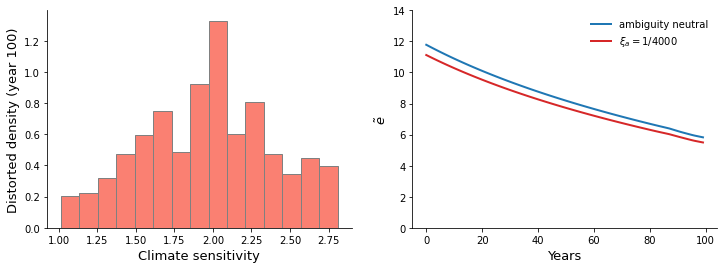

In [28]:
# plot 3
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
ax1.hist(θ_list*1000, weights=πt_avg[-1], density=True, bins=15, color="salmon", ec="grey")
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 100)', fontsize=13)


ax2.plot(et_neutral, color='C0', label='ambiguity neutral', linewidth=2.)
ax2.plot(et_avg, color='C3', label=r'$\xi_a = 1/4000$', linewidth=2.)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel(r'$\tilde{e}$', fontsize=13)
ax2.legend(frameon=False, loc='upper right')
ax2.set_ylim(0, 14)
# plt.savefig("../figures/hist_ems.pdf")

Text(0, 0.5, 'Distorted density (year 90)')

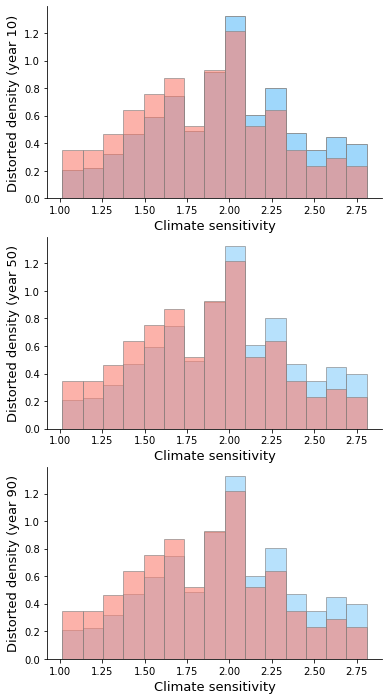

In [30]:
# histogram 10, 50, 90
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(6,12))
ax1.hist(θ_list*1000, weights=πt_avg[10]*np.exp(-10*δ), density=True, bins=15, color='lightskyblue', ec="grey", alpha=0.8)
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 10)', fontsize=13)

ax1.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 10)', fontsize=13)


ax2.hist(θ_list*1000, weights=πt_avg[50]*np.exp(-50*δ), density=True, bins=15, color="lightskyblue", ec="grey", alpha=0.6)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Distorted density (year 50)', fontsize=13)

ax2.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Distorted density (year 50)', fontsize=13)


ax3.hist(θ_list*1000, weights=πt_avg[90]*np.exp(-90*δ), density=True, bins=15, color="lightskyblue", ec="grey", alpha=0.6)
ax3.set_xlabel('Climate sensitivity', fontsize=13)
ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

ax3.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
ax3.set_xlabel('Climate sensitivity', fontsize=13)
ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

# Case 2: bring h back in

$$
\begin{aligned}
0 = \max_{\tilde e} \min_h \min_{\pi^c} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& + \sum \pi^c_i \left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_i \\
& + \left[ \frac{d\phi}{dy} + (\eta - 1 )(\gamma_1 + \gamma_2 y)\right]\tilde e \sigma_y h\\
& + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}(\eta-1)(\gamma_2 + \gamma_3\mathcal{I}\{y>\bar y\}) (\tilde e)^2 |\sigma_y|^2\\
& + \frac{\xi_m}{2}h'h + \xi_a \sum \pi^c_i (\log \pi^c_i - \log \hat\pi^c_i)
\end{aligned}
$$

Minimize over $h$:
$$
h^* = - \cfrac{\frac{d\phi}{dy} + (\eta - 1 )(\gamma_1 + \gamma_2 y)}{\xi_m}\cdot\tilde e \sigma_y
$$

Plug back in:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^c} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& + \sum \pi^c_i \left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_i \\
& + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}(\eta-1)(\gamma_2 + \gamma_3\mathcal{I}\{y>\bar y\}) (\tilde e)^2 |\sigma_y|^2\\
& - \frac{1}{2\xi_m}\left[ \frac{d\phi}{dy} + (\eta - 1 )(\gamma_1 + \gamma_2 y)\right]^2 (\tilde e)^2 |\sigma_y|^2\\
&  + \xi_a \sum \pi^c_i (\log \pi^c_i - \log \hat\pi^c_i)
\end{aligned}
$$

Optimald distribution:
$$
\pi^c_j \propto \hat\pi^c_j \exp\left( -\frac{1}{\xi_a}\left[\frac{d\phi}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y) \right]\tilde e \theta_j \right)
$$


First order condition for $\tilde e^*$:

$$
  \left[- \frac{1}{\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2\phi(y)}{dy^2} + (\eta-1)(\gamma_2 + \gamma_3\mathcal{I}\{y>\bar y\}) \right] \cdot|\sigma_y|^2(\tilde e)^2 + \sum_j \pi^c_j \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j \tilde e + \delta\eta = 0
$$

$$
A =  \left[- \frac{1}{\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2  + \frac{d^2\phi(y)}{dy^2}+ (\eta-1)(\gamma_2 + \gamma_3\mathcal{I}\{y>\bar y\}) \right] \cdot|\sigma_y|^2
$$

$$
B = \sum_j \pi_j^c \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j
$$

$$
C = \delta\eta
$$
And
$$
\tilde e^* = \frac{-B -  \sqrt{B^2 - 4AC}}{2A}
$$
Here we set $\xi_a = 1000$, so there is no ambiguity.

In [34]:
def solve_smooth_robust(y_grid, args, tol=1e-8, ϵ=0.3, max_iter=10_000):
    δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξₘ = args
    dy = y_grid[1] - y_grid[0]
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)*(y_grid>ȳ)
    ddΛ = γ2 + γ3*(y_grid > ȳ)
    ϕ = - δ*η*y_grid**2
    ems = δ*η
    ems_old = ems
    πo = np.ones((len(θ_list), n_y))/len(θ_list)
    lhs_error = 1
    episode = 0
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy)
        dϕdyy = derivative_1d(ϕ, 2, dy)
        temp = dϕdy + (η-1)*dΛ
        # update belief
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
        a = (dϕdyy - temp**2/ξₘ + (η-1)*ddΛ)*σy**2
        b = (θ_list@π)*temp
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*1. + ems_old*0.
        # solve for ode
        A = - δ*np.ones(y_grid.shape)
        B = (θ_list@π)*ems
        C = ems**2*σy**2/2
        D = δ*η*np.log(ems) + (θ_list@π)*(η-1)*dΛ*ems \
        + ξₐ*np.sum(π*(np.log(π) - np.log(πo)), axis=0)\
        - temp**2*ems**2*σy**2/(2*ξₘ)\
        + 1/2*(η-1)*ddΛ*ems**2*σy**2
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems, π

In [46]:
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
ξₐ = 1000
ξₘ = 0.004
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξₘ)
ϕ_rbt_0, ems_rbt_0, π_rbt_0 = solve_smooth_robust(y_grid, args)

episode: 1,	 ode error: 0.001313925633533979,	 ft error: 0.0012773876599120608
episode: 2,	 ode error: 0.0012695072731014542,	 ft error: 0.0012315691607568309
episode: 3,	 ode error: 0.0012273890761529014,	 ft error: 0.0011930291022852985
episode: 4,	 ode error: 0.0011906612098856893,	 ft error: 0.0011595567811477424
episode: 5,	 ode error: 0.0011584971180121349,	 ft error: 0.001130678370812523
episode: 6,	 ode error: 0.0011300646216558755,	 ft error: 0.0011049087060899143
episode: 7,	 ode error: 0.0011046211363175016,	 ft error: 0.0010809962313404144
episode: 8,	 ode error: 0.0010814727307855508,	 ft error: 0.001060056553834855
episode: 9,	 ode error: 0.001060450317824708,	 ft error: 0.0010407602556356946
episode: 10,	 ode error: 0.0010411560258205784,	 ft error: 0.0010228993857284117
episode: 11,	 ode error: 0.0010233113488599902,	 ft error: 0.0010062776823986104
episode: 12,	 ode error: 0.001006705301680669,	 ft error: 0.000990732062952724
episode: 13,	 ode error: 0.0009911714133910

episode: 164,	 ode error: 0.00036816047106124174,	 ft error: 0.0003675532698350683
episode: 165,	 ode error: 0.0003662614308772282,	 ft error: 0.0003656725122174488
episode: 166,	 ode error: 0.0003643739377855202,	 ft error: 0.0003629814036379293
episode: 167,	 ode error: 0.0003624771901727696,	 ft error: 0.0003610824069313438
episode: 168,	 ode error: 0.0003605940881013318,	 ft error: 0.00035920208764853256
episode: 169,	 ode error: 0.00035872334262182514,	 ft error: 0.00035733731189122736
episode: 170,	 ode error: 0.00035686401554267937,	 ft error: 0.0003554859835683613
episode: 171,	 ode error: 0.00035501541200536296,	 ft error: 0.00035364667533391525
episode: 172,	 ode error: 0.00035317701564876287,	 ft error: 0.00035181840157648186
episode: 173,	 ode error: 0.0003513484325641034,	 ft error: 0.0003500004645179874
episode: 174,	 ode error: 0.0003495293627946769,	 ft error: 0.0003481923656244631
episode: 175,	 ode error: 0.0003477195715603184,	 ft error: 0.00034639373811533314
episod

episode: 337,	 ode error: 0.00014876296353254865,	 ft error: 0.0001485376624496317
episode: 338,	 ode error: 0.00014799448084787674,	 ft error: 0.00014777192575816944
episode: 339,	 ode error: 0.00014723019418946403,	 ft error: 0.0001470103547886644
episode: 340,	 ode error: 0.00014647007865211282,	 ft error: 0.00014625292320241678
episode: 341,	 ode error: 0.0001457141111776924,	 ft error: 0.00014549961121557617
episode: 342,	 ode error: 0.0001449622701125224,	 ft error: 0.0001447503948637241
episode: 343,	 ode error: 0.0001442145302129144,	 ft error: 0.00014400525168619302
episode: 344,	 ode error: 0.00014347086892478893,	 ft error: 0.00014326415878800996
episode: 345,	 ode error: 0.00014273126483083695,	 ft error: 0.00014252709472965808
episode: 346,	 ode error: 0.00014199569276737668,	 ft error: 0.00014179403455626127
episode: 347,	 ode error: 0.00014126413341768445,	 ft error: 0.00014106496049800615
episode: 348,	 ode error: 0.00014053656083728018,	 ft error: 0.0001403398464351150

episode: 513,	 ode error: 6.108184742909591e-05,	 ft error: 6.200795883389473e-05
episode: 514,	 ode error: 6.077955617628109e-05,	 ft error: 6.170597135461235e-05
episode: 515,	 ode error: 6.047880944097224e-05,	 ft error: 6.140552689974192e-05
episode: 516,	 ode error: 6.0179598959123884e-05,	 ft error: 6.11066170867064e-05
episode: 517,	 ode error: 5.9881913162512746e-05,	 ft error: 6.0809230627290045e-05
episode: 518,	 ode error: 5.9585746432160784e-05,	 ft error: 6.051336165986225e-05
episode: 519,	 ode error: 5.929108876855018e-05,	 ft error: 6.0219000373752204e-05
episode: 520,	 ode error: 5.899793255863912e-05,	 ft error: 5.992613906544616e-05
episode: 521,	 ode error: 5.870626761508336e-05,	 ft error: 5.963476784357399e-05
episode: 522,	 ode error: 5.841608878051543e-05,	 ft error: 5.9344881068387756e-05
episode: 523,	 ode error: 5.812738469339318e-05,	 ft error: 5.9056467849640436e-05
episode: 524,	 ode error: 5.784014944720036e-05,	 ft error: 5.876952201141576e-05
episode: 5

episode: 687,	 ode error: 2.588508325563493e-05,	 ft error: 2.6848057198154234e-05
episode: 688,	 ode error: 2.575699448622475e-05,	 ft error: 2.6720103950573597e-05
episode: 689,	 ode error: 2.5629506942053217e-05,	 ft error: 2.6592751087110383e-05
episode: 690,	 ode error: 2.550261673909225e-05,	 ft error: 2.646599476597659e-05
episode: 691,	 ode error: 2.5376321727151236e-05,	 ft error: 2.633983289312969e-05
episode: 692,	 ode error: 2.5250619082407507e-05,	 ft error: 2.621426262961376e-05
episode: 693,	 ode error: 2.512550464153112e-05,	 ft error: 2.6089279866678416e-05
episode: 694,	 ode error: 2.500097616989173e-05,	 ft error: 2.5964882098319007e-05
episode: 695,	 ode error: 2.487702983254938e-05,	 ft error: 2.5841065977166844e-05
episode: 696,	 ode error: 2.475366432098426e-05,	 ft error: 2.571782967482339e-05
episode: 697,	 ode error: 2.4630874319776937e-05,	 ft error: 2.559516834319912e-05
episode: 698,	 ode error: 2.450865791843351e-05,	 ft error: 2.547307971107841e-05
episod

episode: 866,	 ode error: 1.035502549090071e-05,	 ft error: 1.1334451943979345e-05
episode: 867,	 ode error: 1.0300311771231098e-05,	 ft error: 1.1279802937270527e-05
episode: 868,	 ode error: 1.02458618991228e-05,	 ft error: 1.1225417444702773e-05
episode: 869,	 ode error: 1.0191673754104047e-05,	 ft error: 1.117129351538293e-05
episode: 870,	 ode error: 1.0137747584321069e-05,	 ft error: 1.1117431401077201e-05
episode: 871,	 ode error: 1.0084080807149214e-05,	 ft error: 1.1063828316467314e-05
episode: 872,	 ode error: 1.0030671797687965e-05,	 ft error: 1.1010482983640307e-05
episode: 873,	 ode error: 9.977520257293507e-06,	 ft error: 1.0957394756723934e-05
episode: 874,	 ode error: 9.924624680377977e-06,	 ft error: 1.0904562267715264e-05
episode: 875,	 ode error: 9.87198391980723e-06,	 ft error: 1.0851984417909837e-05
episode: 876,	 ode error: 9.819596266740513e-06,	 ft error: 1.0799659463494224e-05
episode: 877,	 ode error: 9.767460668313219e-06,	 ft error: 1.0747586341661175e-05
ep

episode: 1040,	 ode error: 4.874792853521261e-06,	 ft error: 4.866533437850966e-06
episode: 1041,	 ode error: 4.862273175939506e-06,	 ft error: 4.842688832903027e-06
episode: 1042,	 ode error: 4.849791351020866e-06,	 ft error: 4.818956767307925e-06
episode: 1043,	 ode error: 4.837346538526222e-06,	 ft error: 4.795337222238127e-06
episode: 1044,	 ode error: 4.824938740709305e-06,	 ft error: 4.771828955978571e-06
episode: 1045,	 ode error: 4.812567968390344e-06,	 ft error: 4.7484315708149856e-06
episode: 1046,	 ode error: 4.80023414918269e-06,	 ft error: 4.725145223311948e-06
episode: 1047,	 ode error: 4.787937095667469e-06,	 ft error: 4.701967868554295e-06
episode: 1048,	 ode error: 4.775676561181422e-06,	 ft error: 4.678900434526567e-06
episode: 1049,	 ode error: 4.763452365424926e-06,	 ft error: 4.655941376330297e-06
episode: 1050,	 ode error: 4.751264876315484e-06,	 ft error: 4.633091715740742e-06
episode: 1051,	 ode error: 4.739113673897738e-06,	 ft error: 4.6103489506621464e-06
epi

episode: 1218,	 ode error: 3.1443157483350935e-06,	 ft error: 2.4503265762717183e-06
episode: 1219,	 ode error: 3.136963525593071e-06,	 ft error: 2.4430030031117695e-06
episode: 1220,	 ode error: 3.1296332332902293e-06,	 ft error: 2.4357010870261026e-06
episode: 1221,	 ode error: 3.1223247246689088e-06,	 ft error: 2.428420733032825e-06
episode: 1222,	 ode error: 3.115038234784357e-06,	 ft error: 2.4211621178424347e-06
episode: 1223,	 ode error: 3.107773485021227e-06,	 ft error: 2.4139250147612685e-06
episode: 1224,	 ode error: 3.1005306163539364e-06,	 ft error: 2.406709380062729e-06
episode: 1225,	 ode error: 3.0933090535584804e-06,	 ft error: 2.399515414986305e-06
episode: 1226,	 ode error: 3.086109138550645e-06,	 ft error: 2.392342474561808e-06
episode: 1227,	 ode error: 3.078930657375654e-06,	 ft error: 2.3851911400719445e-06
episode: 1228,	 ode error: 3.0717740162030174e-06,	 ft error: 2.3780610630801577e-06
episode: 1229,	 ode error: 3.064638585250593e-06,	 ft error: 2.37095202095

episode: 1394,	 ode error: 2.286400086207868e-06,	 ft error: 1.4469460051190024e-06
episode: 1395,	 ode error: 2.2880156208064358e-06,	 ft error: 1.4426242190187142e-06
episode: 1396,	 ode error: 2.2896211409952376e-06,	 ft error: 1.4383155200770974e-06
episode: 1397,	 ode error: 2.2912158353228357e-06,	 ft error: 1.4340196521564486e-06
episode: 1398,	 ode error: 2.2928008599493047e-06,	 ft error: 1.4297364099233323e-06
episode: 1399,	 ode error: 2.2943758232914484e-06,	 ft error: 1.42546598098231e-06
episode: 1400,	 ode error: 2.295940409599833e-06,	 ft error: 1.421207887960611e-06
episode: 1401,	 ode error: 2.2974954889891483e-06,	 ft error: 1.416962797026744e-06
episode: 1402,	 ode error: 2.2990410042191575e-06,	 ft error: 1.4127302808257989e-06
episode: 1403,	 ode error: 2.300576766700211e-06,	 ft error: 1.4085101708698664e-06
episode: 1404,	 ode error: 2.3021031000565744e-06,	 ft error: 1.404302804342931e-06
episode: 1405,	 ode error: 2.3036194848015585e-06,	 ft error: 1.400107667

episode: 1572,	 ode error: 2.4537542734008166e-06,	 ft error: 8.493775225752269e-07
episode: 1573,	 ode error: 2.4541951730517523e-06,	 ft error: 8.468388914874744e-07
episode: 1574,	 ode error: 2.4546321430974575e-06,	 ft error: 8.443076757874701e-07
episode: 1575,	 ode error: 2.4550652441709627e-06,	 ft error: 8.417839716829782e-07
episode: 1576,	 ode error: 2.4554945314013464e-06,	 ft error: 8.392678818580634e-07
episode: 1577,	 ode error: 2.4559204565948443e-06,	 ft error: 8.367591538873306e-07
episode: 1578,	 ode error: 2.456342084034783e-06,	 ft error: 8.34257980348215e-07
episode: 1579,	 ode error: 2.4567591610604226e-06,	 ft error: 8.317639482608812e-07
episode: 1580,	 ode error: 2.4571736698530554e-06,	 ft error: 8.292776388270825e-07
episode: 1581,	 ode error: 2.457583794449557e-06,	 ft error: 8.267985799938667e-07
episode: 1582,	 ode error: 2.457990652880509e-06,	 ft error: 8.243269787600038e-07
episode: 1583,	 ode error: 2.458393959918828e-06,	 ft error: 8.218627429075939e-

episode: 1746,	 ode error: 2.487127487752795e-06,	 ft error: 5.045785454044216e-07
episode: 1747,	 ode error: 2.4871413053142565e-06,	 ft error: 5.030713132297046e-07
episode: 1748,	 ode error: 2.4871535095369692e-06,	 ft error: 5.015685514026906e-07
episode: 1749,	 ode error: 2.4871647250250886e-06,	 ft error: 5.000702074075177e-07
episode: 1750,	 ode error: 2.4871740757417956e-06,	 ft error: 4.985763319096763e-07
episode: 1751,	 ode error: 2.4871828297155785e-06,	 ft error: 4.970868823853114e-07
episode: 1752,	 ode error: 2.4871897980968e-06,	 ft error: 4.95601885664813e-07
episode: 1753,	 ode error: 2.4871954651606233e-06,	 ft error: 4.941212562494431e-07
episode: 1754,	 ode error: 2.487199950066668e-06,	 ft error: 4.926450757984184e-07
episode: 1755,	 ode error: 2.487203160655906e-06,	 ft error: 4.911732489829013e-07
episode: 1756,	 ode error: 2.4872051166369646e-06,	 ft error: 4.897057793764222e-07
episode: 1757,	 ode error: 2.487205985497395e-06,	 ft error: 4.882426813424916e-07


episode: 1926,	 ode error: 2.4748701406122095e-06,	 ft error: 2.9441343985433155e-07
episode: 1927,	 ode error: 2.474750529551082e-06,	 ft error: 2.9353318244801363e-07
episode: 1928,	 ode error: 2.4746311387564683e-06,	 ft error: 2.9265551705394876e-07
episode: 1929,	 ode error: 2.4745109947094676e-06,	 ft error: 2.9178047961560727e-07
episode: 1930,	 ode error: 2.4743906098270664e-06,	 ft error: 2.909080917592085e-07
episode: 1931,	 ode error: 2.4742699916173103e-06,	 ft error: 2.900382495979459e-07
episode: 1932,	 ode error: 2.4741490090171786e-06,	 ft error: 2.89171011175667e-07
episode: 1933,	 ode error: 2.4740278850589304e-06,	 ft error: 2.8830633541411987e-07
episode: 1934,	 ode error: 2.4739065699736743e-06,	 ft error: 2.8744423550876774e-07
episode: 1935,	 ode error: 2.4737850348457925e-06,	 ft error: 2.865846727984067e-07
episode: 1936,	 ode error: 2.4736630999972896e-06,	 ft error: 2.857274635873856e-07
episode: 1937,	 ode error: 2.4735410450206496e-06,	 ft error: 2.84873820

episode: 2085,	 ode error: 2.4539727473198397e-06,	 ft error: 1.829271000184744e-07
episode: 2086,	 ode error: 2.453838130851531e-06,	 ft error: 1.8238055034952572e-07
episode: 2087,	 ode error: 2.453703514550406e-06,	 ft error: 1.8183541236384734e-07
episode: 2088,	 ode error: 2.4535691826595802e-06,	 ft error: 1.8129208411108805e-07
episode: 2089,	 ode error: 2.4534349231544825e-06,	 ft error: 1.8075036697697464e-07
episode: 2090,	 ode error: 2.453300296280923e-06,	 ft error: 1.8021025859071838e-07
episode: 2091,	 ode error: 2.4531662166682217e-06,	 ft error: 1.7967177598730383e-07
episode: 2092,	 ode error: 2.4530318635944165e-06,	 ft error: 1.7913487156591876e-07
episode: 2093,	 ode error: 2.4528977738427988e-06,	 ft error: 1.7859954813681522e-07
episode: 2094,	 ode error: 2.4527635395683867e-06,	 ft error: 1.7806581888389167e-07
episode: 2095,	 ode error: 2.4526294996719627e-06,	 ft error: 1.7753365503386798e-07
episode: 2096,	 ode error: 2.4524954942618414e-06,	 ft error: 1.77003

episode: 2220,	 ode error: 2.4366273267733478e-06,	 ft error: 1.2211962783596303e-07
episode: 2221,	 ode error: 2.436507068964537e-06,	 ft error: 1.217546878364469e-07
episode: 2222,	 ode error: 2.4363872621963522e-06,	 ft error: 1.2139081589461015e-07
episode: 2223,	 ode error: 2.436267390762501e-06,	 ft error: 1.2102802616579628e-07
episode: 2224,	 ode error: 2.436147763292462e-06,	 ft error: 1.2066632318341597e-07
episode: 2225,	 ode error: 2.4360283076133352e-06,	 ft error: 1.2030569272273678e-07
episode: 2226,	 ode error: 2.435908969894592e-06,	 ft error: 1.199461268734196e-07
episode: 2227,	 ode error: 2.4357897800932797e-06,	 ft error: 1.195876255545107e-07
episode: 2228,	 ode error: 2.4356709432331682e-06,	 ft error: 1.192301906510762e-07
episode: 2229,	 ode error: 2.4355519254291467e-06,	 ft error: 1.1887382510058128e-07
episode: 2230,	 ode error: 2.4354329870540474e-06,	 ft error: 1.1851851671370225e-07
episode: 2231,	 ode error: 2.4353144920545903e-06,	 ft error: 1.181642624

episode: 2397,	 ode error: 2.417862990555049e-06,	 ft error: 7.18911846604257e-08
episode: 2398,	 ode error: 2.4177717420928663e-06,	 ft error: 7.167637898717698e-08
episode: 2399,	 ode error: 2.4176805777082855e-06,	 ft error: 7.146218953396621e-08
episode: 2400,	 ode error: 2.4175896923598846e-06,	 ft error: 7.124864908706711e-08
episode: 2401,	 ode error: 2.4174987785967133e-06,	 ft error: 7.103573654067738e-08
episode: 2402,	 ode error: 2.4174080805498756e-06,	 ft error: 7.082346223374891e-08
episode: 2403,	 ode error: 2.4173176090841616e-06,	 ft error: 7.061182356419653e-08
episode: 2404,	 ode error: 2.417227357763693e-06,	 ft error: 7.04008161373874e-08
episode: 2405,	 ode error: 2.4171372899628733e-06,	 ft error: 7.019041878969512e-08
episode: 2406,	 ode error: 2.4170474032366644e-06,	 ft error: 6.998064971258655e-08
episode: 2407,	 ode error: 2.4169576541893862e-06,	 ft error: 6.977151830826293e-08
episode: 2408,	 ode error: 2.416867809241119e-06,	 ft error: 6.956299598848137e-

episode: 2576,	 ode error: 2.404026612082993e-06,	 ft error: 4.206745154768562e-08
episode: 2577,	 ode error: 2.4039625362381567e-06,	 ft error: 4.194174341165535e-08
episode: 2578,	 ode error: 2.4038986657710275e-06,	 ft error: 4.181639880427672e-08
episode: 2579,	 ode error: 2.4038349609513962e-06,	 ft error: 4.169144729680256e-08
episode: 2580,	 ode error: 2.4037713612326973e-06,	 ft error: 4.156685692406163e-08
episode: 2581,	 ode error: 2.403707908782426e-06,	 ft error: 4.14425371913126e-08
episode: 2582,	 ode error: 2.4036446112156397e-06,	 ft error: 4.131868734889392e-08
episode: 2583,	 ode error: 2.403581429904491e-06,	 ft error: 4.1195200618793226e-08
episode: 2584,	 ode error: 2.403518390209716e-06,	 ft error: 4.1072084529710416e-08
episode: 2585,	 ode error: 2.403455385780568e-06,	 ft error: 4.09493312060009e-08
episode: 2586,	 ode error: 2.4033925118500596e-06,	 ft error: 4.082694447562115e-08
episode: 2587,	 ode error: 2.4033298836039917e-06,	 ft error: 4.070493052575157e-

episode: 2755,	 ode error: 2.394547946913772e-06,	 ft error: 2.4614598715759033e-08
episode: 2756,	 ode error: 2.3945051027370523e-06,	 ft error: 2.4541032400682283e-08
episode: 2757,	 ode error: 2.394462361486355e-06,	 ft error: 2.44676845566801e-08
episode: 2758,	 ode error: 2.394419713622816e-06,	 ft error: 2.439455809808792e-08
episode: 2759,	 ode error: 2.394377159611774e-06,	 ft error: 2.432164561185409e-08
episode: 2760,	 ode error: 2.394334722847439e-06,	 ft error: 2.4248953713057464e-08
episode: 2761,	 ode error: 2.394292402429273e-06,	 ft error: 2.4176469171540336e-08
episode: 2762,	 ode error: 2.3942501488581343e-06,	 ft error: 2.4104204939904655e-08
episode: 2763,	 ode error: 2.3942080061637437e-06,	 ft error: 2.4032156901073374e-08
episode: 2764,	 ode error: 2.3941658498789872e-06,	 ft error: 2.396031689028133e-08
episode: 2765,	 ode error: 2.3941238979545768e-06,	 ft error: 2.388868971849497e-08
episode: 2766,	 ode error: 2.394082068133828e-06,	 ft error: 2.38172800232083

episode: 2934,	 ode error: 2.3882973299202653e-06,	 ft error: 1.4401753389385135e-08
episode: 2935,	 ode error: 2.388269516373281e-06,	 ft error: 1.4358701403797507e-08
episode: 2936,	 ode error: 2.3882417715050293e-06,	 ft error: 1.4315770212787923e-08
episode: 2937,	 ode error: 2.3882140953709126e-06,	 ft error: 1.4272974399598404e-08
episode: 2938,	 ode error: 2.3881864749649502e-06,	 ft error: 1.423030612327884e-08
episode: 2939,	 ode error: 2.388158916579418e-06,	 ft error: 1.418776597363521e-08
episode: 2940,	 ode error: 2.3881314447508407e-06,	 ft error: 1.414534918596037e-08
episode: 2941,	 ode error: 2.3881040344488394e-06,	 ft error: 1.4103058188867184e-08
episode: 2942,	 ode error: 2.3880766979104246e-06,	 ft error: 1.4060891513623108e-08
episode: 2943,	 ode error: 2.3880494250650385e-06,	 ft error: 1.4018849911941652e-08
episode: 2944,	 ode error: 2.3880222258479845e-06,	 ft error: 1.3976933198785643e-08
episode: 2945,	 ode error: 2.387995080552045e-06,	 ft error: 1.3935141

In [47]:
yt_rbt_0, et_rbt_0, πt_rbt_0 = simulate_traj(y_grid, ems_rbt_0, π_rbt_0, θ_list)

In [48]:
def compute_h_star(ϕ, ems, y_grid, args):
    η, σy, γ1, γ2, γ3, ȳ, ξₘ = args
    dy = y_grid[1] - y_grid[0]
    dϕdy = derivative_1d(ϕ, 1, dy)
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    h_star = dϕdy + (η-1)*dΛ
    h_star *= ems*σy
    h_star *= - 1/ξₘ
    return h_star

In [49]:
args = (η, σy, γ1, γ2, γ3, ȳ, ξₘ)
h_star_0 = compute_h_star(ϕ_rbt_0, ems_rbt_0, y_grid, args)

(0.0, 0.08696789894267677)

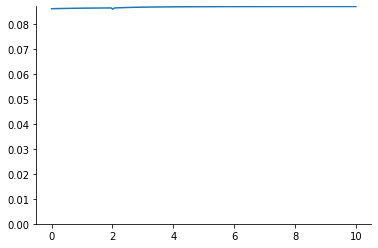

In [50]:
plt.plot(y_grid, h_star_0)
plt.ylim(bottom=0)

In [51]:
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
ξₐ = 1/4000
ξₘ = 0.004
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξₘ)
ϕ_rbt, ems_rbt, π_rbt = solve_smooth_robust(y_grid, args)

episode: 1,	 ode error: 0.0013139256323642086,	 ft error: 0.00127738765172963
episode: 2,	 ode error: 0.0012687523211389457,	 ft error: 0.0012291373414967134
episode: 3,	 ode error: 0.0012253453131376452,	 ft error: 0.001189353703786257
episode: 4,	 ode error: 0.0011875231409244152,	 ft error: 0.001155565610301493
episode: 5,	 ode error: 0.001154548969065086,	 ft error: 0.0011259505797640795
episode: 6,	 ode error: 0.0011254549454070837,	 ft error: 0.0010991646993701847
episode: 7,	 ode error: 0.0010993670437642042,	 ft error: 0.0010756619035267264
episode: 8,	 ode error: 0.0010759018801965166,	 ft error: 0.0010542534239472788
episode: 9,	 ode error: 0.0010545627726764879,	 ft error: 0.0010346231404791953
episode: 10,	 ode error: 0.0010349903077674148,	 ft error: 0.0010165018184010882
episode: 11,	 ode error: 0.001016910947530729,	 ft error: 0.000999672615544254
episode: 12,	 ode error: 0.0010001100012364023,	 ft error: 0.000983960597879239
episode: 13,	 ode error: 0.000984417384688457

episode: 157,	 ode error: 0.00037673566084161754,	 ft error: 0.00037523881165322376
episode: 158,	 ode error: 0.00037478991550329063,	 ft error: 0.00037330604970383746
episode: 159,	 ode error: 0.0003728535496929828,	 ft error: 0.0003713825612305238
episode: 160,	 ode error: 0.0003709264938635189,	 ft error: 0.0003694682779216765
episode: 161,	 ode error: 0.0003690086812074344,	 ft error: 0.00036756313415083297
episode: 162,	 ode error: 0.00036710004754363936,	 ft error: 0.00036566706686764117
episode: 163,	 ode error: 0.00036520053120643625,	 ft error: 0.00036378001549096606
episode: 164,	 ode error: 0.00036331007293688346,	 ft error: 0.0003619019218037307
episode: 165,	 ode error: 0.0003614286157766803,	 ft error: 0.000360032729850845
episode: 166,	 ode error: 0.0003595561049644743,	 ft error: 0.0003581723858385918
episode: 167,	 ode error: 0.0003576924878348044,	 ft error: 0.0003563208380370081
episode: 168,	 ode error: 0.00035583771371958345,	 ft error: 0.00035447803668438305
episo

episode: 325,	 ode error: 0.00015528077144696365,	 ft error: 0.0001550636638841807
episode: 326,	 ode error: 0.0001544691217210142,	 ft error: 0.00015425459673803119
episode: 327,	 ode error: 0.00015366194784409903,	 ft error: 0.00015344997947553768
episode: 328,	 ode error: 0.00015285922493407612,	 ft error: 0.00015264978755343922
episode: 329,	 ode error: 0.00015206092821261276,	 ft error: 0.0001518539965264058
episode: 330,	 ode error: 0.00015126703300578014,	 ft error: 0.00015106258204754716
episode: 331,	 ode error: 0.00015047751474465021,	 ft error: 0.00015027551986931492
episode: 332,	 ode error: 0.00014969234896582324,	 ft error: 0.00014949278584412695
episode: 333,	 ode error: 0.00014891151131194347,	 ft error: 0.00014871435592492266
episode: 334,	 ode error: 0.0001481349775321743,	 ft error: 0.00014794020616574108
episode: 335,	 ode error: 0.00014736272348262705,	 ft error: 0.0001471703127224842
episode: 336,	 ode error: 0.0001465947251267811,	 ft error: 0.0001464046518531251

episode: 500,	 ode error: 6.338591837543582e-05,	 ft error: 6.434468640544959e-05
episode: 501,	 ode error: 6.306732427822058e-05,	 ft error: 6.402636413896379e-05
episode: 502,	 ode error: 6.275037669084093e-05,	 ft error: 6.370968702272088e-05
episode: 503,	 ode error: 6.243506650232481e-05,	 ft error: 6.339464596202826e-05
episode: 504,	 ode error: 6.212138465632204e-05,	 ft error: 6.308123191631673e-05
episode: 505,	 ode error: 6.180932215084367e-05,	 ft error: 6.276943589870096e-05
episode: 506,	 ode error: 6.149887003807685e-05,	 ft error: 6.245924897634962e-05
episode: 507,	 ode error: 6.119001942411285e-05,	 ft error: 6.215066226979149e-05
episode: 508,	 ode error: 6.088276146867669e-05,	 ft error: 6.184366695284604e-05
episode: 509,	 ode error: 6.057708738490262e-05,	 ft error: 6.153825425227652e-05
episode: 510,	 ode error: 6.027298843898734e-05,	 ft error: 6.123441544778989e-05
episode: 511,	 ode error: 5.99704559499435e-05,	 ft error: 6.093214187125051e-05
episode: 512,	 od

episode: 678,	 ode error: 2.5988250760017686e-05,	 ft error: 2.69811877747402e-05
episode: 679,	 ode error: 2.5857953490293238e-05,	 ft error: 2.685101557947193e-05
episode: 680,	 ode error: 2.572828062306757e-05,	 ft error: 2.672146697919875e-05
episode: 681,	 ode error: 2.5599228669627135e-05,	 ft error: 2.659253848571556e-05
episode: 682,	 ode error: 2.54707941638576e-05,	 ft error: 2.6464226633785004e-05
episode: 683,	 ode error: 2.5342973662374822e-05,	 ft error: 2.633652798099869e-05
episode: 684,	 ode error: 2.521576374479124e-05,	 ft error: 2.620943910830916e-05
episode: 685,	 ode error: 2.508916101385606e-05,	 ft error: 2.608295661998365e-05
episode: 686,	 ode error: 2.496316209566569e-05,	 ft error: 2.5957077143812235e-05
episode: 687,	 ode error: 2.483776363985913e-05,	 ft error: 2.583179733147793e-05
episode: 688,	 ode error: 2.47129623197666e-05,	 ft error: 2.5707113858602915e-05
episode: 689,	 ode error: 2.4588754832600155e-05,	 ft error: 2.558302342486422e-05
episode: 69

episode: 855,	 ode error: 1.0336395160496885e-05,	 ft error: 1.1343694144086425e-05
episode: 856,	 ode error: 1.0280425221209145e-05,	 ft error: 1.1287783137498009e-05
episode: 857,	 ode error: 1.0224729051653008e-05,	 ft error: 1.1232145724881145e-05
episode: 858,	 ode error: 1.0169305318868905e-05,	 ft error: 1.117678057297363e-05
episode: 859,	 ode error: 1.0114152694193747e-05,	 ft error: 1.1121686352769111e-05
episode: 860,	 ode error: 1.0059269853324344e-05,	 ft error: 1.1066861739748395e-05
episode: 861,	 ode error: 1.0004655476356333e-05,	 ft error: 1.1012305413601875e-05
episode: 862,	 ode error: 9.950308247840879e-06,	 ft error: 1.095801605871527e-05
episode: 863,	 ode error: 9.896226856828693e-06,	 ft error: 1.0903992363822668e-05
episode: 864,	 ode error: 9.84240999692609e-06,	 ft error: 1.0850233022307218e-05
episode: 865,	 ode error: 9.788856366336291e-06,	 ft error: 1.0796736732270515e-05
episode: 866,	 ode error: 9.735564667887834e-06,	 ft error: 1.074350219616253e-05
e

episode: 1033,	 ode error: 5.314202097973417e-06,	 ft error: 4.673601731522425e-06
episode: 1034,	 ode error: 5.30031956898707e-06,	 ft error: 4.650029077115278e-06
episode: 1035,	 ode error: 5.286478412487377e-06,	 ft error: 4.626569650098555e-06
episode: 1036,	 ode error: 5.272678505951144e-06,	 ft error: 4.60322290764259e-06
episode: 1037,	 ode error: 5.258919727214699e-06,	 ft error: 4.579988309808917e-06
episode: 1038,	 ode error: 5.2452019544738365e-06,	 ft error: 4.5612275277837995e-06
episode: 1039,	 ode error: 5.2315250662830055e-06,	 ft error: 4.547608002473022e-06
episode: 1040,	 ode error: 5.2178889415521105e-06,	 ft error: 4.534028899573032e-06
episode: 1041,	 ode error: 5.204293459548843e-06,	 ft error: 4.520490099989283e-06
episode: 1042,	 ode error: 5.190738499895049e-06,	 ft error: 4.506991484916345e-06
episode: 1043,	 ode error: 5.177223942566349e-06,	 ft error: 4.4935329359073e-06
episode: 1044,	 ode error: 5.163749667891381e-06,	 ft error: 4.480114334885303e-06
epis

episode: 1211,	 ode error: 3.3954105028738846e-06,	 ft error: 2.7183044925063737e-06
episode: 1212,	 ode error: 3.3872563815597403e-06,	 ft error: 2.7101836348394914e-06
episode: 1213,	 ode error: 3.3791266071186922e-06,	 ft error: 2.7020868957038555e-06
episode: 1214,	 ode error: 3.3710211072844913e-06,	 ft error: 2.694014203998933e-06
episode: 1215,	 ode error: 3.362939810004368e-06,	 ft error: 2.6859654887051443e-06
episode: 1216,	 ode error: 3.3548826434376226e-06,	 ft error: 2.6779406791845504e-06
episode: 1217,	 ode error: 3.3468495359553004e-06,	 ft error: 2.6699397049495532e-06
episode: 1218,	 ode error: 3.338840416139432e-06,	 ft error: 2.6619624956050747e-06
episode: 1219,	 ode error: 3.330855212783305e-06,	 ft error: 2.6540089811145457e-06
episode: 1220,	 ode error: 3.322893854888862e-06,	 ft error: 2.646079091533915e-06
episode: 1221,	 ode error: 3.314956271668868e-06,	 ft error: 2.638172757173559e-06
episode: 1222,	 ode error: 3.3070423925437675e-06,	 ft error: 2.630289908

episode: 1388,	 ode error: 2.43408651076746e-06,	 ft error: 1.6006286413771296e-06
episode: 1389,	 ode error: 2.435386758414533e-06,	 ft error: 1.5958439600801308e-06
episode: 1390,	 ode error: 2.4366776995857686e-06,	 ft error: 1.5910734992829099e-06
episode: 1391,	 ode error: 2.4379593839587684e-06,	 ft error: 1.586317216970464e-06
episode: 1392,	 ode error: 2.439231860969953e-06,	 ft error: 1.5815803334577143e-06
episode: 1393,	 ode error: 2.4404951798182484e-06,	 ft error: 1.5768580797816587e-06
episode: 1394,	 ode error: 2.441749389467309e-06,	 ft error: 1.5721498423127793e-06
episode: 1395,	 ode error: 2.4429945386411265e-06,	 ft error: 1.567455579741528e-06
episode: 1396,	 ode error: 2.4442306758314016e-06,	 ft error: 1.5627752508855694e-06
episode: 1397,	 ode error: 2.445457849296732e-06,	 ft error: 1.558108814701346e-06
episode: 1398,	 ode error: 2.446676107058438e-06,	 ft error: 1.5534562301453003e-06
episode: 1399,	 ode error: 2.4478854969108075e-06,	 ft error: 1.54881745650

episode: 1566,	 ode error: 2.556532204590423e-06,	 ft error: 9.3973145576474e-07
episode: 1567,	 ode error: 2.556775754784487e-06,	 ft error: 9.36923901205533e-07
episode: 1568,	 ode error: 2.5570159179452213e-06,	 ft error: 9.34124685797455e-07
episode: 1569,	 ode error: 2.5572527147145344e-06,	 ft error: 9.313337849536918e-07
episode: 1570,	 ode error: 2.5574861656304138e-06,	 ft error: 9.285511741221238e-07
episode: 1571,	 ode error: 2.557716291124541e-06,	 ft error: 9.257768288547149e-07
episode: 1572,	 ode error: 2.5579431115306398e-06,	 ft error: 9.230107247496881e-07
episode: 1573,	 ode error: 2.5581666470718997e-06,	 ft error: 9.202528375671741e-07
episode: 1574,	 ode error: 2.55838691787648e-06,	 ft error: 9.175031429400904e-07
episode: 1575,	 ode error: 2.5586039439673175e-06,	 ft error: 9.147616167789104e-07
episode: 1576,	 ode error: 2.558817745264351e-06,	 ft error: 9.120282349362834e-07
episode: 1577,	 ode error: 2.559028341590265e-06,	 ft error: 9.09302973415201e-07
epis

episode: 1744,	 ode error: 2.561995022107885e-06,	 ft error: 5.516854577799121e-07
episode: 1745,	 ode error: 2.5618814781581977e-06,	 ft error: 5.500379734665883e-07
episode: 1746,	 ode error: 2.561766953085938e-06,	 ft error: 5.48395380148281e-07
episode: 1747,	 ode error: 2.5616514549711765e-06,	 ft error: 5.467576633111371e-07
episode: 1748,	 ode error: 2.561534991844328e-06,	 ft error: 5.45124808591646e-07
episode: 1749,	 ode error: 2.5614175716940106e-06,	 ft error: 5.434968016841217e-07
episode: 1750,	 ode error: 2.56129920246477e-06,	 ft error: 5.418736282828778e-07
episode: 1751,	 ode error: 2.5611798920578384e-06,	 ft error: 5.40255274082228e-07
episode: 1752,	 ode error: 2.561059648328748e-06,	 ft error: 5.386417249962176e-07
episode: 1753,	 ode error: 2.560938479090368e-06,	 ft error: 5.370329667307254e-07
episode: 1754,	 ode error: 2.5608163921125252e-06,	 ft error: 5.354289852113614e-07
episode: 1755,	 ode error: 2.560693395122545e-06,	 ft error: 5.338297663290414e-07
epi

episode: 1922,	 ode error: 2.5322593768397988e-06,	 ft error: 3.2388142169372436e-07
episode: 1923,	 ode error: 2.532064753433378e-06,	 ft error: 3.229134517071519e-07
episode: 1924,	 ode error: 2.531870049806242e-06,	 ft error: 3.2194835793836196e-07
episode: 1925,	 ode error: 2.531675268745658e-06,	 ft error: 3.2098613193346875e-07
episode: 1926,	 ode error: 2.5314804130231175e-06,	 ft error: 3.2002676525015133e-07
episode: 1927,	 ode error: 2.531285485387995e-06,	 ft error: 3.190702494460888e-07
episode: 1928,	 ode error: 2.5310904885747563e-06,	 ft error: 3.1811657612521954e-07
episode: 1929,	 ode error: 2.5308954252995994e-06,	 ft error: 3.1716573684522264e-07
episode: 1930,	 ode error: 2.530700298260236e-06,	 ft error: 3.162177232562957e-07
episode: 1931,	 ode error: 2.5305051101361087e-06,	 ft error: 3.1527252702020136e-07
episode: 1932,	 ode error: 2.5303098635908318e-06,	 ft error: 3.143301398449613e-07
episode: 1933,	 ode error: 2.5301145612667683e-06,	 ft error: 3.1339055339

episode: 2096,	 ode error: 2.4990228904640376e-06,	 ft error: 1.9242642969781917e-07
episode: 2097,	 ode error: 2.498843476168768e-06,	 ft error: 1.9185152530289593e-07
episode: 2098,	 ode error: 2.4986642587462903e-06,	 ft error: 1.9127832853506796e-07
episode: 2099,	 ode error: 2.4984852389032326e-06,	 ft error: 1.9070683434050756e-07
episode: 2100,	 ode error: 2.4983064173378215e-06,	 ft error: 1.9013703774634072e-07
episode: 2101,	 ode error: 2.4981277947434583e-06,	 ft error: 1.8956893368717495e-07
episode: 2102,	 ode error: 2.4979493718053046e-06,	 ft error: 1.8900251720170108e-07
episode: 2103,	 ode error: 2.4977711492001737e-06,	 ft error: 1.8843778334017477e-07
episode: 2104,	 ode error: 2.4975931275998914e-06,	 ft error: 1.878747270372035e-07
episode: 2105,	 ode error: 2.4974153076696157e-06,	 ft error: 1.873133434586912e-07
episode: 2106,	 ode error: 2.4972376900659395e-06,	 ft error: 1.8675362758550457e-07
episode: 2107,	 ode error: 2.4970602754403057e-06,	 ft error: 1.8619

episode: 2266,	 ode error: 2.471719976474744e-06,	 ft error: 1.1569591941891963e-07
episode: 2267,	 ode error: 2.4715796318247802e-06,	 ft error: 1.1535036318482961e-07
episode: 2268,	 ode error: 2.4714395290362516e-06,	 ft error: 1.1500583301654599e-07
episode: 2269,	 ode error: 2.4712996680596646e-06,	 ft error: 1.1466232584939062e-07
episode: 2270,	 ode error: 2.471160048841622e-06,	 ft error: 1.1431983868807431e-07
episode: 2271,	 ode error: 2.471020671329161e-06,	 ft error: 1.1397836852574303e-07
episode: 2272,	 ode error: 2.470881535463843e-06,	 ft error: 1.1363791232084827e-07
episode: 2273,	 ode error: 2.470742641186253e-06,	 ft error: 1.1329846713592495e-07
episode: 2274,	 ode error: 2.4706039884356224e-06,	 ft error: 1.1296002994098941e-07
episode: 2275,	 ode error: 2.4704655771453266e-06,	 ft error: 1.1262259782170622e-07
episode: 2276,	 ode error: 2.470327407250205e-06,	 ft error: 1.1228616778278615e-07
episode: 2277,	 ode error: 2.4701894786823865e-06,	 ft error: 1.1195073

episode: 2406,	 ode error: 2.454371932696e-06,	 ft error: 7.609635463423636e-08
episode: 2407,	 ode error: 2.4542641077024375e-06,	 ft error: 7.586899889583387e-08
episode: 2408,	 ode error: 2.4541565004701765e-06,	 ft error: 7.564231848528058e-08
episode: 2409,	 ode error: 2.4540491107436163e-06,	 ft error: 7.541631142499172e-08
episode: 2410,	 ode error: 2.453941938264663e-06,	 ft error: 7.519097567955843e-08
episode: 2411,	 ode error: 2.4538349827753843e-06,	 ft error: 7.496630930609038e-08
episode: 2412,	 ode error: 2.453728244018608e-06,	 ft error: 7.474231033856768e-08
episode: 2413,	 ode error: 2.453621721733041e-06,	 ft error: 7.451897675314623e-08
episode: 2414,	 ode error: 2.4535154156578786e-06,	 ft error: 7.429630665319506e-08
episode: 2415,	 ode error: 2.4534093255329124e-06,	 ft error: 7.407429804956456e-08
episode: 2416,	 ode error: 2.453303451097771e-06,	 ft error: 7.385294898779964e-08
episode: 2417,	 ode error: 2.453197792089048e-06,	 ft error: 7.36322575365748e-08
ep

episode: 2552,	 ode error: 2.440794435373372e-06,	 ft error: 4.9157739626567075e-08
episode: 2553,	 ode error: 2.4407154391271955e-06,	 ft error: 4.9010799886099285e-08
episode: 2554,	 ode error: 2.4406366187432194e-06,	 ft error: 4.886429683335451e-08
episode: 2555,	 ode error: 2.44055797392383e-06,	 ft error: 4.871822919620221e-08
episode: 2556,	 ode error: 2.440479504369191e-06,	 ft error: 4.857259567938218e-08
episode: 2557,	 ode error: 2.4404012097783826e-06,	 ft error: 4.842739498763423e-08
episode: 2558,	 ode error: 2.44032308985455e-06,	 ft error: 4.8282625860392635e-08
episode: 2559,	 ode error: 2.4402451442972605e-06,	 ft error: 4.8138287025526846e-08
episode: 2560,	 ode error: 2.4401673728087383e-06,	 ft error: 4.799437721090631e-08
episode: 2561,	 ode error: 2.4400897750902857e-06,	 ft error: 4.785089514440048e-08
episode: 2562,	 ode error: 2.440012350842446e-06,	 ft error: 4.7707839577008457e-08
episode: 2563,	 ode error: 2.439935099765383e-06,	 ft error: 4.756520922503486

episode: 2726,	 ode error: 2.4294425462129186e-06,	 ft error: 2.9201590092768164e-08
episode: 2727,	 ode error: 2.429389773102601e-06,	 ft error: 2.911430114355129e-08
episode: 2728,	 ode error: 2.4293371264145396e-06,	 ft error: 2.902727160488302e-08
episode: 2729,	 ode error: 2.4292846058870617e-06,	 ft error: 2.894050071348501e-08
episode: 2730,	 ode error: 2.4292322112607722e-06,	 ft error: 2.8853987740773412e-08
episode: 2731,	 ode error: 2.429179942276113e-06,	 ft error: 2.87677318772106e-08
episode: 2732,	 ode error: 2.4291277986736347e-06,	 ft error: 2.8681732394212716e-08
episode: 2733,	 ode error: 2.4290757801941586e-06,	 ft error: 2.8595988505371782e-08
episode: 2734,	 ode error: 2.429023886577693e-06,	 ft error: 2.8510499470539113e-08
episode: 2735,	 ode error: 2.42897211756674e-06,	 ft error: 2.8425264572695674e-08
episode: 2736,	 ode error: 2.4289204729050482e-06,	 ft error: 2.834028301386867e-08
episode: 2737,	 ode error: 2.4288689523316504e-06,	 ft error: 2.825555405390

episode: 2906,	 ode error: 2.4217460141888556e-06,	 ft error: 1.7037062825335052e-08
episode: 2907,	 ode error: 2.421712140781738e-06,	 ft error: 1.698612494873316e-08
episode: 2908,	 ode error: 2.4216783526897307e-06,	 ft error: 1.6935338513490716e-08
episode: 2909,	 ode error: 2.4216446497157796e-06,	 ft error: 1.6884703057014803e-08
episode: 2910,	 ode error: 2.4216110316658125e-06,	 ft error: 1.683421812827731e-08
episode: 2911,	 ode error: 2.421577498344619e-06,	 ft error: 1.6783883241555664e-08
episode: 2912,	 ode error: 2.4215440495596987e-06,	 ft error: 1.673369803834035e-08
episode: 2913,	 ode error: 2.4215106851149196e-06,	 ft error: 1.6683662032908796e-08
episode: 2914,	 ode error: 2.4214774048185407e-06,	 ft error: 1.663377477423289e-08
episode: 2915,	 ode error: 2.4214442084758933e-06,	 ft error: 1.6584035845979006e-08
episode: 2916,	 ode error: 2.4214110958957783e-06,	 ft error: 1.6534444785554214e-08
episode: 2917,	 ode error: 2.4213780668840153e-06,	 ft error: 1.6485001

episode: 3073,	 ode error: 2.4171337477071377e-06,	 ft error: 1.0333816325795258e-08
episode: 3074,	 ode error: 2.4171116795303703e-06,	 ft error: 1.0302917292463281e-08
episode: 3075,	 ode error: 2.417089668799296e-06,	 ft error: 1.0272110164781061e-08
episode: 3076,	 ode error: 2.4170677153762758e-06,	 ft error: 1.0241394595803904e-08
episode: 3077,	 ode error: 2.417045819122531e-06,	 ft error: 1.0210770342670521e-08
episode: 3078,	 ode error: 2.4170239798974955e-06,	 ft error: 1.0180237150954804e-08
episode: 3079,	 ode error: 2.417002197562391e-06,	 ft error: 1.0149794743100998e-08
episode: 3080,	 ode error: 2.4169804719786567e-06,	 ft error: 1.011944282998852e-08
episode: 3081,	 ode error: 2.4169588030082735e-06,	 ft error: 1.0089181191885732e-08
episode: 3082,	 ode error: 2.416937190513114e-06,	 ft error: 1.0059009493412763e-08
episode: 3083,	 ode error: 2.4169156343556474e-06,	 ft error: 1.002892754953244e-08
episode: 3084,	 ode error: 2.4168941343978003e-06,	 ft error: 9.9989350

In [53]:
yt_rbt, et_rbt, πt_rbt = simulate_traj(y_grid, ems_rbt, π_rbt, θ_list)

(0.0, 14.0)

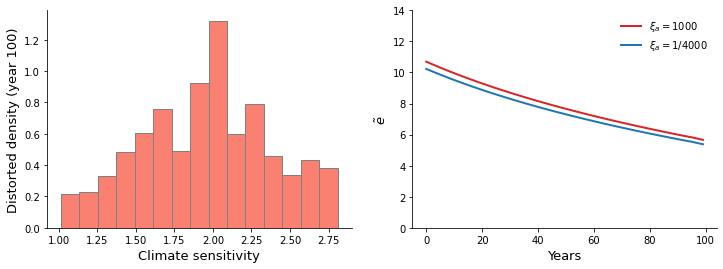

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
ax1.hist(θ_list*1000, weights=πt_rbt[-1], density=True, bins=15, color="salmon", ec="grey")
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 100)', fontsize=13)

ax2.plot(et_rbt_0, color='C3', label=r'$\xi_a = 1000$', linewidth=2.)
ax2.plot(et_rbt, color='C0', label='$\\xi_a = 1/4000$', linewidth=2.)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel(r'$\tilde{e}$', fontsize=13)
ax2.legend(frameon=False, loc='upper right')
ax2.set_ylim(0, 14)

In [42]:
def simulate_traj_robust(y_grid, ems, π_mat, h_star, θ_list,  dt=1, T=100):
    # initiate
    periods = int(T/dt)
    ems_t = np.zeros(periods)
    y_t = np.zeros(periods)
    h_t = np.zeros(periods)
    π_t = np.zeros((periods, len(θ_list)))
    # interpolate
    get_π = interpolate.interp1d(y_grid, π_mat)
    y0 = θ_list.mean()*290
    y = y0
    for t in range(periods):
        ems_point = np.interp(y, y_grid, ems)
        h_point = np.interp(y, y_grid, h_star)
        π_list = get_π(y)
        ems_t[t] = ems_point
        h_t[t] = h_point
        π_t[t] = π_list
        dy = ems_point*(θ_list@π_list)*dt
        y = dy + y
        y_t[t] = y
    return y_t, ems_t, π_t, h_t

In [43]:
yt_rbt, et_rbt, πt_rbt, ht_rbt = simulate_traj_robust(y_grid, ems_rbt, π_rbt, h_star, θ_list)

Text(0, 0.5, 'Distorted density (year 100)')

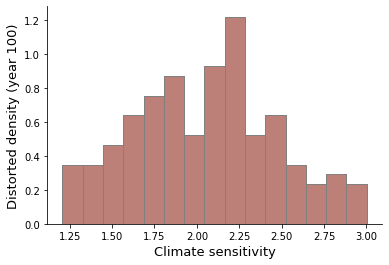

In [44]:
fig, ax1 = plt.subplots(1, 1,figsize=(6,4))
ax1.hist((θ_list + σy*ht_rbt[-1])*1000, weights=πt_rbt[-1], density=True, bins=15, color="salmon", ec="grey")
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 100)', fontsize=13)
ax1.hist((θ_list + σy*ht_rbt[0])*1000,  density=True, bins=15, color="grey", ec="grey", alpha=0.5)
ax1.set_xlabel('Climate sensitivity', fontsize=13)
ax1.set_ylabel('Distorted density (year 100)', fontsize=13)

# Decompose ambiguity among climate models

#1 Partition over temp models

There are 16 temp models

In [682]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θtemp_list = list()
for i in range(n_temp):
    same_temp = θ_list[i*n_carb:i*n_carb+n_carb+1]
    θtemp_list.append(np.average(same_temp))

In [683]:
θtemp_list = np.array(θtemp_list)

In [684]:
ξₐ = 1/4000
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
args = (δ, η, θtemp_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_temp, ems_temp, π_temp = solve_smooth(y_grid, args)

episode: 1,	 ode error: 0.0016905139700299353,	 ft error: 0.0014429450445923454
episode: 2,	 ode error: 0.0014382102196991231,	 ft error: 0.0013062670314649347
episode: 3,	 ode error: 0.0013263740066758697,	 ft error: 0.0012381961558406527
episode: 4,	 ode error: 0.0012594120568700236,	 ft error: 0.001192680059854614
episode: 5,	 ode error: 0.0012099253851628826,	 ft error: 0.0011571374664771682
episode: 6,	 ode error: 0.0011697476756294806,	 ft error: 0.0011275457808082887
episode: 7,	 ode error: 0.0011357373093904043,	 ft error: 0.001100779670008078
episode: 8,	 ode error: 0.0011063001031302597,	 ft error: 0.0010768098291483378
episode: 9,	 ode error: 0.0010804324385910568,	 ft error: 0.0010557730890967728
episode: 10,	 ode error: 0.0010574261038513162,	 ft error: 0.001035859295955745
episode: 11,	 ode error: 0.0010367357667791996,	 ft error: 0.0010176160346474041
episode: 12,	 ode error: 0.0010179427842418433,	 ft error: 0.001000790544670238
episode: 13,	 ode error: 0.00100072137881

episode: 122,	 ode error: 0.0004607846733384191,	 ft error: 0.0004601308304624102
episode: 123,	 ode error: 0.00045844085894299557,	 ft error: 0.0004577947992324393
episode: 124,	 ode error: 0.0004561119176063413,	 ft error: 0.0004554734030281944
episode: 125,	 ode error: 0.0004537975605973843,	 ft error: 0.00045316635817851025
episode: 126,	 ode error: 0.0004514975056551896,	 ft error: 0.00045087338754066836
episode: 127,	 ode error: 0.00044921147701857734,	 ft error: 0.000448594220529124
episode: 128,	 ode error: 0.00044693920545579835,	 ft error: 0.00044632859314300743
episode: 129,	 ode error: 0.00044468042829331176,	 ft error: 0.0004440762479920637
episode: 130,	 ode error: 0.0004424348894425548,	 ft error: 0.0004418369343198748
episode: 131,	 ode error: 0.00044020233942383463,	 ft error: 0.0004396104080232657
episode: 132,	 ode error: 0.0004379825353865431,	 ft error: 0.00043739643166761566
episode: 133,	 ode error: 0.00043577524112479917,	 ft error: 0.0004351947744969317
episode

episode: 286,	 ode error: 0.00019629538436312377,	 ft error: 0.00019608690234410958
episode: 287,	 ode error: 0.00019526399871979175,	 ft error: 0.00019505754520379726
episode: 288,	 ode error: 0.00019423833336553646,	 ft error: 0.0001940338996902352
episode: 289,	 ode error: 0.00019321835922489667,	 ft error: 0.00019301593665937516
episode: 290,	 ode error: 0.0001922040472242592,	 ft error: 0.00019200362697174844
episode: 291,	 ode error: 0.000191195368296387,	 ft error: 0.00019099694149736965
episode: 292,	 ode error: 0.00019019229338484273,	 ft error: 0.00018999585112017733
episode: 293,	 ode error: 0.00018919479344825779,	 ft error: 0.0001890003267423825
episode: 294,	 ode error: 0.0001882028394645447,	 ft error: 0.00018801033928823874
episode: 295,	 ode error: 0.00018721640243495583,	 ft error: 0.00018702585970815921
episode: 296,	 ode error: 0.00018623545338798501,	 ft error: 0.00018604685898322704
episode: 297,	 ode error: 0.00018525996338329166,	 ft error: 0.0001850733081273463

episode: 451,	 ode error: 8.444957417618631e-05,	 ft error: 8.445802575245132e-05
episode: 452,	 ode error: 8.403149300654177e-05,	 ft error: 8.404066901108546e-05
episode: 453,	 ode error: 8.361560402583054e-05,	 ft error: 8.362549934658181e-05
episode: 454,	 ode error: 8.320189459417595e-05,	 ft error: 8.321250416221115e-05
episode: 455,	 ode error: 8.279035215351697e-05,	 ft error: 8.280167093273802e-05
episode: 456,	 ode error: 8.238096422711586e-05,	 ft error: 8.239298719935526e-05
episode: 457,	 ode error: 8.197371841885636e-05,	 ft error: 8.19864406133991e-05
episode: 458,	 ode error: 8.156860241280656e-05,	 ft error: 8.158201888428437e-05
episode: 459,	 ode error: 8.116560397262507e-05,	 ft error: 8.117970979907205e-05
episode: 460,	 ode error: 8.076471094105731e-05,	 ft error: 8.07795012270259e-05
episode: 461,	 ode error: 8.036591123925007e-05,	 ft error: 8.038138113578008e-05
episode: 462,	 ode error: 7.996919286633124e-05,	 ft error: 7.99853375453343e-05
episode: 463,	 ode 

episode: 616,	 ode error: 3.780802045176405e-05,	 ft error: 3.788415145355532e-05
episode: 617,	 ode error: 3.7626903473308776e-05,	 ft error: 3.770320149971511e-05
episode: 618,	 ode error: 3.744667494190912e-05,	 ft error: 3.752313765178576e-05
episode: 619,	 ode error: 3.726733024108275e-05,	 ft error: 3.7343955306481935e-05
episode: 620,	 ode error: 3.708886478066874e-05,	 ft error: 3.7165649864820405e-05
episode: 621,	 ode error: 3.691127399659986e-05,	 ft error: 3.6988216773730285e-05
episode: 622,	 ode error: 3.6734553350783235e-05,	 ft error: 3.6811651499199516e-05
episode: 623,	 ode error: 3.655869833086537e-05,	 ft error: 3.6635949533121256e-05
episode: 624,	 ode error: 3.638370445013285e-05,	 ft error: 3.646110640120419e-05
episode: 625,	 ode error: 3.6209567247330425e-05,	 ft error: 3.6287117642086475e-05
episode: 626,	 ode error: 3.6036282286483283e-05,	 ft error: 3.611397882537689e-05
episode: 627,	 ode error: 3.586384515678312e-05,	 ft error: 3.5941685531971454e-05
episo

episode: 781,	 ode error: 1.7198531196267373e-05,	 ft error: 1.7271701391943783e-05
episode: 782,	 ode error: 1.7116828113446594e-05,	 ft error: 1.7189780045269908e-05
episode: 783,	 ode error: 1.7035512587369457e-05,	 ft error: 1.7108243391359784e-05
episode: 784,	 ode error: 1.6954582735017915e-05,	 ft error: 1.7027089512580695e-05
episode: 785,	 ode error: 1.6874036683163832e-05,	 ft error: 1.6946316531452992e-05
episode: 786,	 ode error: 1.6793872568283226e-05,	 ft error: 1.6865922570543278e-05
episode: 787,	 ode error: 1.6714088536560275e-05,	 ft error: 1.6785905760259106e-05
episode: 788,	 ode error: 1.6634682743815656e-05,	 ft error: 1.6706264230267887e-05
episode: 789,	 ode error: 1.6555653355406473e-05,	 ft error: 1.6626996140698774e-05
episode: 790,	 ode error: 1.6476998546224408e-05,	 ft error: 1.654809964747132e-05
episode: 791,	 ode error: 1.6398716500652796e-05,	 ft error: 1.6469572913467106e-05
episode: 792,	 ode error: 1.632080541243326e-05,	 ft error: 1.639141412781986

episode: 943,	 ode error: 7.937203990768574e-06,	 ft error: 7.915902366512073e-06
episode: 944,	 ode error: 7.89929649509444e-06,	 ft error: 7.87677453315446e-06
episode: 945,	 ode error: 7.861569479695346e-06,	 ft error: 7.837812878534283e-06
episode: 946,	 ode error: 7.824022137324009e-06,	 ft error: 7.799016371624428e-06
episode: 947,	 ode error: 7.786653665327239e-06,	 ft error: 7.760383981467167e-06
episode: 948,	 ode error: 7.749463265643007e-06,	 ft error: 7.721914666603918e-06
episode: 949,	 ode error: 7.712450144810854e-06,	 ft error: 7.683607392954447e-06
episode: 950,	 ode error: 7.67561351403467e-06,	 ft error: 7.645461084712646e-06
episode: 951,	 ode error: 7.63895258903578e-06,	 ft error: 7.607474721629814e-06
episode: 952,	 ode error: 7.6024665902005035e-06,	 ft error: 7.569647225216802e-06
episode: 953,	 ode error: 7.566154742407339e-06,	 ft error: 7.531977575941928e-06
episode: 954,	 ode error: 7.530016275149689e-06,	 ft error: 7.4944647085462e-06
episode: 955,	 ode er

episode: 1104,	 ode error: 5.189749966527256e-06,	 ft error: 3.716816298256672e-06
episode: 1105,	 ode error: 5.167346821877139e-06,	 ft error: 3.6985518627139875e-06
episode: 1106,	 ode error: 5.145501375005605e-06,	 ft error: 3.6803850216500975e-06
episode: 1107,	 ode error: 5.124212417457607e-06,	 ft error: 3.662310750588797e-06
episode: 1108,	 ode error: 5.103475316293007e-06,	 ft error: 3.6443259774273282e-06
episode: 1109,	 ode error: 5.083282742351794e-06,	 ft error: 3.6264286434883886e-06
episode: 1110,	 ode error: 5.063625190497275e-06,	 ft error: 3.608617270186206e-06
episode: 1111,	 ode error: 5.044491398067258e-06,	 ft error: 3.5908907351315617e-06
episode: 1112,	 ode error: 5.025868697746902e-06,	 ft error: 3.5732481374478597e-06
episode: 1113,	 ode error: 5.007743320523529e-06,	 ft error: 3.555688727942726e-06
episode: 1114,	 ode error: 4.990100656963685e-06,	 ft error: 3.538211859263618e-06
episode: 1115,	 ode error: 4.972925482803518e-06,	 ft error: 3.5208169608484203e-

episode: 1258,	 ode error: 3.879854458017722e-06,	 ft error: 2.059098535266609e-06
episode: 1259,	 ode error: 3.875246938548629e-06,	 ft error: 2.0529390313874427e-06
episode: 1260,	 ode error: 3.870663634798104e-06,	 ft error: 2.046797824342232e-06
episode: 1261,	 ode error: 3.8661044300130785e-06,	 ft error: 2.0406748624477817e-06
episode: 1262,	 ode error: 3.861569208082492e-06,	 ft error: 2.034570090805876e-06
episode: 1263,	 ode error: 3.857057853407409e-06,	 ft error: 2.0284834580340067e-06
episode: 1264,	 ode error: 3.852570251020385e-06,	 ft error: 2.0224149106217357e-06
episode: 1265,	 ode error: 3.848106286508438e-06,	 ft error: 2.016364397868879e-06
episode: 1266,	 ode error: 3.8436658460624874e-06,	 ft error: 2.01033186293433e-06
episode: 1267,	 ode error: 3.8392488162845265e-06,	 ft error: 2.0043172588302127e-06
episode: 1268,	 ode error: 3.834855084498573e-06,	 ft error: 1.998320527096346e-06
episode: 1269,	 ode error: 3.830484538334337e-06,	 ft error: 1.9923416190216945e

episode: 1404,	 ode error: 3.3780768136866036e-06,	 ft error: 1.331561837273713e-06
episode: 1405,	 ode error: 3.377260327264999e-06,	 ft error: 1.327580104598658e-06
episode: 1406,	 ode error: 3.3764514875628065e-06,	 ft error: 1.3236120545550198e-06
episode: 1407,	 ode error: 3.371181366472627e-06,	 ft error: 1.980806821807087e-06
episode: 1408,	 ode error: 3.3391790832163447e-06,	 ft error: 1.3179343842650848e-06
episode: 1409,	 ode error: 3.339594754892786e-06,	 ft error: 1.3139919296153066e-06
episode: 1410,	 ode error: 3.3399990927105165e-06,	 ft error: 1.310065521944089e-06
episode: 1411,	 ode error: 3.3360039214868297e-06,	 ft error: 1.94130114636315e-06
episode: 1412,	 ode error: 3.3057722994981123e-06,	 ft error: 1.3044335580904751e-06
episode: 1413,	 ode error: 3.3072981955487393e-06,	 ft error: 1.300533736756556e-06
episode: 1414,	 ode error: 3.3044262426808343e-06,	 ft error: 1.9213336248380397e-06
episode: 1415,	 ode error: 3.2754385928354017e-06,	 ft error: 1.29495161452

episode: 1569,	 ode error: 2.4514813206163327e-06,	 ft error: 9.105416927853346e-07
episode: 1570,	 ode error: 2.4478414924142006e-06,	 ft error: 9.103270892883246e-07
episode: 1571,	 ode error: 2.444184229102018e-06,	 ft error: 9.101522530780004e-07
episode: 1572,	 ode error: 2.440509556600782e-06,	 ft error: 9.100171335929552e-07
episode: 1573,	 ode error: 2.4368174875674686e-06,	 ft error: 9.099215991329828e-07
episode: 1574,	 ode error: 2.4331080226141642e-06,	 ft error: 9.098659738369468e-07
episode: 1575,	 ode error: 2.42938113956205e-06,	 ft error: 9.098502933476323e-07
episode: 1576,	 ode error: 2.42563680249373e-06,	 ft error: 9.098745936547692e-07
episode: 1577,	 ode error: 2.421874962289371e-06,	 ft error: 9.099389717178349e-07
episode: 1578,	 ode error: 2.4180955554445414e-06,	 ft error: 9.100435864143701e-07
episode: 1579,	 ode error: 2.4142985030654266e-06,	 ft error: 9.101886085336834e-07
episode: 1580,	 ode error: 2.410483712329142e-06,	 ft error: 9.103739627193871e-07


episode: 1735,	 ode error: 2.3947727605051804e-06,	 ft error: 5.175240013153652e-07
episode: 1736,	 ode error: 2.3944415423187305e-06,	 ft error: 5.177757262178617e-07
episode: 1737,	 ode error: 2.394096315452485e-06,	 ft error: 5.179808556845152e-07
episode: 1738,	 ode error: 2.393737510125618e-06,	 ft error: 5.18143391444829e-07
episode: 1739,	 ode error: 2.3933655485619087e-06,	 ft error: 5.18258125141909e-07
episode: 1740,	 ode error: 2.3929808452658884e-06,	 ft error: 5.183261656919551e-07
episode: 1741,	 ode error: 2.3925838064379123e-06,	 ft error: 5.183486691146915e-07
episode: 1742,	 ode error: 2.392174830497505e-06,	 ft error: 5.183267495883123e-07
episode: 1743,	 ode error: 2.391754308046822e-06,	 ft error: 5.182614998151351e-07
episode: 1744,	 ode error: 2.3913226219161865e-06,	 ft error: 5.181539972550405e-07
episode: 1745,	 ode error: 2.3908801474619747e-06,	 ft error: 5.180052508810262e-07
episode: 1746,	 ode error: 2.390427252226175e-06,	 ft error: 5.178162923215787e-07

episode: 1901,	 ode error: 2.530153593227754e-06,	 ft error: 3.562244806192457e-07
episode: 1902,	 ode error: 2.5308056420240586e-06,	 ft error: 3.5537138014703673e-07
episode: 1903,	 ode error: 2.5314578214126232e-06,	 ft error: 3.545190339557247e-07
episode: 1904,	 ode error: 2.5321099889504244e-06,	 ft error: 3.5366722614162593e-07
episode: 1905,	 ode error: 2.532761998774865e-06,	 ft error: 3.528157182496513e-07
episode: 1906,	 ode error: 2.533413700901211e-06,	 ft error: 3.519642933352829e-07
episode: 1907,	 ode error: 2.534064942295031e-06,	 ft error: 3.5111274274598114e-07
episode: 1908,	 ode error: 2.5347155672945454e-06,	 ft error: 3.5026085649925154e-07
episode: 1909,	 ode error: 2.535365417579295e-06,	 ft error: 3.494084164825292e-07
episode: 1910,	 ode error: 2.5360143319331867e-06,	 ft error: 3.4855520769418635e-07
episode: 1911,	 ode error: 2.5366621465572337e-06,	 ft error: 3.477010346077577e-07
episode: 1912,	 ode error: 2.53730869586693e-06,	 ft error: 3.46845688547573

episode: 2067,	 ode error: 2.5462137664877186e-06,	 ft error: 1.6843548109509351e-07
episode: 2068,	 ode error: 2.545713602814057e-06,	 ft error: 1.674497885027308e-07
episode: 2069,	 ode error: 2.5452159309346015e-06,	 ft error: 1.664777565223615e-07
episode: 2070,	 ode error: 2.54472104867855e-06,	 ft error: 1.6552267990271874e-07
episode: 2071,	 ode error: 2.5442292493331074e-06,	 ft error: 1.6458102210931136e-07
episode: 2072,	 ode error: 2.543740821630148e-06,	 ft error: 1.6365285851009198e-07
episode: 2073,	 ode error: 2.543256048421485e-06,	 ft error: 1.627382753670766e-07
episode: 2074,	 ode error: 2.542775207493809e-06,	 ft error: 1.6183736573083252e-07
episode: 2075,	 ode error: 2.542298571859365e-06,	 ft error: 1.609501789947195e-07
episode: 2076,	 ode error: 2.5418264079260337e-06,	 ft error: 1.6007673804552258e-07
episode: 2077,	 ode error: 2.541358974823989e-06,	 ft error: 1.5921709492494607e-07
episode: 2078,	 ode error: 2.5408965258177083e-06,	 ft error: 1.5837126606660

episode: 2233,	 ode error: 2.5355099408725843e-06,	 ft error: 1.0308474410886115e-07
episode: 2234,	 ode error: 2.535612142059117e-06,	 ft error: 1.0281946418120673e-07
episode: 2235,	 ode error: 2.5357143207210787e-06,	 ft error: 1.0255511324423298e-07
episode: 2236,	 ode error: 2.535816506218881e-06,	 ft error: 1.0229174244915282e-07
episode: 2237,	 ode error: 2.535918729060509e-06,	 ft error: 1.0202939691034141e-07
episode: 2238,	 ode error: 2.5360210205639016e-06,	 ft error: 1.0176811657269802e-07
episode: 2239,	 ode error: 2.5361234126479166e-06,	 ft error: 1.015079490717293e-07
episode: 2240,	 ode error: 2.5362259381286434e-06,	 ft error: 1.0124893648026194e-07
episode: 2241,	 ode error: 2.5363286304716623e-06,	 ft error: 1.009911249881997e-07
episode: 2242,	 ode error: 2.536431523831727e-06,	 ft error: 1.0073454154158057e-07
episode: 2243,	 ode error: 2.536534652335619e-06,	 ft error: 1.0047923819367366e-07
episode: 2244,	 ode error: 2.5366380511106755e-06,	 ft error: 1.00225251

episode: 2397,	 ode error: 2.5662248736512913e-06,	 ft error: 7.730366958826526e-08
episode: 2398,	 ode error: 2.566455283617517e-06,	 ft error: 7.715267585685823e-08
episode: 2399,	 ode error: 2.5666844738523415e-06,	 ft error: 7.700029159424249e-08
episode: 2400,	 ode error: 2.566912416051366e-06,	 ft error: 7.684653770961836e-08
episode: 2401,	 ode error: 2.567139083474641e-06,	 ft error: 7.669140048710554e-08
episode: 2402,	 ode error: 2.5673644496593934e-06,	 ft error: 7.653491080478192e-08
episode: 2403,	 ode error: 2.5675884900357594e-06,	 ft error: 7.637705136167203e-08
episode: 2404,	 ode error: 2.567811180007528e-06,	 ft error: 7.621784426971775e-08
episode: 2405,	 ode error: 2.5680324963783027e-06,	 ft error: 7.605726783331083e-08
episode: 2406,	 ode error: 2.568252415668113e-06,	 ft error: 7.589534461542129e-08
episode: 2407,	 ode error: 2.5684709158725876e-06,	 ft error: 7.573207174797296e-08
episode: 2408,	 ode error: 2.568687975443209e-06,	 ft error: 7.556746833605374e-0

episode: 2559,	 ode error: 2.5860680779060566e-06,	 ft error: 4.6679826647596144e-08
episode: 2560,	 ode error: 2.586127631431525e-06,	 ft error: 4.65199624076947e-08
episode: 2561,	 ode error: 2.5861869298872105e-06,	 ft error: 4.636064392336363e-08
episode: 2562,	 ode error: 2.5862459728992807e-06,	 ft error: 4.620185396301639e-08
episode: 2563,	 ode error: 2.5863047596074752e-06,	 ft error: 4.604365740531099e-08
episode: 2564,	 ode error: 2.5863632899662033e-06,	 ft error: 4.588621716391147e-08
episode: 2565,	 ode error: 2.5864215626710614e-06,	 ft error: 4.5729281761737926e-08
episode: 2566,	 ode error: 2.5864795762911737e-06,	 ft error: 4.5572869540599914e-08
episode: 2567,	 ode error: 2.5865373302822164e-06,	 ft error: 4.541695834229624e-08
episode: 2568,	 ode error: 2.586594823254676e-06,	 ft error: 4.5261542095294725e-08
episode: 2569,	 ode error: 2.5866520537172325e-06,	 ft error: 4.5106615167526495e-08
episode: 2570,	 ode error: 2.586709020007533e-06,	 ft error: 4.49521571933

episode: 2717,	 ode error: 2.591596976584678e-06,	 ft error: 2.6312673683433672e-08
episode: 2718,	 ode error: 2.5916160779995722e-06,	 ft error: 2.622088013150744e-08
episode: 2719,	 ode error: 2.591635275225575e-06,	 ft error: 2.6129691755213034e-08
episode: 2720,	 ode error: 2.5916545743656064e-06,	 ft error: 2.6039089912055502e-08
episode: 2721,	 ode error: 2.5916739805900636e-06,	 ft error: 2.5949080719826306e-08
episode: 2722,	 ode error: 2.5916934993403407e-06,	 ft error: 2.5859672840577996e-08
episode: 2723,	 ode error: 2.5917131363819537e-06,	 ft error: 2.5770865927365882e-08
episode: 2724,	 ode error: 2.591732897170879e-06,	 ft error: 2.5682629518445726e-08
episode: 2725,	 ode error: 2.591752785934475e-06,	 ft error: 2.5595003743753935e-08
episode: 2726,	 ode error: 2.5917728086556407e-06,	 ft error: 2.5507975419392093e-08
episode: 2727,	 ode error: 2.5917929705447803e-06,	 ft error: 2.5421534761519798e-08
episode: 2728,	 ode error: 2.591813276251007e-06,	 ft error: 2.5335676

episode: 2882,	 ode error: 2.596884141532936e-06,	 ft error: 1.6638728277118542e-08
episode: 2883,	 ode error: 2.5969213865219298e-06,	 ft error: 1.6596278899772e-08
episode: 2884,	 ode error: 2.5969585766363076e-06,	 ft error: 1.655391237281867e-08
episode: 2885,	 ode error: 2.5969957111606043e-06,	 ft error: 1.6511632940548658e-08
episode: 2886,	 ode error: 2.597032789563127e-06,	 ft error: 1.646943265792844e-08
episode: 2887,	 ode error: 2.597069810984158e-06,	 ft error: 1.6427314925016034e-08
episode: 2888,	 ode error: 2.5971067748242955e-06,	 ft error: 1.638528860046599e-08
episode: 2889,	 ode error: 2.5971436808610616e-06,	 ft error: 1.6343343657576614e-08
episode: 2890,	 ode error: 2.5971805284476213e-06,	 ft error: 1.6301484849490233e-08
episode: 2891,	 ode error: 2.5972173171360906e-06,	 ft error: 1.6259704080830627e-08
episode: 2892,	 ode error: 2.5972540462649435e-06,	 ft error: 1.6218022145149856e-08
episode: 2893,	 ode error: 2.5972907161145547e-06,	 ft error: 1.6176429813

episode: 3047,	 ode error: 2.6022296250159823e-06,	 ft error: 1.0785486658874504e-08
episode: 3048,	 ode error: 2.6022557779554426e-06,	 ft error: 1.0754923387053713e-08
episode: 3049,	 ode error: 2.6022818190497453e-06,	 ft error: 1.0724398047852931e-08
episode: 3050,	 ode error: 2.602307748288807e-06,	 ft error: 1.0693900626135289e-08
episode: 3051,	 ode error: 2.6023335650379362e-06,	 ft error: 1.0663408420152898e-08
episode: 3052,	 ode error: 2.6023592678223466e-06,	 ft error: 1.0632952955613728e-08
episode: 3053,	 ode error: 2.602384856647134e-06,	 ft error: 1.06025247609276e-08
episode: 3054,	 ode error: 2.6024103311106557e-06,	 ft error: 1.0572128832098127e-08
episode: 3055,	 ode error: 2.6024356909747125e-06,	 ft error: 1.0541752875718274e-08
episode: 3056,	 ode error: 2.602460935517497e-06,	 ft error: 1.0511409081111664e-08
episode: 3057,	 ode error: 2.602486064534745e-06,	 ft error: 1.0481084923574802e-08
episode: 3058,	 ode error: 2.6025110772292972e-06,	 ft error: 1.0450780

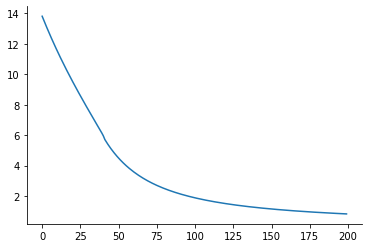

In [685]:
plt.plot(ems_temp)

In [686]:
yt_temp, et_temp, πt_temp = simulate_traj(y_grid, ems_temp, π_temp, θtemp_list)

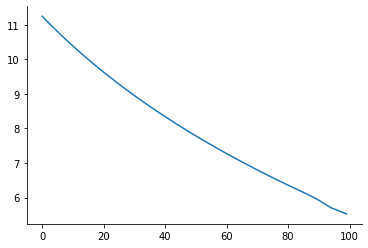

In [687]:
plt.plot(et_temp)

#2 Partition over carbon models

There are 9 carbon models.

In [688]:
θcarb_list = list()
for i in range(n_carb):
    idx_carb = np.arange(i, n_θ+i, n_carb)
    same_carb = θ_list[idx_carb]
    θcarb_list.append(np.average(same_carb))

In [689]:
θcarb_list = np.array(θcarb_list)

In [701]:
ξₐ = 1/4000
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
args = (δ, η, θcarb_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_carb, ems_carb, π_carb = solve_smooth(y_grid, args)

episode: 1,	 ode error: 0.0016934891562814382,	 ft error: 0.0014480394288089702
episode: 2,	 ode error: 0.001446589953996824,	 ft error: 0.0013149026842830312
episode: 3,	 ode error: 0.0013337983489367532,	 ft error: 0.0012463249835247474
episode: 4,	 ode error: 0.0012666252863122371,	 ft error: 0.0012004722275093744
episode: 5,	 ode error: 0.001217271403667099,	 ft error: 0.0011648105473007287
episode: 6,	 ode error: 0.0011772834408547274,	 ft error: 0.0011352290529240154
episode: 7,	 ode error: 0.0011434283855367177,	 ft error: 0.0011084854767994905
episode: 8,	 ode error: 0.0011140939438547787,	 ft error: 0.0010845429700009628
episode: 9,	 ode error: 0.001088283348551581,	 ft error: 0.001063550329484823
episode: 10,	 ode error: 0.001065301449305613,	 ft error: 0.0010436397487707414
episode: 11,	 ode error: 0.0010446135205844597,	 ft error: 0.0010253906762552932
episode: 12,	 ode error: 0.0010258091028447335,	 ft error: 0.0010085523659657822
episode: 13,	 ode error: 0.001008567980806

episode: 127,	 ode error: 0.00045471251488492963,	 ft error: 0.00045407699312819083
episode: 128,	 ode error: 0.00045242328549657666,	 ft error: 0.0004517945061137743
episode: 129,	 ode error: 0.0004501475959630633,	 ft error: 0.0004495253483774442
episode: 130,	 ode error: 0.0004478851906281198,	 ft error: 0.0004472692696125963
episode: 131,	 ode error: 0.00044563582046410583,	 ft error: 0.0004450260261796314
episode: 132,	 ode error: 0.0004433992430896064,	 ft error: 0.0004427953811185608
episode: 133,	 ode error: 0.00044117522278260305,	 ft error: 0.0004405771041568705
episode: 134,	 ode error: 0.000438963530488282,	 ft error: 0.0004383709717111171
episode: 135,	 ode error: 0.00043676394382106455,	 ft error: 0.0004361767668828338
episode: 136,	 ode error: 0.0004345762470602673,	 ft error: 0.0004339942794474745
episode: 137,	 ode error: 0.00043240023113885,	 ft error: 0.00043182330583616446
episode: 138,	 ode error: 0.00043023569362507725,	 ft error: 0.0004296636491101652
episode: 13

episode: 259,	 ode error: 0.0002301094556483175,	 ft error: 0.00022983853099417068
episode: 260,	 ode error: 0.00022890188089217376,	 ft error: 0.00022863323350952777
episode: 261,	 ode error: 0.0002277008226511429,	 ft error: 0.0002274344466909421
episode: 262,	 ode error: 0.0002265062538558206,	 ft error: 0.00022624214329536782
episode: 263,	 ode error: 0.00022531814726960706,	 ft error: 0.00022505629591775916
episode: 264,	 ode error: 0.00022413647549673443,	 ft error: 0.00022387687699856423
episode: 265,	 ode error: 0.00022296121099017274,	 ft error: 0.0002227038588318899
episode: 266,	 ode error: 0.00022179232605943234,	 ft error: 0.00022153721357329645
episode: 267,	 ode error: 0.00022062979287822983,	 ft error: 0.00022037691324703718
episode: 268,	 ode error: 0.00021947358349197867,	 ft error: 0.00021922292975417684
episode: 269,	 ode error: 0.00021832366982522358,	 ft error: 0.00021807523487883673
episode: 270,	 ode error: 0.0002171800236888911,	 ft error: 0.0002169338002968683

episode: 391,	 ode error: 0.00011657338032598557,	 ft error: 0.00011652791411037126
episode: 392,	 ode error: 0.00011598971650329673,	 ft error: 0.00011594537708212635
episode: 393,	 ode error: 0.00011540919724264216,	 ft error: 0.0001153659772734859
episode: 394,	 ode error: 0.00011483180386993592,	 ft error: 0.00011478969604937958
episode: 395,	 ode error: 0.00011425751782715441,	 ft error: 0.00011421651489720852
episode: 396,	 ode error: 0.00011368632067188054,	 ft error: 0.00011364641541428597
episode: 397,	 ode error: 0.00011311819407680318,	 ft error: 0.00011307937931653393
episode: 398,	 ode error: 0.00011255311982920758,	 ft error: 0.00011251538843374173
episode: 399,	 ode error: 0.00011199107983048248,	 ft error: 0.00011195442471005161
episode: 400,	 ode error: 0.0001114320560956487,	 ft error: 0.00011139647020074381
episode: 401,	 ode error: 0.00011087603075279992,	 ft error: 0.00011084150707586782
episode: 402,	 ode error: 0.00011032298604258715,	 ft error: 0.000110289517619

episode: 523,	 ode error: 6.0952875927953076e-05,	 ft error: 6.100671862324658e-05
episode: 524,	 ode error: 6.065962670995717e-05,	 ft error: 6.071393259032831e-05
episode: 525,	 ode error: 6.0367853287261785e-05,	 ft error: 6.042261908751716e-05
episode: 526,	 ode error: 6.007754760730007e-05,	 ft error: 6.013277008489378e-05
episode: 527,	 ode error: 5.978870166675049e-05,	 ft error: 5.984437759259942e-05
episode: 528,	 ode error: 5.950130751118351e-05,	 ft error: 5.955743367728102e-05
episode: 529,	 ode error: 5.921535723472395e-05,	 ft error: 5.927193044911554e-05
episode: 530,	 ode error: 5.8930842979719564e-05,	 ft error: 5.898786006673651e-05
episode: 531,	 ode error: 5.864775693639008e-05,	 ft error: 5.870521473371841e-05
episode: 532,	 ode error: 5.8366091342525574e-05,	 ft error: 5.842398671000264e-05
episode: 533,	 ode error: 5.8085838483066653e-05,	 ft error: 5.814416829704831e-05
episode: 534,	 ode error: 5.780699068987972e-05,	 ft error: 5.786575184597391e-05
episode: 53

episode: 654,	 ode error: 3.264441575380299e-05,	 ft error: 3.2736048350689995e-05
episode: 655,	 ode error: 3.249060852824671e-05,	 ft error: 3.258237902735902e-05
episode: 656,	 ode error: 3.233754154434378e-05,	 ft error: 3.242944791835567e-05
episode: 657,	 ode error: 3.218521104524975e-05,	 ft error: 3.2277251258358564e-05
episode: 658,	 ode error: 3.2033613294844376e-05,	 ft error: 3.212578531468224e-05
episode: 659,	 ode error: 3.1882744577698004e-05,	 ft error: 3.197504637104017e-05
episode: 660,	 ode error: 3.173260119884811e-05,	 ft error: 3.182503074102931e-05
episode: 661,	 ode error: 3.158317948374857e-05,	 ft error: 3.167573474909443e-05
episode: 662,	 ode error: 3.143447577814832e-05,	 ft error: 3.152715473857722e-05
episode: 663,	 ode error: 3.128648644793483e-05,	 ft error: 3.137928707030539e-05
episode: 664,	 ode error: 3.11392078789865e-05,	 ft error: 3.123212814667061e-05
episode: 665,	 ode error: 3.099263647708857e-05,	 ft error: 3.1085674367173355e-05
episode: 666

episode: 786,	 ode error: 1.755100266318129e-05,	 ft error: 1.7642297304165666e-05
episode: 787,	 ode error: 1.7468899811837104e-05,	 ft error: 1.7560025013009982e-05
episode: 788,	 ode error: 1.7387181962226755e-05,	 ft error: 1.7478134475233203e-05
episode: 789,	 ode error: 1.7305847260211437e-05,	 ft error: 1.7396623811805994e-05
episode: 790,	 ode error: 1.7224893861252847e-05,	 ft error: 1.731549115200256e-05
episode: 791,	 ode error: 1.714431993039367e-05,	 ft error: 1.7234734623986874e-05
episode: 792,	 ode error: 1.7064123642176153e-05,	 ft error: 1.7154352381550574e-05
episode: 793,	 ode error: 1.6984303180606107e-05,	 ft error: 1.7074342571315092e-05
episode: 794,	 ode error: 1.6904856739085694e-05,	 ft error: 1.6994703354427286e-05
episode: 795,	 ode error: 1.682578252037905e-05,	 ft error: 1.6915432906004318e-05
episode: 796,	 ode error: 1.674707873653065e-05,	 ft error: 1.6836529409883227e-05
episode: 797,	 ode error: 1.6668743608848824e-05,	 ft error: 1.6757991049854797e-

episode: 918,	 ode error: 9.44973424951332e-06,	 ft error: 9.466346512545151e-06
episode: 919,	 ode error: 9.405498681174787e-06,	 ft error: 9.420721093639228e-06
episode: 920,	 ode error: 9.36147119123907e-06,	 ft error: 9.375276941517297e-06
episode: 921,	 ode error: 9.317650883078343e-06,	 ft error: 9.330012442794005e-06
episode: 922,	 ode error: 9.274036866657276e-06,	 ft error: 9.284925937709059e-06
episode: 923,	 ode error: 9.230628258636892e-06,	 ft error: 9.240015720312264e-06
episode: 924,	 ode error: 9.18742418225954e-06,	 ft error: 9.195280123696267e-06
episode: 925,	 ode error: 9.14442376748507e-06,	 ft error: 9.150717428634455e-06
episode: 926,	 ode error: 9.101626151108359e-06,	 ft error: 9.106325863187752e-06
episode: 927,	 ode error: 9.059030476733939e-06,	 ft error: 9.062103665015883e-06
episode: 928,	 ode error: 9.016635894980589e-06,	 ft error: 9.018049001302542e-06
episode: 929,	 ode error: 8.974441563563409e-06,	 ft error: 8.974159993989836e-06
episode: 930,	 ode e

episode: 1048,	 ode error: 5.858503044720378e-06,	 ft error: 5.142503369202449e-06
episode: 1049,	 ode error: 5.843104733452547e-06,	 ft error: 5.118097983550229e-06
episode: 1050,	 ode error: 5.827883620794126e-06,	 ft error: 5.09380440200565e-06
episode: 1051,	 ode error: 5.812832768380409e-06,	 ft error: 5.06962217053375e-06
episode: 1052,	 ode error: 5.797945574413622e-06,	 ft error: 5.045550837366279e-06
episode: 1053,	 ode error: 5.783215762759908e-06,	 ft error: 5.0215899497172796e-06
episode: 1054,	 ode error: 5.76863737172074e-06,	 ft error: 4.99773905056807e-06
episode: 1055,	 ode error: 5.754204742561731e-06,	 ft error: 4.973997689908249e-06
episode: 1056,	 ode error: 5.739912507563157e-06,	 ft error: 4.950365413980418e-06
episode: 1057,	 ode error: 5.7257555783322045e-06,	 ft error: 4.926841771432655e-06
episode: 1058,	 ode error: 5.711729134061057e-06,	 ft error: 4.9034262891943054e-06
episode: 1059,	 ode error: 5.69782861029386e-06,	 ft error: 4.880118538696151e-06
episod

episode: 1179,	 ode error: 4.045947210814063e-06,	 ft error: 3.0320041938490068e-06
episode: 1180,	 ode error: 4.038775254893042e-06,	 ft error: 3.0173785348780457e-06
episode: 1181,	 ode error: 4.031630544849992e-06,	 ft error: 3.0028383276222335e-06
episode: 1182,	 ode error: 4.0245132892606375e-06,	 ft error: 2.9883830691967983e-06
episode: 1183,	 ode error: 4.0174236727501885e-06,	 ft error: 2.9740124853303946e-06
episode: 1184,	 ode error: 4.010361852097694e-06,	 ft error: 2.9597260468629725e-06
episode: 1185,	 ode error: 4.003327964545748e-06,	 ft error: 2.94552338182356e-06
episode: 1186,	 ode error: 3.996322124572222e-06,	 ft error: 2.9314041492811693e-06
episode: 1187,	 ode error: 3.989344424687859e-06,	 ft error: 2.917367954158312e-06
episode: 1188,	 ode error: 3.982394937944412e-06,	 ft error: 2.9034145126079678e-06
episode: 1189,	 ode error: 3.975473716565461e-06,	 ft error: 2.889543420347048e-06
episode: 1190,	 ode error: 3.9685807962539996e-06,	 ft error: 2.87575438732978

episode: 1311,	 ode error: 3.3227738553264375e-06,	 ft error: 1.6528510627759434e-06
episode: 1312,	 ode error: 3.319389105583149e-06,	 ft error: 1.6439866975387352e-06
episode: 1313,	 ode error: 3.3160495736109024e-06,	 ft error: 1.6351196476434757e-06
episode: 1314,	 ode error: 3.3127549588686392e-06,	 ft error: 1.626251360150229e-06
episode: 1315,	 ode error: 3.309504909389965e-06,	 ft error: 1.6173832531144832e-06
episode: 1316,	 ode error: 3.306299024738251e-06,	 ft error: 1.608516804682547e-06
episode: 1317,	 ode error: 3.3031368564076817e-06,	 ft error: 1.599653533292574e-06
episode: 1318,	 ode error: 3.3000179092559185e-06,	 ft error: 1.5907948835991448e-06
episode: 1319,	 ode error: 3.2969416456602807e-06,	 ft error: 1.5819423433705015e-06
episode: 1320,	 ode error: 3.293907486190276e-06,	 ft error: 1.5730974440436585e-06
episode: 1321,	 ode error: 3.2909148109405185e-06,	 ft error: 1.5642615918548541e-06
episode: 1322,	 ode error: 3.287962964772413e-06,	 ft error: 1.555436275

episode: 1443,	 ode error: 3.05125423611123e-06,	 ft error: 1.098758291654308e-06
episode: 1444,	 ode error: 3.0496553979295895e-06,	 ft error: 1.0954739899926569e-06
episode: 1445,	 ode error: 3.04806087849936e-06,	 ft error: 1.0921954884020777e-06
episode: 1446,	 ode error: 3.0464707101284655e-06,	 ft error: 1.0889228810780547e-06
episode: 1447,	 ode error: 3.044884925331587e-06,	 ft error: 1.0856562763020272e-06
episode: 1448,	 ode error: 3.0433035573298713e-06,	 ft error: 1.0823957664769328e-06
episode: 1449,	 ode error: 3.041726639527913e-06,	 ft error: 1.0791414542058824e-06
episode: 1450,	 ode error: 3.040154205908403e-06,	 ft error: 1.0758934332333325e-06
episode: 1451,	 ode error: 3.038586290721396e-06,	 ft error: 1.0726517983330095e-06
episode: 1452,	 ode error: 3.0370229285869854e-06,	 ft error: 1.0694166468922888e-06
episode: 1453,	 ode error: 3.035464154601121e-06,	 ft error: 1.0661880706317832e-06
episode: 1454,	 ode error: 3.0339100041824104e-06,	 ft error: 1.06296616574

episode: 1575,	 ode error: 2.889436991619491e-06,	 ft error: 7.36531903082945e-07
episode: 1576,	 ode error: 2.8886241368420796e-06,	 ft error: 7.343432181436405e-07
episode: 1577,	 ode error: 2.8878166215685723e-06,	 ft error: 7.32161091846854e-07
episode: 1578,	 ode error: 2.8870144015846625e-06,	 ft error: 7.299854861443171e-07
episode: 1579,	 ode error: 2.886217432933216e-06,	 ft error: 7.278163501623729e-07
episode: 1580,	 ode error: 2.8854256714092507e-06,	 ft error: 7.256536375145155e-07
episode: 1581,	 ode error: 2.884639072804531e-06,	 ft error: 7.234973115286907e-07
episode: 1582,	 ode error: 2.883857593194558e-06,	 ft error: 7.213473202094534e-07
episode: 1583,	 ode error: 2.8830811883885513e-06,	 ft error: 7.192036236697286e-07
episode: 1584,	 ode error: 2.882309814416801e-06,	 ft error: 7.170661838959425e-07
episode: 1585,	 ode error: 2.8815434275664435e-06,	 ft error: 7.149349577050453e-07
episode: 1586,	 ode error: 2.880781984163864e-06,	 ft error: 7.128099022493672e-07


episode: 1707,	 ode error: 2.8158997422349057e-06,	 ft error: 4.955197892055526e-07
episode: 1708,	 ode error: 2.8155477155143065e-06,	 ft error: 4.94035380394405e-07
episode: 1709,	 ode error: 2.815198422712159e-06,	 ft error: 4.925557867824226e-07
episode: 1710,	 ode error: 2.8148518590482164e-06,	 ft error: 4.910809935550672e-07
episode: 1711,	 ode error: 2.814508019477794e-06,	 ft error: 4.89610992767305e-07
episode: 1712,	 ode error: 2.81416689892856e-06,	 ft error: 4.881457681243003e-07
episode: 1713,	 ode error: 2.8138284920063922e-06,	 ft error: 4.866853093911846e-07
episode: 1714,	 ode error: 2.813492793237696e-06,	 ft error: 4.852296029561609e-07
episode: 1715,	 ode error: 2.813159796953937e-06,	 ft error: 4.837786385496664e-07
episode: 1716,	 ode error: 2.8128294974047235e-06,	 ft error: 4.823324004551063e-07
episode: 1717,	 ode error: 2.8125018885586392e-06,	 ft error: 4.808908744824425e-07
episode: 1718,	 ode error: 2.8121769641761005e-06,	 ft error: 4.794540466960633e-07


episode: 1839,	 ode error: 2.789403825177619e-06,	 ft error: 3.352349795214075e-07
episode: 1840,	 ode error: 2.7893200550528846e-06,	 ft error: 3.342482294763083e-07
episode: 1841,	 ode error: 2.7892374913542767e-06,	 ft error: 3.3326427402446956e-07
episode: 1842,	 ode error: 2.78915612416926e-06,	 ft error: 3.3228310867874e-07
episode: 1843,	 ode error: 2.7890759438676258e-06,	 ft error: 3.3130472447638154e-07
episode: 1844,	 ode error: 2.7889969408871444e-06,	 ft error: 3.303291080137642e-07
episode: 1845,	 ode error: 2.78891910559327e-06,	 ft error: 3.2935625474591246e-07
episode: 1846,	 ode error: 2.788842428605269e-06,	 ft error: 3.283861526685398e-07
episode: 1847,	 ode error: 2.788766900541106e-06,	 ft error: 3.274187999775339e-07
episode: 1848,	 ode error: 2.7886925123344654e-06,	 ft error: 3.264541794297434e-07
episode: 1849,	 ode error: 2.7886192546992643e-06,	 ft error: 3.254922907013532e-07
episode: 1850,	 ode error: 2.7885471187550194e-06,	 ft error: 3.245331216261693e-0

episode: 1971,	 ode error: 2.786132461317912e-06,	 ft error: 2.2666308088549933e-07
episode: 1972,	 ode error: 2.7861526399041445e-06,	 ft error: 2.2598974703154825e-07
episode: 1973,	 ode error: 2.786173317652829e-06,	 ft error: 2.2531882406158962e-07
episode: 1974,	 ode error: 2.786194491179411e-06,	 ft error: 2.2465036354316997e-07
episode: 1975,	 ode error: 2.7862161570181305e-06,	 ft error: 2.2398386372487108e-07
episode: 1976,	 ode error: 2.786238311702034e-06,	 ft error: 2.233193171820765e-07
episode: 1977,	 ode error: 2.7862609517158125e-06,	 ft error: 2.2265672076915433e-07
episode: 1978,	 ode error: 2.7862840736705757e-06,	 ft error: 2.2199607073910185e-07
episode: 1979,	 ode error: 2.786307674245629e-06,	 ft error: 2.213373586727278e-07
episode: 1980,	 ode error: 2.786331750009364e-06,	 ft error: 2.206805787991854e-07
episode: 1981,	 ode error: 2.7863562975456767e-06,	 ft error: 2.2002572678166596e-07
episode: 1982,	 ode error: 2.7863813134712057e-06,	 ft error: 2.1937279283

episode: 2103,	 ode error: 2.7919334099231734e-06,	 ft error: 1.5299952566457295e-07
episode: 2104,	 ode error: 2.7919935793726744e-06,	 ft error: 1.5254345572581393e-07
episode: 2105,	 ode error: 2.792053896044579e-06,	 ft error: 1.5208919280224054e-07
episode: 2106,	 ode error: 2.7921143584027893e-06,	 ft error: 1.5163641417746215e-07
episode: 2107,	 ode error: 2.792174964671491e-06,	 ft error: 1.5118496556517277e-07
episode: 2108,	 ode error: 2.7922357133154533e-06,	 ft error: 1.5073483807202342e-07
episode: 2109,	 ode error: 2.7922966026320455e-06,	 ft error: 1.502860343116641e-07
episode: 2110,	 ode error: 2.792357631179604e-06,	 ft error: 1.498385483629054e-07
episode: 2111,	 ode error: 2.792418797428536e-06,	 ft error: 1.4939237602771643e-07
episode: 2112,	 ode error: 2.7924800998133624e-06,	 ft error: 1.489475104944164e-07
episode: 2113,	 ode error: 2.792541536688806e-06,	 ft error: 1.4850395490863719e-07
episode: 2114,	 ode error: 2.7926031066913748e-06,	 ft error: 1.480617020

episode: 2234,	 ode error: 2.800587659735178e-06,	 ft error: 1.034841870412954e-07
episode: 2235,	 ode error: 2.80065655165751e-06,	 ft error: 1.0317596314350179e-07
episode: 2236,	 ode error: 2.8007254452088555e-06,	 ft error: 1.0286865208033089e-07
episode: 2237,	 ode error: 2.800794339624527e-06,	 ft error: 1.0256224678567571e-07
episode: 2238,	 ode error: 2.8008632339929273e-06,	 ft error: 1.0225675022013103e-07
episode: 2239,	 ode error: 2.8009321276339363e-06,	 ft error: 1.0195215716796158e-07
episode: 2240,	 ode error: 2.8010010197673622e-06,	 ft error: 1.0164846589444387e-07
episode: 2241,	 ode error: 2.801069909647491e-06,	 ft error: 1.0134567138044467e-07
episode: 2242,	 ode error: 2.8011387964452326e-06,	 ft error: 1.0104377374161219e-07
episode: 2243,	 ode error: 2.8012076794391595e-06,	 ft error: 1.0074276711458108e-07
episode: 2244,	 ode error: 2.8012765577876053e-06,	 ft error: 1.004426507245082e-07
episode: 2245,	 ode error: 2.801345430744422e-06,	 ft error: 1.001434239

episode: 2364,	 ode error: 2.809323814585707e-06,	 ft error: 7.019827930748734e-08
episode: 2365,	 ode error: 2.809387836372819e-06,	 ft error: 6.998904698851671e-08
episode: 2366,	 ode error: 2.8094517925911786e-06,	 ft error: 6.978043230049247e-08
episode: 2367,	 ode error: 2.8095156829518455e-06,	 ft error: 6.957243407536748e-08
episode: 2368,	 ode error: 2.809579507194503e-06,	 ft error: 6.936504987296403e-08
episode: 2369,	 ode error: 2.8096432650323794e-06,	 ft error: 6.915827764630844e-08
episode: 2370,	 ode error: 2.809706956172957e-06,	 ft error: 6.895211645865004e-08
episode: 2371,	 ode error: 2.8097705803590634e-06,	 ft error: 6.874656367320912e-08
episode: 2372,	 ode error: 2.809834137309998e-06,	 ft error: 6.854161919746712e-08
episode: 2373,	 ode error: 2.8098976268071865e-06,	 ft error: 6.833727875243945e-08
episode: 2374,	 ode error: 2.8099610485506294e-06,	 ft error: 6.813354504429474e-08
episode: 2375,	 ode error: 2.8100244024085964e-06,	 ft error: 6.793041121509284e-

episode: 2495,	 ode error: 2.817077486640487e-06,	 ft error: 4.746312939896136e-08
episode: 2496,	 ode error: 2.817131358111031e-06,	 ft error: 4.732152306582046e-08
episode: 2497,	 ode error: 2.8171851451205994e-06,	 ft error: 4.718033896437361e-08
episode: 2498,	 ode error: 2.8172388477690474e-06,	 ft error: 4.7039568235966264e-08
episode: 2499,	 ode error: 2.817292465842787e-06,	 ft error: 4.689921304322035e-08
episode: 2500,	 ode error: 2.8173459992948723e-06,	 ft error: 4.67592750977297e-08
episode: 2501,	 ode error: 2.8173994481834165e-06,	 ft error: 4.661974803884158e-08
episode: 2502,	 ode error: 2.8174528123719187e-06,	 ft error: 4.648063658500383e-08
episode: 2503,	 ode error: 2.8175060919460307e-06,	 ft error: 4.634193261771058e-08
episode: 2504,	 ode error: 2.817559286725775e-06,	 ft error: 4.6203641167659924e-08
episode: 2505,	 ode error: 2.817612396779673e-06,	 ft error: 4.606575595515287e-08
episode: 2506,	 ode error: 2.8176654219896555e-06,	 ft error: 4.592828256599901e

episode: 2627,	 ode error: 2.8234565736408703e-06,	 ft error: 3.1984732547692594e-08
episode: 2628,	 ode error: 2.823499344382029e-06,	 ft error: 3.1889198203368295e-08
episode: 2629,	 ode error: 2.823542033745033e-06,	 ft error: 3.179394942922261e-08
episode: 2630,	 ode error: 2.8235846419166896e-06,	 ft error: 3.169898117142782e-08
episode: 2631,	 ode error: 2.8236271689011192e-06,	 ft error: 3.160429423952153e-08
episode: 2632,	 ode error: 2.823669614766735e-06,	 ft error: 3.150988638992806e-08
episode: 2633,	 ode error: 2.823711979538907e-06,	 ft error: 3.141575948458394e-08
episode: 2634,	 ode error: 2.8237542633600997e-06,	 ft error: 3.132191195067321e-08
episode: 2635,	 ode error: 2.8237964663244217e-06,	 ft error: 3.122834123236995e-08
episode: 2636,	 ode error: 2.8238385884546413e-06,	 ft error: 3.11350475956651e-08
episode: 2637,	 ode error: 2.8238806298209063e-06,	 ft error: 3.104202967590952e-08
episode: 2638,	 ode error: 2.8239225904688617e-06,	 ft error: 3.094928662887113

episode: 2759,	 ode error: 2.82842951427947e-06,	 ft error: 2.154778868066846e-08
episode: 2760,	 ode error: 2.8284622758099377e-06,	 ft error: 2.1483368810767032e-08
episode: 2761,	 ode error: 2.8284949678075927e-06,	 ft error: 2.1419141483606612e-08
episode: 2762,	 ode error: 2.828527590419995e-06,	 ft error: 2.1355100627655037e-08
episode: 2763,	 ode error: 2.8285601435820923e-06,	 ft error: 2.129125175933296e-08
episode: 2764,	 ode error: 2.8285926274966306e-06,	 ft error: 2.122759202212906e-08
episode: 2765,	 ode error: 2.8286250422631396e-06,	 ft error: 2.116412153169156e-08
episode: 2766,	 ode error: 2.8286573880034836e-06,	 ft error: 2.1100838599556287e-08
episode: 2767,	 ode error: 2.8286896647836905e-06,	 ft error: 2.1037742046111273e-08
episode: 2768,	 ode error: 2.8287218726525494e-06,	 ft error: 2.0974832854366486e-08
episode: 2769,	 ode error: 2.828754011742333e-06,	 ft error: 2.091211238897106e-08
episode: 2770,	 ode error: 2.828786082255028e-06,	 ft error: 2.08495774580

episode: 2891,	 ode error: 2.8321914188767644e-06,	 ft error: 1.4513345166870344e-08
episode: 2892,	 ode error: 2.832215895240734e-06,	 ft error: 1.4469968926770587e-08
episode: 2893,	 ode error: 2.8322403157770735e-06,	 ft error: 1.4426720801781942e-08
episode: 2894,	 ode error: 2.8322646805592922e-06,	 ft error: 1.4383599346301512e-08
episode: 2895,	 ode error: 2.8322889896386727e-06,	 ft error: 1.434060831889683e-08
episode: 2896,	 ode error: 2.8323132432376934e-06,	 ft error: 1.4297744215426475e-08
episode: 2897,	 ode error: 2.8323374414155516e-06,	 ft error: 1.4255004711360986e-08
episode: 2898,	 ode error: 2.8323615841757167e-06,	 ft error: 1.4212394386370342e-08
episode: 2899,	 ode error: 2.8323856717283073e-06,	 ft error: 1.416990863765492e-08
episode: 2900,	 ode error: 2.8324097040955494e-06,	 ft error: 1.4127549165243725e-08
episode: 2901,	 ode error: 2.8324336813947536e-06,	 ft error: 1.4085315113339844e-08
episode: 2902,	 ode error: 2.8324576037296783e-06,	 ft error: 1.4043

In [702]:
yt_carb, et_carb, πt_carb = simulate_traj(y_grid, ems_carb, π_carb, θcarb_list)

(0.0, 13.5)

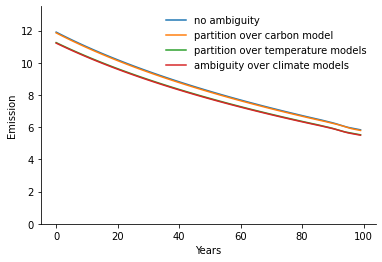

In [703]:
plt.plot(et_neutral, label="no ambiguity")
plt.plot(et_carb, label="partition over carbon model")
plt.plot(et_temp, label="partition over temperature models")
plt.plot(et_avg, label = "ambiguity over climate models")
plt.legend(frameon=False, loc='upper right')
plt.xlabel("Years")
plt.ylabel('Emission')
plt.ylim(0,13.5)
# plt.savefig("../figures/ems_partition.pdf")

In [706]:
ξₐ = 1/10_000
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_avg, ems_avg, π_avg = solve_smooth(y_grid, args, tol=1e-6)
args = (δ, η, θtemp_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_temp, ems_temp, π_temp = solve_smooth(y_grid, args, tol=1e-6)
args = (δ, η, θcarb_list, σy, γ1, γ2, γ3, ȳ, ξₐ)
ϕ_carb, ems_carb, π_carb = solve_smooth(y_grid, args, tol=1e-6)
yt_avg, et_avg, πt_avg = simulate_traj(y_grid, ems_avg, π_avg, θ_list)
yt_temp, et_temp, πt_temp = simulate_traj(y_grid, ems_temp, π_temp, θtemp_list)
yt_carb, et_carb, πt_carb = simulate_traj(y_grid, ems_carb, π_carb, θcarb_list)

episode: 1,	 ode error: 0.0016934891469383843,	 ft error: 0.0014480393752882958
episode: 2,	 ode error: 0.001424571344043859,	 ft error: 0.0012911809460177664
episode: 3,	 ode error: 0.0013182733465200457,	 ft error: 0.0012259957682909043
episode: 4,	 ode error: 0.0012517022445031759,	 ft error: 0.0011819390658632982
episode: 5,	 ode error: 0.0012011983356119006,	 ft error: 0.0011467678203541413
episode: 6,	 ode error: 0.0011599257317909128,	 ft error: 0.0011170014414735063
episode: 7,	 ode error: 0.0011250875846168693,	 ft error: 0.0010899763631497814
episode: 8,	 ode error: 0.0010951120440712103,	 ft error: 0.0010665429523350188
episode: 9,	 ode error: 0.0010689394494998324,	 ft error: 0.0010444849346966621
episode: 10,	 ode error: 0.0010457733793164893,	 ft error: 0.0010244714864097021
episode: 11,	 ode error: 0.001025014458952475,	 ft error: 0.001006175378699931
episode: 12,	 ode error: 0.0010062063911072665,	 ft error: 0.0009893304874441415
episode: 13,	 ode error: 0.0009890000926

episode: 112,	 ode error: 0.0004765326673571009,	 ft error: 0.0004758260527353587
episode: 113,	 ode error: 0.00047404936923583065,	 ft error: 0.0004733529874928824
episode: 114,	 ode error: 0.0004715841258437272,	 ft error: 0.00047089769009092675
episode: 115,	 ode error: 0.00046913658452720885,	 ft error: 0.00046845981231255035
episode: 116,	 ode error: 0.00046670639898932563,	 ft error: 0.0004660390123135382
episode: 117,	 ode error: 0.0004642932292495467,	 ft error: 0.00046363495459374415
episode: 118,	 ode error: 0.0004618967416172877,	 ft error: 0.0004612473099806109
episode: 119,	 ode error: 0.0004595166086775888,	 ft error: 0.0004588757556236769
episode: 120,	 ode error: 0.00045715250928768283,	 ft error: 0.0004565199749984502
episode: 121,	 ode error: 0.0004548041285829101,	 ft error: 0.0004541796579184479
episode: 122,	 ode error: 0.0004524711579907254,	 ft error: 0.00045185450055419685
episode: 123,	 ode error: 0.0004501532952512848,	 ft error: 0.00044954420545703416
episode

episode: 218,	 ode error: 0.0002751580284704333,	 ft error: 0.00027481212929709087
episode: 219,	 ode error: 0.00027369364712971894,	 ft error: 0.0002733498015299966
episode: 220,	 ode error: 0.0002722365439992994,	 ft error: 0.0002718947601440073
episode: 221,	 ode error: 0.00027078670687075536,	 ft error: 0.0002704469926095623
episode: 222,	 ode error: 0.00026934412306606496,	 ft error: 0.0002690064859217171
episode: 223,	 ode error: 0.0002679087794366181,	 ft error: 0.0002675732266000051
episode: 224,	 ode error: 0.0002664806623631111,	 ft error: 0.0002661472006891541
episode: 225,	 ode error: 0.00026505975775640244,	 ft error: 0.0002647283937608445
episode: 226,	 ode error: 0.0002636460510592678,	 ft error: 0.0002633167909162302
episode: 227,	 ode error: 0.00026223952724884923,	 ft error: 0.0002619123767889457
episode: 228,	 ode error: 0.00026084017083991906,	 ft error: 0.00026051513554908406
episode: 229,	 ode error: 0.000259447965888797,	 ft error: 0.0002591250509078001
episode: 

episode: 321,	 ode error: 0.00015883263771687478,	 ft error: 0.00015869277806605797
episode: 322,	 ode error: 0.00015799799869276304,	 ft error: 0.00015785978480173843
episode: 323,	 ode error: 0.00015716804996969284,	 ft error: 0.0001570314725977499
episode: 324,	 ode error: 0.00015634276459909526,	 ft error: 0.00015620781450736051
episode: 325,	 ode error: 0.0001555221157341065,	 ft error: 0.0001553887836854238
episode: 326,	 ode error: 0.00015470607663095007,	 ft error: 0.00015457435339138553
episode: 327,	 ode error: 0.0001538946206504462,	 ft error: 0.0001537644969918049
episode: 328,	 ode error: 0.00015308772125932483,	 ft error: 0.0001529591879586197
episode: 329,	 ode error: 0.00015228535203159197,	 ft error: 0.0001521583998744432
episode: 330,	 ode error: 0.00015148748664972817,	 ft error: 0.00015136210642951084
episode: 331,	 ode error: 0.00015069409890593167,	 ft error: 0.00015057028142718515
episode: 332,	 ode error: 0.00014990516270320614,	 ft error: 0.00014978289878208226

episode: 434,	 ode error: 8.864245615310758e-05,	 ft error: 8.863559708647643e-05
episode: 435,	 ode error: 8.819488771015993e-05,	 ft error: 8.818880211008961e-05
episode: 436,	 ode error: 8.774971002945854e-05,	 ft error: 8.774439223632746e-05
episode: 437,	 ode error: 8.730690907751682e-05,	 ft error: 8.730235346786816e-05
episode: 438,	 ode error: 8.686647091255331e-05,	 ft error: 8.686267186815144e-05
episode: 439,	 ode error: 8.642838168372254e-05,	 ft error: 8.642533364332702e-05
episode: 440,	 ode error: 8.599262763055572e-05,	 ft error: 8.599032508248747e-05
episode: 441,	 ode error: 8.555919508249478e-05,	 ft error: 8.55576325308379e-05
episode: 442,	 ode error: 8.512807045823274e-05,	 ft error: 8.512724242258629e-05
episode: 443,	 ode error: 8.4699240265089e-05,	 ft error: 8.469914131147468e-05
episode: 444,	 ode error: 8.42726910983729e-05,	 ft error: 8.427331583296209e-05
episode: 445,	 ode error: 8.384840964087881e-05,	 ft error: 8.384975269527344e-05
episode: 446,	 ode e

episode: 547,	 ode error: 5.042185967724425e-05,	 ft error: 5.047321123411349e-05
episode: 548,	 ode error: 5.017357434594085e-05,	 ft error: 5.0225227584456876e-05
episode: 549,	 ode error: 4.9926549665668934e-05,	 ft error: 4.9978501547980524e-05
episode: 550,	 ode error: 4.9680778781925096e-05,	 ft error: 4.973302626029112e-05
episode: 551,	 ode error: 4.9436254881565105e-05,	 ft error: 4.94887949189828e-05
episode: 552,	 ode error: 4.919297119244817e-05,	 ft error: 4.9245800786227686e-05
episode: 553,	 ode error: 4.895092098325209e-05,	 ft error: 4.900403713194631e-05
episode: 554,	 ode error: 4.871009756310027e-05,	 ft error: 4.876349728735278e-05
episode: 555,	 ode error: 4.847049428144217e-05,	 ft error: 4.8524174596775715e-05
episode: 556,	 ode error: 4.823210452756027e-05,	 ft error: 4.82860624901003e-05
episode: 557,	 ode error: 4.799492173053618e-05,	 ft error: 4.8049154374799063e-05
episode: 558,	 ode error: 4.775893935877421e-05,	 ft error: 4.7813443755859164e-05
episode: 

episode: 656,	 ode error: 2.9540825219436613e-05,	 ft error: 2.960931084539098e-05
episode: 657,	 ode error: 2.939693269600615e-05,	 ft error: 2.9465444150907537e-05
episode: 658,	 ode error: 2.92537479377634e-05,	 ft error: 2.9322283041990915e-05
episode: 659,	 ode error: 2.9111267304879145e-05,	 ft error: 2.9179823873593896e-05
episode: 660,	 ode error: 2.8969487177813932e-05,	 ft error: 2.9038063035872568e-05
episode: 661,	 ode error: 2.8828403957173974e-05,	 ft error: 2.8896996932190055e-05
episode: 662,	 ode error: 2.8688014063619105e-05,	 ft error: 2.875662198506083e-05
episode: 663,	 ode error: 2.8548313937723133e-05,	 ft error: 2.8616934638232377e-05
episode: 664,	 ode error: 2.840930003984569e-05,	 ft error: 2.847793134572174e-05
episode: 665,	 ode error: 2.8270968850003858e-05,	 ft error: 2.833960861016449e-05
episode: 666,	 ode error: 2.8133316867760393e-05,	 ft error: 2.8201962921983736e-05
episode: 667,	 ode error: 2.7996340612128964e-05,	 ft error: 2.806499079646696e-05
e

episode: 772,	 ode error: 1.6774956826511467e-05,	 ft error: 1.6832264504949384e-05
episode: 773,	 ode error: 1.6693252447906246e-05,	 ft error: 1.6750338905126748e-05
episode: 774,	 ode error: 1.6611942418752012e-05,	 ft error: 1.6668805440517298e-05
episode: 775,	 ode error: 1.6531024795925263e-05,	 ft error: 1.6587662170775008e-05
episode: 776,	 ode error: 1.645049764649497e-05,	 ft error: 1.650690715125173e-05
episode: 777,	 ode error: 1.637035904765514e-05,	 ft error: 1.642653845931874e-05
episode: 778,	 ode error: 1.6290607086644053e-05,	 ft error: 1.6346554175747374e-05
episode: 779,	 ode error: 1.6211239860740236e-05,	 ft error: 1.6266952383066822e-05
episode: 780,	 ode error: 1.6132255477174003e-05,	 ft error: 1.6187731194776865e-05
episode: 781,	 ode error: 1.6053652053008298e-05,	 ft error: 1.610888873133931e-05
episode: 782,	 ode error: 1.5975427715201576e-05,	 ft error: 1.603042310757234e-05
episode: 783,	 ode error: 1.589758060052313e-05,	 ft error: 1.5952332443891493e-05

episode: 881,	 ode error: 9.832952671343597e-06,	 ft error: 9.851910495647006e-06
episode: 882,	 ode error: 9.784649168652197e-06,	 ft error: 9.803106388595051e-06
episode: 883,	 ode error: 9.736577786011733e-06,	 ft error: 9.754531314816925e-06
episode: 884,	 ode error: 9.688737414714137e-06,	 ft error: 9.706184153149278e-06
episode: 885,	 ode error: 9.641126951646147e-06,	 ft error: 9.658063781318543e-06
episode: 886,	 ode error: 9.593745299265894e-06,	 ft error: 9.61016909705829e-06
episode: 887,	 ode error: 9.546591365597584e-06,	 ft error: 9.562498984779419e-06
episode: 888,	 ode error: 9.499664064147907e-06,	 ft error: 9.515052342030466e-06
episode: 889,	 ode error: 9.452962313929243e-06,	 ft error: 9.467828077462197e-06
episode: 890,	 ode error: 9.406485039363923e-06,	 ft error: 9.42082511140585e-06
episode: 891,	 ode error: 9.360231170299732e-06,	 ft error: 9.374042356513623e-06
episode: 892,	 ode error: 9.314199642058486e-06,	 ft error: 9.327478712647016e-06
episode: 893,	 ode

episode: 993,	 ode error: 5.667518744909765e-06,	 ft error: 5.5839396453927215e-06
episode: 994,	 ode error: 5.653866813901034e-06,	 ft error: 5.55488556217935e-06
episode: 995,	 ode error: 5.6402928859492244e-06,	 ft error: 5.525962629912562e-06
episode: 996,	 ode error: 5.62679664589357e-06,	 ft error: 5.4971701612486585e-06
episode: 997,	 ode error: 5.61337778103813e-06,	 ft error: 5.468507461858785e-06
episode: 998,	 ode error: 5.600035981228604e-06,	 ft error: 5.439973885361845e-06
episode: 999,	 ode error: 5.586770937802065e-06,	 ft error: 5.411568725655995e-06
episode: 1000,	 ode error: 5.573582345045269e-06,	 ft error: 5.383291357916968e-06
episode: 1001,	 ode error: 5.5604698980729205e-06,	 ft error: 5.355141124592048e-06
episode: 1002,	 ode error: 5.547433293991242e-06,	 ft error: 5.327117340557982e-06
episode: 1003,	 ode error: 5.534472232621027e-06,	 ft error: 5.299219351754629e-06
episode: 1004,	 ode error: 5.521586415571189e-06,	 ft error: 5.271446532062463e-06
episode: 1

episode: 1101,	 ode error: 4.590440308890973e-06,	 ft error: 3.913226674472081e-06
episode: 1102,	 ode error: 4.583816524552351e-06,	 ft error: 3.902888381727051e-06
episode: 1103,	 ode error: 4.57724928142598e-06,	 ft error: 3.892592971554513e-06
episode: 1104,	 ode error: 4.570738537965991e-06,	 ft error: 3.882340408913054e-06
episode: 1105,	 ode error: 4.564284253158154e-06,	 ft error: 3.8721308112781485e-06
episode: 1106,	 ode error: 4.557886392691699e-06,	 ft error: 3.861964234265029e-06
episode: 1107,	 ode error: 4.5515449263812445e-06,	 ft error: 3.851840776301907e-06
episode: 1108,	 ode error: 4.545259829685333e-06,	 ft error: 3.8417605027069035e-06
episode: 1109,	 ode error: 4.539031082666136e-06,	 ft error: 3.831723566517324e-06
episode: 1110,	 ode error: 4.5328586729367535e-06,	 ft error: 3.821730006521584e-06
episode: 1111,	 ode error: 4.526742590748797e-06,	 ft error: 3.811779896896461e-06
episode: 1112,	 ode error: 4.5206828308022e-06,	 ft error: 3.8018733708687176e-06
ep

episode: 1215,	 ode error: 4.292357956673775e-06,	 ft error: 3.2260326126668888e-06
episode: 1216,	 ode error: 4.299839603076009e-06,	 ft error: 3.244081040604252e-06
episode: 1217,	 ode error: 4.308316604742057e-06,	 ft error: 3.26679235956399e-06
episode: 1218,	 ode error: 4.317997717620103e-06,	 ft error: 3.295806140293789e-06
episode: 1219,	 ode error: 4.329172198937149e-06,	 ft error: 3.333859892873381e-06
episode: 1220,	 ode error: 4.336962917046521e-06,	 ft error: 2.5577744240783593e-06
episode: 1221,	 ode error: 4.314352912678952e-06,	 ft error: 3.228086039667085e-06
episode: 1222,	 ode error: 4.3230664721605454e-06,	 ft error: 3.257900169350662e-06
episode: 1223,	 ode error: 4.33336227422047e-06,	 ft error: 3.2987477313617397e-06
episode: 1224,	 ode error: 4.340432995164601e-06,	 ft error: 2.521168229151216e-06
episode: 1225,	 ode error: 4.317056184165765e-06,	 ft error: 3.199240043115041e-06
episode: 1226,	 ode error: 4.3254924511686665e-06,	 ft error: 3.23476773554654e-06
ep

episode: 1333,	 ode error: 3.7717986603368276e-06,	 ft error: 1.739256670918917e-06
episode: 1334,	 ode error: 3.75954955729739e-06,	 ft error: 1.7340477678068345e-06
episode: 1335,	 ode error: 3.747627630701063e-06,	 ft error: 1.7288522221002116e-06
episode: 1336,	 ode error: 3.736040341931516e-06,	 ft error: 1.7236714645874063e-06
episode: 1337,	 ode error: 3.724791571673748e-06,	 ft error: 1.7185060668251095e-06
episode: 1338,	 ode error: 3.7186530211784125e-06,	 ft error: 2.4616877886939523e-06
episode: 1339,	 ode error: 3.7414218381102635e-06,	 ft error: 1.7061205713833627e-06
episode: 1340,	 ode error: 3.7299934554131534e-06,	 ft error: 1.7010104267495274e-06
episode: 1341,	 ode error: 3.7188658205864985e-06,	 ft error: 1.695913289072315e-06
episode: 1342,	 ode error: 3.7080458438940554e-06,	 ft error: 1.6908306266216755e-06
episode: 1343,	 ode error: 3.697537127043569e-06,	 ft error: 1.6857630171646099e-06
episode: 1344,	 ode error: 3.6921438406978344e-06,	 ft error: 2.434534689

episode: 1435,	 ode error: 3.429402115731389e-06,	 ft error: 1.9678705257680784e-06
episode: 1436,	 ode error: 3.3954552277302985e-06,	 ft error: 1.8609252623591477e-06
episode: 1437,	 ode error: 3.422809260015874e-06,	 ft error: 1.9432744591726023e-06
episode: 1438,	 ode error: 3.4438409271058366e-06,	 ft error: 1.960642182820734e-06
episode: 1439,	 ode error: 3.4094026693817325e-06,	 ft error: 1.8761712778855855e-06
episode: 1440,	 ode error: 3.428211206163434e-06,	 ft error: 1.9563216110731383e-06
episode: 1441,	 ode error: 3.3937555306508727e-06,	 ft error: 1.8151280462124406e-06
episode: 1442,	 ode error: 3.4194799284685507e-06,	 ft error: 1.8852751615163386e-06
episode: 1443,	 ode error: 3.43866064697238e-06,	 ft error: 1.959076826550203e-06
episode: 1444,	 ode error: 3.403798936092706e-06,	 ft error: 1.8189582802359088e-06
episode: 1445,	 ode error: 3.429803935378281e-06,	 ft error: 1.8911878661593644e-06
episode: 1446,	 ode error: 3.44921577076512e-06,	 ft error: 1.964966051005

episode: 1572,	 ode error: 3.4368539750204174e-06,	 ft error: 1.1999582694618058e-06
episode: 1573,	 ode error: 3.444203031641483e-06,	 ft error: 2.0333170260590045e-06
episode: 1574,	 ode error: 3.405592168633355e-06,	 ft error: 1.1755126858257563e-06
episode: 1575,	 ode error: 3.4209160714035935e-06,	 ft error: 1.21461607490575e-06
episode: 1576,	 ode error: 3.4299493113546745e-06,	 ft error: 2.020686606212426e-06
episode: 1577,	 ode error: 3.392285438535449e-06,	 ft error: 1.193462536100883e-06
episode: 1578,	 ode error: 3.401645539009119e-06,	 ft error: 2.010417518120977e-06
episode: 1579,	 ode error: 3.3649833252394346e-06,	 ft error: 1.1772084772959657e-06
episode: 1580,	 ode error: 3.3826523265679414e-06,	 ft error: 1.2234838932950742e-06
episode: 1581,	 ode error: 3.394133719707875e-06,	 ft error: 1.9958893361995966e-06
episode: 1582,	 ode error: 3.3582525000311553e-06,	 ft error: 1.2083479131059598e-06
episode: 1583,	 ode error: 3.37016144672539e-06,	 ft error: 1.9858346759007

episode: 71,	 ode error: 0.0006034548276805786,	 ft error: 0.0006019785915910061
episode: 72,	 ode error: 0.0005998024019135305,	 ft error: 0.0005983550086240362
episode: 73,	 ode error: 0.0005961919216213626,	 ft error: 0.0005947726121237109
episode: 74,	 ode error: 0.0005926223986146932,	 ft error: 0.0005912304411894581
episode: 75,	 ode error: 0.0005890928795599477,	 ft error: 0.0005877275685019455
episode: 76,	 ode error: 0.0005856024444395007,	 ft error: 0.0005842630988170857
episode: 77,	 ode error: 0.0005821502050371439,	 ft error: 0.0005808361674847912
episode: 78,	 ode error: 0.0005787353034568018,	 ft error: 0.0005774459390018907
episode: 79,	 ode error: 0.0005753569106815887,	 ft error: 0.0005740916056077086
episode: 80,	 ode error: 0.0005720142251783759,	 ft error: 0.0005707723859269566
episode: 81,	 ode error: 0.0005687064715517162,	 ft error: 0.0005674875236640181
episode: 82,	 ode error: 0.0005654328992495782,	 ft error: 0.0005642362863499002
episode: 83,	 ode error: 0.0

episode: 224,	 ode error: 0.00026903632810803635,	 ft error: 0.00026869732276275465
episode: 225,	 ode error: 0.0002676079879646104,	 ft error: 0.000267271157328719
episode: 226,	 ode error: 0.0002661868695905433,	 ft error: 0.0002658522187204878
episode: 227,	 ode error: 0.0002647729576976869,	 ft error: 0.0002644404913218953
episode: 228,	 ode error: 0.00026336623654176926,	 ft error: 0.0002630359590597107
episode: 229,	 ode error: 0.0002619666899262535,	 ft error: 0.0002616386054080563
episode: 230,	 ode error: 0.0002605743012067983,	 ft error: 0.0002602484133930559
episode: 231,	 ode error: 0.00025918905329637746,	 ft error: 0.00025886536559908046
episode: 232,	 ode error: 0.0002578109286707781,	 ft error: 0.0002574894441741138
episode: 233,	 ode error: 0.00025643990937472853,	 ft error: 0.0002561206308367379
episode: 234,	 ode error: 0.00025507597702836176,	 ft error: 0.00025475890688293296
episode: 235,	 ode error: 0.0002537191128340992,	 ft error: 0.0002534042531933632
episode: 

episode: 375,	 ode error: 0.00012147702203804103,	 ft error: 0.00012141303199118825
episode: 376,	 ode error: 0.00012085502231056595,	 ft error: 0.00012079222506023354
episode: 377,	 ode error: 0.00012023643908731947,	 ft error: 0.00012017482667971147
episode: 378,	 ode error: 0.0001196212518807916,	 ft error: 0.0001195608164037317
episode: 379,	 ode error: 0.00011900944032626319,	 ft error: 0.00011895017390656237
episode: 380,	 ode error: 0.00011840098418146165,	 ft error: 0.00011834287898376354
episode: 381,	 ode error: 0.00011779586332624791,	 ft error: 0.0001177389115572756
episode: 382,	 ode error: 0.00011719405776224458,	 ft error: 0.00011713825166737024
episode: 383,	 ode error: 0.00011659554761253934,	 ft error: 0.00011654087947579606
episode: 384,	 ode error: 0.00011600031312125169,	 ft error: 0.00011594677526982622
episode: 385,	 ode error: 0.0001154083346531985,	 ft error: 0.0001153559194501617
episode: 386,	 ode error: 0.00011481959269348235,	 ft error: 0.000114768292543444

episode: 535,	 ode error: 5.451313210690979e-05,	 ft error: 5.4563315520552345e-05
episode: 536,	 ode error: 5.424613079079972e-05,	 ft error: 5.429667145219937e-05
episode: 537,	 ode error: 5.39804848054135e-05,	 ft error: 5.40313795020092e-05
episode: 538,	 ode error: 5.371618674923683e-05,	 ft error: 5.376743227619718e-05
episode: 539,	 ode error: 5.3453229265782104e-05,	 ft error: 5.3504822437299336e-05
episode: 540,	 ode error: 5.319160504325168e-05,	 ft error: 5.324354268416524e-05
episode: 541,	 ode error: 5.293130681428273e-05,	 ft error: 5.298358577120188e-05
episode: 542,	 ode error: 5.2672327355570954e-05,	 ft error: 5.272494448489706e-05
episode: 543,	 ode error: 5.241465948761998e-05,	 ft error: 5.246761166498304e-05
episode: 544,	 ode error: 5.215829607443337e-05,	 ft error: 5.221158018156129e-05
episode: 545,	 ode error: 5.190323002316041e-05,	 ft error: 5.195684297097658e-05
episode: 546,	 ode error: 5.1649454283867434e-05,	 ft error: 5.170339298648149e-05
episode: 547,

episode: 689,	 ode error: 2.5782458542442967e-05,	 ft error: 2.5856124122545603e-05
episode: 690,	 ode error: 2.565818777114316e-05,	 ft error: 2.5731825130520525e-05
episode: 691,	 ode error: 2.5534520411449302e-05,	 ft error: 2.5608127397306706e-05
episode: 692,	 ode error: 2.541145341412247e-05,	 ft error: 2.5485027856815095e-05
episode: 693,	 ode error: 2.5288983746526994e-05,	 ft error: 2.5362523491667677e-05
episode: 694,	 ode error: 2.5167108392547743e-05,	 ft error: 2.5240611271857654e-05
episode: 695,	 ode error: 2.5045824352498388e-05,	 ft error: 2.5119288209913642e-05
episode: 696,	 ode error: 2.4925128643032502e-05,	 ft error: 2.4998551310893385e-05
episode: 697,	 ode error: 2.480501829700977e-05,	 ft error: 2.4878397616306946e-05
episode: 698,	 ode error: 2.4685490363432787e-05,	 ft error: 2.475882416738684e-05
episode: 699,	 ode error: 2.456654190733428e-05,	 ft error: 2.463982803307489e-05
episode: 700,	 ode error: 2.4448170009664055e-05,	 ft error: 2.452140629600567e-05

episode: 839,	 ode error: 1.2489900679962546e-05,	 ft error: 1.2533525839709497e-05
episode: 840,	 ode error: 1.2429542482164549e-05,	 ft error: 1.2472768365264416e-05
episode: 841,	 ode error: 1.236947214743045e-05,	 ft error: 1.2412295565556824e-05
episode: 842,	 ode error: 1.2309688293081879e-05,	 ft error: 1.2352106039415871e-05
episode: 843,	 ode error: 1.2250189543466534e-05,	 ft error: 1.229219840489145e-05
episode: 844,	 ode error: 1.2190974529982242e-05,	 ft error: 1.2232571269231903e-05
episode: 845,	 ode error: 1.2132041891015381e-05,	 ft error: 1.2173223251250403e-05
episode: 846,	 ode error: 1.2073390271852627e-05,	 ft error: 1.2114152997793245e-05
episode: 847,	 ode error: 1.2015018324769964e-05,	 ft error: 1.2055359115114203e-05
episode: 848,	 ode error: 1.1956924708856828e-05,	 ft error: 1.1996840263752325e-05
episode: 849,	 ode error: 1.1899108090053078e-05,	 ft error: 1.1938595090392006e-05
episode: 850,	 ode error: 1.1841567141114518e-05,	 ft error: 1.188062224544150

episode: 982,	 ode error: 6.224119285594735e-06,	 ft error: 6.165703595809036e-06
episode: 983,	 ode error: 6.193719350914813e-06,	 ft error: 6.13412634522618e-06
episode: 984,	 ode error: 6.163466531816544e-06,	 ft error: 6.1026864482209104e-06
episode: 985,	 ode error: 6.133360163857252e-06,	 ft error: 6.071383200426106e-06
episode: 986,	 ode error: 6.103399586363488e-06,	 ft error: 6.040215765936349e-06
episode: 987,	 ode error: 6.073584142109027e-06,	 ft error: 6.0091833891754804e-06
episode: 988,	 ode error: 6.0439131774468096e-06,	 ft error: 5.978285294976534e-06
episode: 989,	 ode error: 6.014386042193696e-06,	 ft error: 5.9475207164992145e-06
episode: 990,	 ode error: 5.985002089646833e-06,	 ft error: 5.916888901127959e-06
episode: 991,	 ode error: 5.955760676617378e-06,	 ft error: 5.886389068884834e-06
episode: 992,	 ode error: 5.940225811423177e-06,	 ft error: 5.85602044344639e-06
episode: 993,	 ode error: 5.925926261924036e-06,	 ft error: 5.825782277540012e-06
episode: 994,	

episode: 1145,	 ode error: 4.733417931353137e-06,	 ft error: 3.6713576360402254e-06
episode: 1146,	 ode error: 4.7378718589914616e-06,	 ft error: 3.686559797213644e-06
episode: 1147,	 ode error: 4.7432239710143475e-06,	 ft error: 3.7056379412666227e-06
episode: 1148,	 ode error: 4.749638389533962e-06,	 ft error: 3.729788703270287e-06
episode: 1149,	 ode error: 4.75733515315147e-06,	 ft error: 3.7608593877215086e-06
episode: 1150,	 ode error: 4.766619975853114e-06,	 ft error: 3.8018844813446826e-06
episode: 1151,	 ode error: 4.772841729678364e-06,	 ft error: 3.0356062925377776e-06
episode: 1152,	 ode error: 4.750179891826458e-06,	 ft error: 3.717538601966571e-06
episode: 1153,	 ode error: 4.758371934082163e-06,	 ft error: 3.7585551153351826e-06
episode: 1154,	 ode error: 4.7636217282392805e-06,	 ft error: 3.0043164001939777e-06
episode: 1155,	 ode error: 4.740461410977553e-06,	 ft error: 3.6838281261090495e-06
episode: 1156,	 ode error: 4.748179869314541e-06,	 ft error: 3.72939384159221

episode: 1297,	 ode error: 3.6607256750490792e-06,	 ft error: 1.922502626296174e-06
episode: 1298,	 ode error: 3.65693015076142e-06,	 ft error: 1.9167500921411324e-06
episode: 1299,	 ode error: 3.6531581870460363e-06,	 ft error: 1.9110146418782614e-06
episode: 1300,	 ode error: 3.6494094954367916e-06,	 ft error: 1.9052962256863037e-06
episode: 1301,	 ode error: 3.645683801453052e-06,	 ft error: 1.8995947935242694e-06
episode: 1302,	 ode error: 3.641980843620003e-06,	 ft error: 1.8939102958368907e-06
episode: 1303,	 ode error: 3.6383003726110424e-06,	 ft error: 1.8882426835546233e-06
episode: 1304,	 ode error: 3.6346421504400536e-06,	 ft error: 1.8825919068677737e-06
episode: 1305,	 ode error: 3.6310059496294945e-06,	 ft error: 1.8769579161632504e-06
episode: 1306,	 ode error: 3.627391552516834e-06,	 ft error: 1.8713406626259348e-06
episode: 1307,	 ode error: 3.623798750618235e-06,	 ft error: 1.8657400976951344e-06
episode: 1308,	 ode error: 3.6202273439876797e-06,	 ft error: 1.86015617

episode: 1449,	 ode error: 3.504196648769411e-06,	 ft error: 1.192943470060733e-06
episode: 1450,	 ode error: 3.498393347103803e-06,	 ft error: 1.939788495906869e-06
episode: 1451,	 ode error: 3.520538213438952e-06,	 ft error: 1.1837301921076757e-06
episode: 1452,	 ode error: 3.509534149453194e-06,	 ft error: 1.1801857076216653e-06
episode: 1453,	 ode error: 3.503658179924594e-06,	 ft error: 1.9603926149543613e-06
episode: 1454,	 ode error: 3.526887215479801e-06,	 ft error: 1.17097400179067e-06
episode: 1455,	 ode error: 3.5155763169275535e-06,	 ft error: 1.1674673353057052e-06
episode: 1456,	 ode error: 3.504555933951149e-06,	 ft error: 1.1639688233163379e-06
episode: 1457,	 ode error: 3.498626019433611e-06,	 ft error: 1.9340150435078383e-06
episode: 1458,	 ode error: 3.5214827844386024e-06,	 ft error: 1.1548789638609245e-06
episode: 1459,	 ode error: 3.510226742416589e-06,	 ft error: 1.1514201351744968e-06
episode: 1460,	 ode error: 3.4992751188978933e-06,	 ft error: 1.14796941872580

episode: 96,	 ode error: 0.0005313128818720706,	 ft error: 0.0005303496051126238
episode: 97,	 ode error: 0.0005284497432862968,	 ft error: 0.0005275021823030723
episode: 98,	 ode error: 0.0005256113701807005,	 ft error: 0.000524679151310085
episode: 99,	 ode error: 0.0005227972849819388,	 ft error: 0.0005218800416578392
episode: 100,	 ode error: 0.0005200070201011531,	 ft error: 0.000519104392519403
episode: 101,	 ode error: 0.0005172401175046145,	 ft error: 0.00051635175231695
episode: 102,	 ode error: 0.0005144961283177426,	 ft error: 0.0005136216783547162
episode: 103,	 ode error: 0.0005117746124612783,	 ft error: 0.0005109137364827168
episode: 104,	 ode error: 0.0005090751383186493,	 ft error: 0.0005082275007909736
episode: 105,	 ode error: 0.0005063972824332845,	 ft error: 0.0005055625533324087
episode: 106,	 ode error: 0.0005037406292347277,	 ft error: 0.0005029184838735319
episode: 107,	 ode error: 0.0005011047707925002,	 ft error: 0.0005002948896717929
episode: 108,	 ode error

episode: 246,	 ode error: 0.0002446510746425441,	 ft error: 0.00024435299376064185
episode: 247,	 ode error: 0.00024336154004158468,	 ft error: 0.00024306575771163946
episode: 248,	 ode error: 0.0002420788403075518,	 ft error: 0.00024178535386979821
episode: 249,	 ode error: 0.00024080295142849743,	 ft error: 0.00024051175797540347
episode: 250,	 ode error: 0.00023953384910940247,	 ft error: 0.00023924494549143935
episode: 251,	 ode error: 0.00023827150878131815,	 ft error: 0.0002379848916109669
episode: 252,	 ode error: 0.00023701590561042512,	 ft error: 0.00023673157126794891
episode: 253,	 ode error: 0.00023576701450707177,	 ft error: 0.0002354849591456228
episode: 254,	 ode error: 0.00023452481013473984,	 ft error: 0.00023424502968545186
episode: 255,	 ode error: 0.00023328926691906164,	 ft error: 0.00023301175709644628
episode: 256,	 ode error: 0.00023206035905658088,	 ft error: 0.00023178511536358268
episode: 257,	 ode error: 0.00023083806052363962,	 ft error: 0.00023056507825687

episode: 389,	 ode error: 0.00011659761752151197,	 ft error: 0.00011654977827992019
episode: 390,	 ode error: 0.000116011067905548,	 ft error: 0.00011596435503193984
episode: 391,	 ode error: 0.000115427690316456,	 ft error: 0.00011538209638862577
episode: 392,	 ode error: 0.00011484746587008541,	 ft error: 0.00011480298350715716
episode: 393,	 ode error: 0.00011427037579944145,	 ft error: 0.00011422699766304445
episode: 394,	 ode error: 0.00011369640145423448,	 ft error: 0.00011365412024770076
episode: 395,	 ode error: 0.00011312552430038051,	 ft error: 0.00011308433276777108
episode: 396,	 ode error: 0.00011255772591953314,	 ft error: 0.00011251761684820857
episode: 397,	 ode error: 0.00011199298800857707,	 ft error: 0.0001119539542237628
episode: 398,	 ode error: 0.00011143129237915664,	 ft error: 0.0001113933267534358
episode: 399,	 ode error: 0.0001108726209571437,	 ft error: 0.00011083571639899463
episode: 400,	 ode error: 0.00011031695578213503,	 ft error: 0.00011028110524516355

episode: 555,	 ode error: 5.1563213673833964e-05,	 ft error: 5.162742647869811e-05
episode: 556,	 ode error: 5.1315531864153975e-05,	 ft error: 5.1380090818342605e-05
episode: 557,	 ode error: 5.1069084709470716e-05,	 ft error: 5.1133986982837554e-05
episode: 558,	 ode error: 5.082386559398513e-05,	 ft error: 5.0889108378499026e-05
episode: 559,	 ode error: 5.057986794136757e-05,	 ft error: 5.0645448418628246e-05
episode: 560,	 ode error: 5.033708521442375e-05,	 ft error: 5.040300058563781e-05
episode: 561,	 ode error: 5.0095510914734565e-05,	 ft error: 5.016175841081327e-05
episode: 562,	 ode error: 4.9855138582632365e-05,	 ft error: 4.992171540809295e-05
episode: 563,	 ode error: 4.961596179668443e-05,	 ft error: 4.9682865200471424e-05
episode: 564,	 ode error: 4.9377974173502796e-05,	 ft error: 4.9445201428498696e-05
episode: 565,	 ode error: 4.914116936757134e-05,	 ft error: 4.920871774213853e-05
episode: 566,	 ode error: 4.890554107107956e-05,	 ft error: 4.897340780830872e-05
epis

episode: 699,	 ode error: 2.5952972346972997e-05,	 ft error: 2.6042048998781153e-05
episode: 700,	 ode error: 2.583040691532567e-05,	 ft error: 2.5919496420117226e-05
episode: 701,	 ode error: 2.5708427517908057e-05,	 ft error: 2.5797527703763645e-05
episode: 702,	 ode error: 2.5587031230103014e-05,	 ft error: 2.5676139922617414e-05
episode: 703,	 ode error: 2.546621514304306e-05,	 ft error: 2.5555330161117218e-05
episode: 704,	 ode error: 2.5345976363556812e-05,	 ft error: 2.543509552518919e-05
episode: 705,	 ode error: 2.5226312014036073e-05,	 ft error: 2.5315433129433074e-05
episode: 706,	 ode error: 2.5107219232419994e-05,	 ft error: 2.5196340104639375e-05
episode: 707,	 ode error: 2.498869517196349e-05,	 ft error: 2.5077813613471243e-05
episode: 708,	 ode error: 2.487073700130761e-05,	 ft error: 2.4959850805384803e-05
episode: 709,	 ode error: 2.475334190426919e-05,	 ft error: 2.484244886783819e-05
episode: 710,	 ode error: 2.4636507079798154e-05,	 ft error: 2.4725604992846078e-05

episode: 864,	 ode error: 1.190233020464742e-05,	 ft error: 1.1955488210951826e-05
episode: 865,	 ode error: 1.184620169105094e-05,	 ft error: 1.1898793857550069e-05
episode: 866,	 ode error: 1.179033638078089e-05,	 ft error: 1.184235581976519e-05
episode: 867,	 ode error: 1.1734733041789602e-05,	 ft error: 1.1786172761744467e-05
episode: 868,	 ode error: 1.1679390448428046e-05,	 ft error: 1.1730243365791945e-05
episode: 869,	 ode error: 1.162430738135226e-05,	 ft error: 1.167456633995497e-05
episode: 870,	 ode error: 1.1569482627631121e-05,	 ft error: 1.1619140353746893e-05
episode: 871,	 ode error: 1.15149149806672e-05,	 ft error: 1.156396411068165e-05
episode: 872,	 ode error: 1.146060324008324e-05,	 ft error: 1.1509036323895105e-05
episode: 873,	 ode error: 1.1406546211875147e-05,	 ft error: 1.1454355666508839e-05
episode: 874,	 ode error: 1.1352742708214871e-05,	 ft error: 1.1399920869399154e-05
episode: 875,	 ode error: 1.1299191547470364e-05,	 ft error: 1.1345730648384955e-05
ep

episode: 1019,	 ode error: 6.217021248215628e-06,	 ft error: 5.356649177441312e-06
episode: 1020,	 ode error: 6.208079451115235e-06,	 ft error: 5.315751592747479e-06
episode: 1021,	 ode error: 6.199479272621725e-06,	 ft error: 5.274029005834328e-06
episode: 1022,	 ode error: 6.1912439699709164e-06,	 ft error: 5.231359878783241e-06
episode: 1023,	 ode error: 6.183400181364817e-06,	 ft error: 5.187600638084655e-06
episode: 1024,	 ode error: 6.175978588720502e-06,	 ft error: 5.142578318022747e-06
episode: 1025,	 ode error: 6.169014811001155e-06,	 ft error: 5.0960821572817085e-06
episode: 1026,	 ode error: 6.162550558992371e-06,	 ft error: 5.047853562737774e-06
episode: 1027,	 ode error: 6.156635123413497e-06,	 ft error: 4.997568539485964e-06
episode: 1028,	 ode error: 6.151327419690619e-06,	 ft error: 4.944817235119636e-06
episode: 1029,	 ode error: 6.146698721907703e-06,	 ft error: 4.889068301155061e-06
episode: 1030,	 ode error: 6.142836557618476e-06,	 ft error: 4.82962232532802e-06
epi

episode: 1158,	 ode error: 4.2392063232462055e-06,	 ft error: 3.9397031022005615e-06
episode: 1159,	 ode error: 4.211806540157365e-06,	 ft error: 3.949875832173766e-06
episode: 1160,	 ode error: 4.184275569264252e-06,	 ft error: 3.961717391157138e-06
episode: 1161,	 ode error: 4.161067408067819e-06,	 ft error: 2.8453875829346593e-06
episode: 1162,	 ode error: 4.164836896990642e-06,	 ft error: 3.8692851528817264e-06
episode: 1163,	 ode error: 4.139573710616946e-06,	 ft error: 3.8732891604239174e-06
episode: 1164,	 ode error: 4.114315280811056e-06,	 ft error: 3.878424118831473e-06
episode: 1165,	 ode error: 4.089053124155175e-06,	 ft error: 3.883440483354317e-06
episode: 1166,	 ode error: 4.068254241633472e-06,	 ft error: 2.7646889456250934e-06
episode: 1167,	 ode error: 4.074390567483264e-06,	 ft error: 3.7785603909888206e-06
episode: 1168,	 ode error: 4.0518092106324e-06,	 ft error: 3.7757450403278865e-06
episode: 1169,	 ode error: 4.029366533460821e-06,	 ft error: 3.7737924185367775e-

episode: 1313,	 ode error: 3.154241186742186e-06,	 ft error: 1.9038788937516169e-06
episode: 1314,	 ode error: 3.1635014353652183e-06,	 ft error: 1.8981885292410072e-06
episode: 1315,	 ode error: 3.1722838770548004e-06,	 ft error: 1.892516941943978e-06
episode: 1316,	 ode error: 3.1761939747946936e-06,	 ft error: 2.239095154935959e-06
episode: 1317,	 ode error: 3.1536866864722126e-06,	 ft error: 1.8835446057019478e-06
episode: 1318,	 ode error: 3.1622889690792098e-06,	 ft error: 1.8779067743659081e-06
episode: 1319,	 ode error: 3.1704594784137978e-06,	 ft error: 1.8722922425981614e-06
episode: 1320,	 ode error: 3.1782035748986943e-06,	 ft error: 1.8666964921610722e-06
episode: 1321,	 ode error: 3.181151654382678e-06,	 ft error: 2.204297630282552e-06
episode: 1322,	 ode error: 3.1578595754303083e-06,	 ft error: 1.8578621900286474e-06
episode: 1323,	 ode error: 3.165566794900308e-06,	 ft error: 1.8523005742195528e-06
episode: 1324,	 ode error: 3.1728889536783173e-06,	 ft error: 1.8467613

episode: 1472,	 ode error: 2.793552192041724e-06,	 ft error: 1.0880661727163954e-06
episode: 1473,	 ode error: 2.793510484463903e-06,	 ft error: 1.0854557211161429e-06
episode: 1474,	 ode error: 2.793457136135815e-06,	 ft error: 1.0828363161107433e-06
episode: 1475,	 ode error: 2.79339250007797e-06,	 ft error: 1.0802083157818165e-06
episode: 1476,	 ode error: 2.7933169160479954e-06,	 ft error: 1.077572048709119e-06
episode: 1477,	 ode error: 2.7932307103218984e-06,	 ft error: 1.0749278399451354e-06
episode: 1478,	 ode error: 2.793134196468457e-06,	 ft error: 1.0722760086442906e-06
episode: 1479,	 ode error: 2.7930276759289435e-06,	 ft error: 1.0696168558273675e-06
episode: 1480,	 ode error: 2.792911438167557e-06,	 ft error: 1.0669506802600075e-06
episode: 1481,	 ode error: 2.792785761418764e-06,	 ft error: 1.0642777765792108e-06
episode: 1482,	 ode error: 2.7926509132013733e-06,	 ft error: 1.0615984153324507e-06
episode: 1483,	 ode error: 2.79250715017412e-06,	 ft error: 1.058912868940

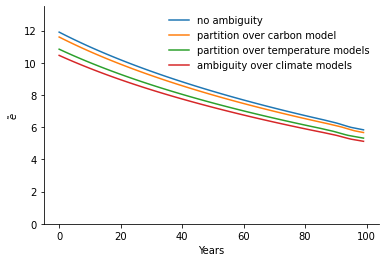

In [709]:
plt.plot(et_neutral, label="no ambiguity")
plt.plot(et_carb, label="partition over carbon model")
plt.plot(et_temp, label="partition over temperature models")
plt.plot(et_avg, label = "ambiguity over climate models")
plt.legend(frameon=False, loc='upper right')
plt.xlabel("Years")
plt.ylabel('$\\tilde e$')
plt.ylim(0,13.5)
# plt.savefig("../figures/ems_partition.pdf")